# Perform ablation study to the regvelo

Select four different GRN to perform ablation including:
 - prior GRN (binary matrix)
 - SCENIC+ learned GRN
 - RegVelo learned weight but shuffled GRN
 - RegVelo learned GRN

## Library imports

In [1]:
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

import scanpy as sc
import scvi
from regvelo import REGVELOVI

from rgv_tools import DATA_DIR, FIG_DIR
from rgv_tools.perturbation import get_list_name, TFScanning

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_t

## General settings

In [2]:
%matplotlib inline

In [3]:
scvi.settings.seed = 0

[rank: 0] Seed set to 0


## Constants

In [ ]:
DATASET = "zebrafish"

In [4]:
SAVE_DATA = True
if SAVE_DATA:
    (DATA_DIR / DATASET / "processed").mkdir(parents=True, exist_ok=True)
    (DATA_DIR / DATASET / "results").mkdir(parents=True, exist_ok=True)

In [5]:
SAVE_FIGURES = False
if SAVE_FIGURES:
    (FIG_DIR).mkdir(parents=True, exist_ok=True)

In [6]:
genes = ["nr2f5", "sox9b", "twist1b", "ets1"]

In [7]:
TERMINAL_STATES = [
    "mNC_head_mesenchymal",
    "mNC_arch2",
    "mNC_hox34",
    "Pigment",
]

In [9]:
MODEL = DATA_DIR / DATASET / "processed" / "rgv_model"

## Define function

In [10]:
def shuffle_binary_grn(GRN: pd.DataFrame, TFs: list) -> pd.DataFrame:
    """Shuffle a binary GRN matrix by randomizing its labels.

      - Only the TF (row) labels among themselves.
      - All column (target gene) labels.

    The GRN matrix values remain unchanged.

    Parameters
    ----------
    GRN : pd.DataFrame
        Square gene regulatory network matrix (regulators × targets)
    TFs : list
        List of transcription factor gene names (subset of GRN.index)
    random_state : int, optional
        Seed for reproducibility.

    Returns
    -------
    pd.DataFrame
        GRN with TF row labels shuffled and all column labels shuffled.
    """
    new_row_labels = list(GRN.index)
    new_col_labels = list(GRN.columns)

    shuffled_TF_labels = list(np.random.permutation(TFs))
    for old, new in zip(TFs, shuffled_TF_labels):
        idx = new_row_labels.index(old)
        new_row_labels[idx] = new

    shuffled_col_labels = list(np.random.permutation(new_col_labels))

    shuffled_GRN = GRN.copy()
    shuffled_GRN.index = new_row_labels
    shuffled_GRN.columns = shuffled_col_labels

    return shuffled_GRN

## Data loading

In [11]:
adata = sc.read_h5ad(DATA_DIR / DATASET / "processed" / "adata_preprocessed.h5ad")

## Trained regvelo model

In [10]:
# Prepare skeleton
W = adata.uns["skeleton"].copy()
W = torch.tensor(np.array(W)).int()

# Prepare TF
TF = adata.var_names[adata.var["TF"]]

# Prepare model
REGVELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
vae = REGVELOVI(adata, W=W.T, regulators=TF, soft_constraint=False)

In [93]:
vae.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB MIG 3g.20gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-e0df68bb-1411-5451-b9de-f747a79c3434]


Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2368.719. Signaling Trainer to stop.


In [94]:
vae.save(MODEL)

## Prepare GRN

### Prepare binary GRN (prior GRN)

In [34]:
W = adata.uns["skeleton"].copy()
binary = torch.tensor(np.array(W)).int()

### Prepare SCENIC+ GRN (weighted prior GRN)

In [84]:
net = pd.read_csv(DATA_DIR / DATASET / "raw" / "eRegulon_metadata_all.csv", index_col=0)

In [85]:
grn = pd.DataFrame({"source": net["TF"], "target": net["Gene"], "weight": net["TF2G_rho"]})

In [86]:
matrix = grn.pivot_table(index="source", columns="target", values="weight", fill_value=0)
# Ensure all genes (TFs and targets) appear as both rows and columns
genes = sorted(set(grn["source"]) | set(grn["target"]))
matrix = matrix.reindex(index=genes, columns=genes, fill_value=0)

In [87]:
matrix = matrix.loc[W.index, W.columns].copy()
np.fill_diagonal(matrix.values, 0)
scenic_grn = torch.tensor(np.array(matrix)).int()

In [88]:
matrix[W == 0] = 0

### Prepare random shuffled GRN

In [95]:
vae = REGVELOVI.load(MODEL, adata)

INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


In [96]:
W = pd.DataFrame(vae.module.v_encoder.fc1.weight.data.cpu().numpy(), index=adata.var_names, columns=adata.var_names)

In [119]:
randomized = W.copy()
mask = W != 0
weights = np.array(W)[mask]
np.random.shuffle(weights)

randomized.values[mask] = weights

## Trained Model (fixed prior GRN)

In [130]:
scvi.settings.seed = 0

[rank: 0] Seed set to 0


In [131]:
vae_b = REGVELOVI(adata, W=binary.T * 0, regulators=TF, soft_constraint=False)
vae_b.module.v_encoder.fc1.weight.data = torch.tensor(binary.T, dtype=torch.float32)
vae_b.train()

/tmp/ipykernel_4110717/2649694102.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vae_b.module.v_encoder.fc1.weight.data = torch.tensor(binary.T,dtype = torch.float32)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-e0df68bb-1411-5451-b9de-f747a79c3434]


Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1641.570. Signaling Trainer to stop.


In [58]:
## Randomized GRN
for nrun in range(10):
    filename_br = "rgv_model_b_random" + f"_{nrun+1}"
    MODEL_B_R = DATA_DIR / DATASET / "processed" / filename_br

    # Prepare skeleton
    W = adata.uns["skeleton"].copy()
    W_r = shuffle_binary_grn(W, W.index[W.sum(1) != 0])
    W_r = W_r.loc[W.index, W.columns]

    binary_r = torch.tensor(np.array(W_r)).int()

    # Prepare model
    vae_br = REGVELOVI(adata, W=binary_r.T * 0, regulators=TF, soft_constraint=False)
    vae_br.module.v_encoder.fc1.weight.data = torch.tensor(binary_r.T, dtype=torch.float32)
    vae_br.train()

    vae_br.save(MODEL_B_R)

/tmp/ipykernel_2834884/2135397401.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vae_br.module.v_encoder.fc1.weight.data = torch.tensor(binary_r.T,dtype = torch.float32)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB MIG 3g.20gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a50f3cc5-4165-5bbc-b58e-02013bf86b4f]


Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2043.189. Signaling Trainer to stop.


/tmp/ipykernel_2834884/2135397401.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vae_br.module.v_encoder.fc1.weight.data = torch.tensor(binary_r.T,dtype = torch.float32)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a50f3cc5-4165-5bbc-b58e-02013bf86b4f]


Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2098.423. Signaling Trainer to stop.


/tmp/ipykernel_2834884/2135397401.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vae_br.module.v_encoder.fc1.weight.data = torch.tensor(binary_r.T,dtype = torch.float32)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a50f3cc5-4165-5bbc-b58e-02013bf86b4f]


Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2140.119. Signaling Trainer to stop.


/tmp/ipykernel_2834884/2135397401.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vae_br.module.v_encoder.fc1.weight.data = torch.tensor(binary_r.T,dtype = torch.float32)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a50f3cc5-4165-5bbc-b58e-02013bf86b4f]


Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2130.564. Signaling Trainer to stop.


/tmp/ipykernel_2834884/2135397401.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vae_br.module.v_encoder.fc1.weight.data = torch.tensor(binary_r.T,dtype = torch.float32)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a50f3cc5-4165-5bbc-b58e-02013bf86b4f]


Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2083.802. Signaling Trainer to stop.


/tmp/ipykernel_2834884/2135397401.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vae_br.module.v_encoder.fc1.weight.data = torch.tensor(binary_r.T,dtype = torch.float32)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a50f3cc5-4165-5bbc-b58e-02013bf86b4f]


Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2150.982. Signaling Trainer to stop.


/tmp/ipykernel_2834884/2135397401.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vae_br.module.v_encoder.fc1.weight.data = torch.tensor(binary_r.T,dtype = torch.float32)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a50f3cc5-4165-5bbc-b58e-02013bf86b4f]


Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1765.108. Signaling Trainer to stop.


/tmp/ipykernel_2834884/2135397401.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vae_br.module.v_encoder.fc1.weight.data = torch.tensor(binary_r.T,dtype = torch.float32)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a50f3cc5-4165-5bbc-b58e-02013bf86b4f]


Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2093.261. Signaling Trainer to stop.


/tmp/ipykernel_2834884/2135397401.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vae_br.module.v_encoder.fc1.weight.data = torch.tensor(binary_r.T,dtype = torch.float32)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a50f3cc5-4165-5bbc-b58e-02013bf86b4f]


Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2097.862. Signaling Trainer to stop.


/tmp/ipykernel_2834884/2135397401.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vae_br.module.v_encoder.fc1.weight.data = torch.tensor(binary_r.T,dtype = torch.float32)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a50f3cc5-4165-5bbc-b58e-02013bf86b4f]


Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2120.992. Signaling Trainer to stop.


## Trained Model (fixed SCENIC+ weighted prior GRN)

In [137]:
scvi.settings.seed = 0

[rank: 0] Seed set to 0


In [138]:
vae_s = REGVELOVI(adata, W=scenic_grn.T * 0, regulators=TF, soft_constraint=False)
vae_s.module.v_encoder.fc1.weight.data = torch.tensor(scenic_grn.T, dtype=torch.float32)
vae_s.train()

/tmp/ipykernel_4110717/4259614751.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vae_s.module.v_encoder.fc1.weight.data = torch.tensor(scenic_grn.T,dtype = torch.float32)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-e0df68bb-1411-5451-b9de-f747a79c3434]


Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2045.730. Signaling Trainer to stop.


## Trained Model (shuffled GRN)

In [142]:
scvi.settings.seed = 0

[rank: 0] Seed set to 0


In [143]:
randomized = torch.tensor(np.array(randomized))

In [144]:
vae_r = REGVELOVI(adata, W=randomized * 0, regulators=TF, soft_constraint=False)
vae_r.module.v_encoder.fc1.weight.data = torch.tensor(randomized, dtype=torch.float32)
vae_r.train()

/tmp/ipykernel_4110717/583486168.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vae_r.module.v_encoder.fc1.weight.data = torch.tensor(randomized,dtype = torch.float32)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-e0df68bb-1411-5451-b9de-f747a79c3434]


Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1609.129. Signaling Trainer to stop.


In [11]:
MODEL_B = DATA_DIR / DATASET / "processed" / "rgv_model_b"
MODEL_S = DATA_DIR / DATASET / "processed" / "rgv_model_s"
MODEL_R = DATA_DIR / DATASET / "processed" / "rgv_model_r"

In [146]:
vae_b.save(MODEL_B)
vae_s.save(MODEL_S)
vae_r.save(MODEL_R)

## Driver ranking

In [147]:
perturb_screening = TFScanning(MODEL, adata, 7, "cell_type", TERMINAL_STATES, TF, 0)

INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 00:09:23,047 - INFO - Using pre-computed Schur decomposition


INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
2025-10-15 00:09:33,556 - INFO - Using pre-computed Schur decomposition


Done alx4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:09:44,085 - INFO - Using pre-computed Schur decomposition


Done arntl1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:09:53,789 - INFO - Using pre-computed Schur decomposition


Done bach2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:10:05,716 - INFO - Using pre-computed Schur decomposition


Done bhlhe40
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:10:15,554 - INFO - Using pre-computed Schur decomposition


Done bhlhe41
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:10:25,210 - INFO - Using pre-computed Schur decomposition


Done dlx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: 

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:10:34,893 - INFO - Using pre-computed Schur decomposition


Done ebf1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:10:44,530 - INFO - Using pre-computed Schur decomposition


Done ebf3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:10:54,519 - INFO - Using pre-computed Schur decomposition


Done egr1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:11:04,373 - INFO - Using pre-computed Schur decomposition


Done egr2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:11:14,481 - INFO - Using pre-computed Schur decomposition


Done egr3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:11:24,185 - INFO - Using pre-computed Schur decomposition


Done egr4
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:11:33,950 - INFO - Using pre-computed Schur decomposition


Done elf1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:11:43,839 - INFO - Using pre-computed Schur decomposition


Done elk3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:11:54,051 - INFO - Using pre-computed Schur decomposition


Done erf
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:12:03,922 - INFO - Using pre-computed Schur decomposition


Done erfl3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:12:14,152 - INFO - Using pre-computed Schur decomposition


Done ets1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:12:23,958 - INFO - Using pre-computed Schur decomposition


Done etv5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:12:33,804 - INFO - Using pre-computed Schur decomposition


Done fli1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:12:43,609 - INFO - Using pre-computed Schur decomposition


Done fosab
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:12:54,015 - INFO - Using pre-computed Schur decomposition


Done fosl1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:13:03,850 - INFO - Using pre-computed Schur decomposition


Done fosl2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:13:13,787 - INFO - Using pre-computed Schur decomposition


Done her9
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:13:23,884 - INFO - Using pre-computed Schur decomposition


Done hnf1ba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:13:34,378 - INFO - Using pre-computed Schur decomposition


Done hnf1bb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:13:44,255 - INFO - Using pre-computed Schur decomposition


Done hoxa11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 00:13:55,174 - INFO - Using pre-computed Schur decomposition


Done hoxa2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:14:05,576 - INFO - Using pre-computed Schur decomposition


Done hoxa4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:14:15,647 - INFO - Using pre-computed Schur decomposition


Done hoxa9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:14:25,715 - INFO - Using pre-computed Schur decomposition


Done hoxa9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:14:35,612 - INFO - Using pre-computed Schur decomposition


Done hoxb10a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:14:45,382 - INFO - Using pre-computed Schur decomposition


Done hoxb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:14:55,608 - INFO - Using pre-computed Schur decomposition


Done hoxb5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:15:05,828 - INFO - Using pre-computed Schur decomposition


Done hoxb9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:15:16,022 - INFO - Using pre-computed Schur decomposition


Done hoxc11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:15:25,817 - INFO - Using pre-computed Schur decomposition


Done hoxc3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:15:35,811 - INFO - Using pre-computed Schur decomposition


Done hoxc9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:15:45,846 - INFO - Using pre-computed Schur decomposition


Done hoxd11a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:15:55,923 - INFO - Using pre-computed Schur decomposition


Done hoxd12a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:16:06,526 - INFO - Using pre-computed Schur decomposition


Done jdp2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:16:16,600 - INFO - Using pre-computed Schur decomposition


Done jun
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:16:26,617 - INFO - Using pre-computed Schur decomposition


Done junba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:16:36,685 - INFO - Using pre-computed Schur decomposition


Done mitfa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:16:46,645 - INFO - Using pre-computed Schur decomposition


Done msx1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:16:56,557 - INFO - Using pre-computed Schur decomposition


Done msx3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:17:06,841 - INFO - Using pre-computed Schur decomposition


Done mycb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:17:17,012 - INFO - Using pre-computed Schur decomposition


Done nfe2l2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:17:27,110 - INFO - Using pre-computed Schur decomposition


Done nr2f2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:17:37,326 - INFO - Using pre-computed Schur decomposition


Done nr2f5
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:17:47,209 - INFO - Using pre-computed Schur decomposition


Done nr2f6b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:17:57,243 - INFO - Using pre-computed Schur decomposition


Done nr4a2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:18:07,644 - INFO - Using pre-computed Schur decomposition


Done nr4a3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:18:17,721 - INFO - Using pre-computed Schur decomposition


Done otx2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:18:28,324 - INFO - Using pre-computed Schur decomposition


Done pbx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:18:38,365 - INFO - Using pre-computed Schur decomposition


Done pknox2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 00:18:48,614 - INFO - Using pre-computed Schur decomposition


Done rarga
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:18:58,776 - INFO - Using pre-computed Schur decomposition


Done rxraa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:19:09,393 - INFO - Using pre-computed Schur decomposition


Done snai1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:19:19,488 - INFO - Using pre-computed Schur decomposition


Done sox10
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:19:29,585 - INFO - Using pre-computed Schur decomposition


Done sox6
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: 

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:19:39,959 - INFO - Using pre-computed Schur decomposition


Done sox9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:19:50,023 - INFO - Using pre-computed Schur decomposition


Done tead1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:20:00,128 - INFO - Using pre-computed Schur decomposition


Done tead1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:20:10,739 - INFO - Using pre-computed Schur decomposition


Done tead3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:20:20,940 - INFO - Using pre-computed Schur decomposition


Done tead3b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:20:31,215 - INFO - Using pre-computed Schur decomposition


Done tfap2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:20:41,372 - INFO - Using pre-computed Schur decomposition


Done tfap2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:20:51,653 - INFO - Using pre-computed Schur decomposition


Done tfap2e
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:21:02,135 - INFO - Using pre-computed Schur decomposition


Done tfeb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:21:12,861 - INFO - Using pre-computed Schur decomposition


Done tfec
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:21:23,187 - INFO - Using pre-computed Schur decomposition


Done twist1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:21:33,572 - INFO - Using pre-computed Schur decomposition


Done twist1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:21:43,642 - INFO - Using pre-computed Schur decomposition


Done zeb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:21:53,903 - INFO - Using pre-computed Schur decomposition


Done zic2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l/model.pt already downloaded                                                                             


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:22:04,198 - INFO - Using pre-computed Schur decomposition


Done zic2b


In [148]:
perturb_screening_b = TFScanning(MODEL_B, adata, 7, "cell_type", TERMINAL_STATES, TF, 0)

INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:22:15,114 - INFO - Using pre-computed Schur decomposition


INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:22:25,152 - INFO - Using pre-computed Schur decomposition


Done alx4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:22:35,212 - INFO - Using pre-computed Schur decomposition


Done arntl1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:22:45,300 - INFO - Using pre-computed Schur decomposition


Done bach2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:22:55,380 - INFO - Using pre-computed Schur decomposition


Done bhlhe40
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:23:05,512 - INFO - Using pre-computed Schur decomposition


Done bhlhe41
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:23:21,441 - INFO - Using pre-computed Schur decomposition


Done dlx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:23:32,021 - INFO - Using pre-computed Schur decomposition


Done ebf1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:23:42,746 - INFO - Using pre-computed Schur decomposition


Done ebf3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:23:52,972 - INFO - Using pre-computed Schur decomposition


Done egr1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: 

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:24:03,364 - INFO - Using pre-computed Schur decomposition


Done egr2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:24:13,936 - INFO - Using pre-computed Schur decomposition


Done egr3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:24:24,794 - INFO - Using pre-computed Schur decomposition


Done egr4
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:24:35,008 - INFO - Using pre-computed Schur decomposition


Done elf1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:24:45,518 - INFO - Using pre-computed Schur decomposition


Done elk3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:24:55,879 - INFO - Using pre-computed Schur decomposition


Done erf
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:25:06,246 - INFO - Using pre-computed Schur decomposition


Done erfl3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:25:16,470 - INFO - Using pre-computed Schur decomposition


Done ets1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:25:26,619 - INFO - Using pre-computed Schur decomposition


Done etv5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:25:36,960 - INFO - Using pre-computed Schur decomposition


Done fli1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:25:47,086 - INFO - Using pre-computed Schur decomposition


Done fosab
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:25:57,335 - INFO - Using pre-computed Schur decomposition


Done fosl1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:26:08,050 - INFO - Using pre-computed Schur decomposition


Done fosl2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:26:18,728 - INFO - Using pre-computed Schur decomposition


Done her9
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:26:29,468 - INFO - Using pre-computed Schur decomposition


Done hnf1ba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:26:39,601 - INFO - Using pre-computed Schur decomposition


Done hnf1bb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:26:49,901 - INFO - Using pre-computed Schur decomposition


Done hoxa11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:27:00,194 - INFO - Using pre-computed Schur decomposition


Done hoxa2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 00:27:10,540 - INFO - Using pre-computed Schur decomposition


Done hoxa4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:27:21,198 - INFO - Using pre-computed Schur decomposition


Done hoxa9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:27:31,541 - INFO - Using pre-computed Schur decomposition


Done hoxa9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:27:42,036 - INFO - Using pre-computed Schur decomposition


Done hoxb10a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:27:52,218 - INFO - Using pre-computed Schur decomposition


Done hoxb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:28:02,591 - INFO - Using pre-computed Schur decomposition


Done hoxb5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:28:13,301 - INFO - Using pre-computed Schur decomposition


Done hoxb9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:28:24,328 - INFO - Using pre-computed Schur decomposition


Done hoxc11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:28:34,789 - INFO - Using pre-computed Schur decomposition


Done hoxc3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:28:45,403 - INFO - Using pre-computed Schur decomposition


Done hoxc9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:28:55,733 - INFO - Using pre-computed Schur decomposition


Done hoxd11a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:29:05,959 - INFO - Using pre-computed Schur decomposition


Done hoxd12a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:29:16,189 - INFO - Using pre-computed Schur decomposition


Done jdp2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:29:26,802 - INFO - Using pre-computed Schur decomposition


Done jun
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:29:37,660 - INFO - Using pre-computed Schur decomposition


Done junba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:29:48,109 - INFO - Using pre-computed Schur decomposition


Done mitfa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:29:58,546 - INFO - Using pre-computed Schur decomposition


Done msx1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:30:08,842 - INFO - Using pre-computed Schur decomposition


Done msx3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:30:19,028 - INFO - Using pre-computed Schur decomposition


Done mycb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:30:29,593 - INFO - Using pre-computed Schur decomposition


Done nfe2l2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:30:39,778 - INFO - Using pre-computed Schur decomposition


Done nr2f2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:30:50,694 - INFO - Using pre-computed Schur decomposition


Done nr2f5
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: 

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:31:01,189 - INFO - Using pre-computed Schur decomposition


Done nr2f6b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:31:11,651 - INFO - Using pre-computed Schur decomposition


Done nr4a2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:31:22,137 - INFO - Using pre-computed Schur decomposition


Done nr4a3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:31:32,716 - INFO - Using pre-computed Schur decomposition


Done otx2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:31:43,620 - INFO - Using pre-computed Schur decomposition


Done pbx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:31:53,811 - INFO - Using pre-computed Schur decomposition


Done pknox2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:32:04,035 - INFO - Using pre-computed Schur decomposition


Done rarga
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:32:14,559 - INFO - Using pre-computed Schur decomposition


Done rxraa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:32:25,124 - INFO - Using pre-computed Schur decomposition


Done snai1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:32:35,373 - INFO - Using pre-computed Schur decomposition


Done sox10
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:32:45,720 - INFO - Using pre-computed Schur decomposition


Done sox6
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:32:55,936 - INFO - Using pre-computed Schur decomposition


Done sox9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:33:06,417 - INFO - Using pre-computed Schur decomposition


Done tead1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:33:17,146 - INFO - Using pre-computed Schur decomposition


Done tead1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:33:27,423 - INFO - Using pre-computed Schur decomposition


Done tead3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:33:38,447 - INFO - Using pre-computed Schur decomposition


Done tead3b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:33:49,155 - INFO - Using pre-computed Schur decomposition


Done tfap2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:33:59,831 - INFO - Using pre-computed Schur decomposition


Done tfap2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:34:10,143 - INFO - Using pre-computed Schur decomposition


Done tfap2e
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:34:20,550 - INFO - Using pre-computed Schur decomposition


Done tfeb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:34:31,008 - INFO - Using pre-computed Schur decomposition


Done tfec
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:34:42,148 - INFO - Using pre-computed Schur decomposition


Done twist1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:34:52,444 - INFO - Using pre-computed Schur decomposition


Done twist1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:35:02,904 - INFO - Using pre-computed Schur decomposition


Done zeb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:35:13,351 - INFO - Using pre-computed Schur decomposition


Done zic2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:35:23,772 - INFO - Using pre-computed Schur decomposition


Done zic2b


In [149]:
perturb_screening_s = TFScanning(MODEL_S, adata, 7, "cell_type", TERMINAL_STATES, TF, 0)

INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:35:34,957 - INFO - Using pre-computed Schur decomposition


INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:35:45,334 - INFO - Using pre-computed Schur decomposition


Done alx4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:35:55,973 - INFO - Using pre-computed Schur decomposition


Done arntl1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:36:06,261 - INFO - Using pre-computed Schur decomposition


Done bach2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:36:16,794 - INFO - Using pre-computed Schur decomposition


Done bhlhe40
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:36:27,236 - INFO - Using pre-computed Schur decomposition


Done bhlhe41
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:36:37,475 - INFO - Using pre-computed Schur decomposition


Done dlx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:36:48,040 - INFO - Using pre-computed Schur decomposition


Done ebf1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:36:58,273 - INFO - Using pre-computed Schur decomposition


Done ebf3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:37:12,699 - INFO - Using pre-computed Schur decomposition


Done egr1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:37:23,538 - INFO - Using pre-computed Schur decomposition


Done egr2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:37:34,372 - INFO - Using pre-computed Schur decomposition


Done egr3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:37:45,209 - INFO - Using pre-computed Schur decomposition


Done egr4
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: 

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:37:55,554 - INFO - Using pre-computed Schur decomposition


Done elf1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:38:06,058 - INFO - Using pre-computed Schur decomposition


Done elk3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:38:16,515 - INFO - Using pre-computed Schur decomposition


Done erf
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:38:26,837 - INFO - Using pre-computed Schur decomposition


Done erfl3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:38:38,070 - INFO - Using pre-computed Schur decomposition


Done ets1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:38:48,814 - INFO - Using pre-computed Schur decomposition


Done etv5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:38:59,913 - INFO - Using pre-computed Schur decomposition


Done fli1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:39:10,480 - INFO - Using pre-computed Schur decomposition


Done fosab
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:39:21,024 - INFO - Using pre-computed Schur decomposition


Done fosl1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:39:31,559 - INFO - Using pre-computed Schur decomposition


Done fosl2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:39:42,174 - INFO - Using pre-computed Schur decomposition


Done her9
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:39:53,667 - INFO - Using pre-computed Schur decomposition


Done hnf1ba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:40:04,208 - INFO - Using pre-computed Schur decomposition


Done hnf1bb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:40:14,741 - INFO - Using pre-computed Schur decomposition


Done hoxa11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:40:25,058 - INFO - Using pre-computed Schur decomposition


Done hoxa2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:40:35,481 - INFO - Using pre-computed Schur decomposition


Done hoxa4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: 

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:40:46,516 - INFO - Using pre-computed Schur decomposition


Done hoxa9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:40:57,108 - INFO - Using pre-computed Schur decomposition


Done hoxa9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:41:07,631 - INFO - Using pre-computed Schur decomposition


Done hoxb10a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:41:17,942 - INFO - Using pre-computed Schur decomposition


Done hoxb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:41:28,795 - INFO - Using pre-computed Schur decomposition


Done hoxb5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:41:39,083 - INFO - Using pre-computed Schur decomposition


Done hoxb9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:41:50,093 - INFO - Using pre-computed Schur decomposition


Done hoxc11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:42:00,750 - INFO - Using pre-computed Schur decomposition


Done hoxc3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:42:11,581 - INFO - Using pre-computed Schur decomposition


Done hoxc9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:42:22,412 - INFO - Using pre-computed Schur decomposition


Done hoxd11a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:42:32,728 - INFO - Using pre-computed Schur decomposition


Done hoxd12a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:42:43,135 - INFO - Using pre-computed Schur decomposition


Done jdp2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:42:53,770 - INFO - Using pre-computed Schur decomposition


Done jun
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:43:04,353 - INFO - Using pre-computed Schur decomposition


Done junba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:43:14,973 - INFO - Using pre-computed Schur decomposition


Done mitfa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:43:25,198 - INFO - Using pre-computed Schur decomposition


Done msx1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:43:36,024 - INFO - Using pre-computed Schur decomposition


Done msx3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:43:46,616 - INFO - Using pre-computed Schur decomposition


Done mycb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:43:56,872 - INFO - Using pre-computed Schur decomposition


Done nfe2l2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:44:07,394 - INFO - Using pre-computed Schur decomposition


Done nr2f2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:44:17,719 - INFO - Using pre-computed Schur decomposition


Done nr2f5
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:44:28,416 - INFO - Using pre-computed Schur decomposition


Done nr2f6b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:44:38,671 - INFO - Using pre-computed Schur decomposition


Done nr4a2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:44:49,111 - INFO - Using pre-computed Schur decomposition


Done nr4a3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:44:59,930 - INFO - Using pre-computed Schur decomposition


Done otx2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:45:10,637 - INFO - Using pre-computed Schur decomposition


Done pbx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:45:21,076 - INFO - Using pre-computed Schur decomposition


Done pknox2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:45:31,470 - INFO - Using pre-computed Schur decomposition


Done rarga
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:45:42,169 - INFO - Using pre-computed Schur decomposition


Done rxraa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:45:52,756 - INFO - Using pre-computed Schur decomposition


Done snai1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:46:03,908 - INFO - Using pre-computed Schur decomposition


Done sox10
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:46:14,493 - INFO - Using pre-computed Schur decomposition


Done sox6
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:46:24,892 - INFO - Using pre-computed Schur decomposition


Done sox9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:46:35,433 - INFO - Using pre-computed Schur decomposition


Done tead1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:46:46,097 - INFO - Using pre-computed Schur decomposition


Done tead1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:46:57,259 - INFO - Using pre-computed Schur decomposition


Done tead3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:47:08,237 - INFO - Using pre-computed Schur decomposition


Done tead3b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:47:19,055 - INFO - Using pre-computed Schur decomposition


Done tfap2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:47:29,403 - INFO - Using pre-computed Schur decomposition


Done tfap2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:47:40,241 - INFO - Using pre-computed Schur decomposition


Done tfap2e
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:47:50,816 - INFO - Using pre-computed Schur decomposition


Done tfeb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:48:01,329 - INFO - Using pre-computed Schur decomposition


Done tfec
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:48:11,888 - INFO - Using pre-computed Schur decomposition


Done twist1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:48:22,558 - INFO - Using pre-computed Schur decomposition


Done twist1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:48:33,158 - INFO - Using pre-computed Schur decomposition


Done zeb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:48:43,627 - INFO - Using pre-computed Schur decomposition


Done zic2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_s/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 00:48:54,075 - INFO - Using pre-computed Schur decomposition


Done zic2b


In [150]:
perturb_screening_r = TFScanning(MODEL_R, adata, 7, "cell_type", TERMINAL_STATES, TF, 0)

INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:49:04,954 - INFO - Using pre-computed Schur decomposition


INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:49:15,208 - INFO - Using pre-computed Schur decomposition


Done alx4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 00:49:25,571 - INFO - Using pre-computed Schur decomposition


Done arntl1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:49:36,023 - INFO - Using pre-computed Schur decomposition


Done bach2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:49:46,658 - INFO - Using pre-computed Schur decomposition


Done bhlhe40
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:49:57,043 - INFO - Using pre-computed Schur decomposition


Done bhlhe41
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:50:07,747 - INFO - Using pre-computed Schur decomposition


Done dlx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: 

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:50:18,199 - INFO - Using pre-computed Schur decomposition


Done ebf1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:50:28,566 - INFO - Using pre-computed Schur decomposition


Done ebf3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:50:38,954 - INFO - Using pre-computed Schur decomposition


Done egr1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:50:49,427 - INFO - Using pre-computed Schur decomposition


Done egr2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:51:00,082 - INFO - Using pre-computed Schur decomposition


Done egr3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:51:10,842 - INFO - Using pre-computed Schur decomposition


Done egr4
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:51:25,719 - INFO - Using pre-computed Schur decomposition


Done elf1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:51:36,802 - INFO - Using pre-computed Schur decomposition


Done elk3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:51:47,452 - INFO - Using pre-computed Schur decomposition


Done erf
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:51:58,421 - INFO - Using pre-computed Schur decomposition


Done erfl3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:52:09,383 - INFO - Using pre-computed Schur decomposition


Done ets1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:52:20,186 - INFO - Using pre-computed Schur decomposition


Done etv5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:52:31,184 - INFO - Using pre-computed Schur decomposition


Done fli1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:52:41,723 - INFO - Using pre-computed Schur decomposition


Done fosab
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:52:52,722 - INFO - Using pre-computed Schur decomposition


Done fosl1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:53:03,434 - INFO - Using pre-computed Schur decomposition


Done fosl2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:53:13,866 - INFO - Using pre-computed Schur decomposition


Done her9
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:53:24,320 - INFO - Using pre-computed Schur decomposition


Done hnf1ba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:53:34,822 - INFO - Using pre-computed Schur decomposition


Done hnf1bb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:53:45,369 - INFO - Using pre-computed Schur decomposition


Done hoxa11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:53:55,923 - INFO - Using pre-computed Schur decomposition


Done hoxa2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:54:06,355 - INFO - Using pre-computed Schur decomposition


Done hoxa4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:54:16,994 - INFO - Using pre-computed Schur decomposition


Done hoxa9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:54:27,464 - INFO - Using pre-computed Schur decomposition


Done hoxa9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:54:38,096 - INFO - Using pre-computed Schur decomposition


Done hoxb10a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:54:48,382 - INFO - Using pre-computed Schur decomposition


Done hoxb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:54:58,707 - INFO - Using pre-computed Schur decomposition


Done hoxb5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:55:09,202 - INFO - Using pre-computed Schur decomposition


Done hoxb9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:55:19,499 - INFO - Using pre-computed Schur decomposition


Done hoxc11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:55:29,901 - INFO - Using pre-computed Schur decomposition


Done hoxc3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:55:40,267 - INFO - Using pre-computed Schur decomposition


Done hoxc9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: 

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:55:50,936 - INFO - Using pre-computed Schur decomposition


Done hoxd11a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:56:01,169 - INFO - Using pre-computed Schur decomposition


Done hoxd12a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:56:11,886 - INFO - Using pre-computed Schur decomposition


Done jdp2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:56:22,961 - INFO - Using pre-computed Schur decomposition


Done jun
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:56:33,509 - INFO - Using pre-computed Schur decomposition


Done junba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:56:44,014 - INFO - Using pre-computed Schur decomposition


Done mitfa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:56:54,281 - INFO - Using pre-computed Schur decomposition


Done msx1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:57:04,856 - INFO - Using pre-computed Schur decomposition


Done msx3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:57:15,306 - INFO - Using pre-computed Schur decomposition


Done mycb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:57:25,648 - INFO - Using pre-computed Schur decomposition


Done nfe2l2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:57:36,073 - INFO - Using pre-computed Schur decomposition


Done nr2f2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:57:46,549 - INFO - Using pre-computed Schur decomposition


Done nr2f5
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:57:56,846 - INFO - Using pre-computed Schur decomposition


Done nr2f6b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:58:07,479 - INFO - Using pre-computed Schur decomposition


Done nr4a2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:58:17,765 - INFO - Using pre-computed Schur decomposition


Done nr4a3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:58:28,095 - INFO - Using pre-computed Schur decomposition


Done otx2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:58:38,677 - INFO - Using pre-computed Schur decomposition


Done pbx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:58:49,293 - INFO - Using pre-computed Schur decomposition


Done pknox2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:58:59,672 - INFO - Using pre-computed Schur decomposition


Done rarga
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:59:09,966 - INFO - Using pre-computed Schur decomposition


Done rxraa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 00:59:20,136 - INFO - Using pre-computed Schur decomposition


Done snai1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:59:31,165 - INFO - Using pre-computed Schur decomposition


Done sox10
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:59:41,620 - INFO - Using pre-computed Schur decomposition


Done sox6
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 00:59:52,447 - INFO - Using pre-computed Schur decomposition


Done sox9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 01:00:03,128 - INFO - Using pre-computed Schur decomposition


Done tead1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 01:00:13,847 - INFO - Using pre-computed Schur decomposition


Done tead1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 01:00:24,725 - INFO - Using pre-computed Schur decomposition


Done tead3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 01:00:35,232 - INFO - Using pre-computed Schur decomposition


Done tead3b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 01:00:45,636 - INFO - Using pre-computed Schur decomposition


Done tfap2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 01:00:56,069 - INFO - Using pre-computed Schur decomposition


Done tfap2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 01:01:06,376 - INFO - Using pre-computed Schur decomposition


Done tfap2e
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 01:01:16,683 - INFO - Using pre-computed Schur decomposition


Done tfeb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 01:01:27,140 - INFO - Using pre-computed Schur decomposition


Done tfec
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 01:01:37,567 - INFO - Using pre-computed Schur decomposition


Done twist1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 01:01:48,054 - INFO - Using pre-computed Schur decomposition


Done twist1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 01:01:58,516 - INFO - Using pre-computed Schur decomposition


Done zeb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 01:02:08,859 - INFO - Using pre-computed Schur decomposition


Done zic2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
2025-10-15 01:02:19,322 - INFO - Using pre-computed Schur decomposition


Done zic2b


In [151]:
coef_name = "coef_raw"
coef_save = DATA_DIR / DATASET / "results" / coef_name

coef = pd.DataFrame(np.array(perturb_screening["coefficient"]))
coef.index = perturb_screening["TF"]
coef.columns = get_list_name(perturb_screening["coefficient"][0])

pval = pd.DataFrame(np.array(perturb_screening["pvalue"]))
pval.index = perturb_screening["TF"]
pval.columns = get_list_name(perturb_screening["pvalue"][0])

rows_with_nan = coef.isna().any(axis=1)
# Set all values in those rows to NaN
coef.loc[rows_with_nan, :] = np.nan
pval.loc[rows_with_nan, :] = np.nan

coef.to_csv(coef_save)

In [152]:
coef_name = "coef_binary"
coef_save_b = DATA_DIR / DATASET / "results" / coef_name

coef = pd.DataFrame(np.array(perturb_screening_b["coefficient"]))
coef.index = perturb_screening_b["TF"]
coef.columns = get_list_name(perturb_screening_b["coefficient"][0])

pval = pd.DataFrame(np.array(perturb_screening_b["pvalue"]))
pval.index = perturb_screening_b["TF"]
pval.columns = get_list_name(perturb_screening_b["pvalue"][0])

rows_with_nan = coef.isna().any(axis=1)
# Set all values in those rows to NaN
coef.loc[rows_with_nan, :] = np.nan
pval.loc[rows_with_nan, :] = np.nan

coef.to_csv(coef_save_b)

In [153]:
coef_name = "coef_scenic"
coef_save_s = DATA_DIR / DATASET / "results" / coef_name

coef = pd.DataFrame(np.array(perturb_screening_s["coefficient"]))
coef.index = perturb_screening_s["TF"]
coef.columns = get_list_name(perturb_screening_s["coefficient"][0])

pval = pd.DataFrame(np.array(perturb_screening_s["pvalue"]))
pval.index = perturb_screening_s["TF"]
pval.columns = get_list_name(perturb_screening_s["pvalue"][0])

rows_with_nan = coef.isna().any(axis=1)
# Set all values in those rows to NaN
coef.loc[rows_with_nan, :] = np.nan
pval.loc[rows_with_nan, :] = np.nan

coef.to_csv(coef_save_s)

In [154]:
coef_name = "coef_random"
coef_save_r = DATA_DIR / DATASET / "results" / coef_name

coef = pd.DataFrame(np.array(perturb_screening_r["coefficient"]))
coef.index = perturb_screening_r["TF"]
coef.columns = get_list_name(perturb_screening_r["coefficient"][0])

pval = pd.DataFrame(np.array(perturb_screening_r["pvalue"]))
pval.index = perturb_screening_r["TF"]
pval.columns = get_list_name(perturb_screening_r["pvalue"][0])

rows_with_nan = coef.isna().any(axis=1)
# Set all values in those rows to NaN
coef.loc[rows_with_nan, :] = np.nan
pval.loc[rows_with_nan, :] = np.nan

coef.to_csv(coef_save_r)

## Repeatively to run regvelo with another nine times

In [ ]:
## Randomized GRN
for nrun in range(9):
    filename = "rgv_model" + f"_{nrun+1}"
    filename_r = "rgv_model_r" + f"_{nrun+1}"

    MODEL = DATA_DIR / DATASET / "processed" / filename
    MODEL_R = DATA_DIR / DATASET / "processed" / filename_r

    # Prepare skeleton
    W = adata.uns["skeleton"].copy()
    W = torch.tensor(np.array(W)).int()

    # Prepare TF
    TF = adata.var_names[adata.var["TF"]]

    # Prepare model
    REGVELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
    vae = REGVELOVI(adata, W=W.T, regulators=TF, soft_constraint=False)
    vae.train()

    ### randomize GRN
    W = pd.DataFrame(vae.module.v_encoder.fc1.weight.data.cpu().numpy(), index=adata.var_names, columns=adata.var_names)
    randomized = W.copy()
    mask = W != 0
    weights = np.array(W)[mask]
    np.random.shuffle(weights)

    randomized.values[mask] = weights
    randomized = torch.tensor(np.array(randomized))

    vae_r = REGVELOVI(adata, W=randomized * 0, regulators=TF, soft_constraint=False)
    vae_r.module.v_encoder.fc1.weight.data = torch.tensor(randomized, dtype=torch.float32)
    vae_r.train()

    vae.save(MODEL)
    vae_r.save(MODEL_R)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-e0df68bb-1411-5451-b9de-f747a79c3434]


Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2350.273. Signaling Trainer to stop.


/tmp/ipykernel_4110717/2935111593.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vae_r.module.v_encoder.fc1.weight.data = torch.tensor(randomized,dtype = torch.float32)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-e0df68bb-1411-5451-b9de-f747a79c3434]


Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1783.546. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-e0df68bb-1411-5451-b9de-f747a79c3434]


Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2387.983. Signaling Trainer to stop.


/tmp/ipykernel_4110717/2935111593.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vae_r.module.v_encoder.fc1.weight.data = torch.tensor(randomized,dtype = torch.float32)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-e0df68bb-1411-5451-b9de-f747a79c3434]


Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1827.402. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-e0df68bb-1411-5451-b9de-f747a79c3434]


Training:   0%|          | 0/1500 [00:00<?, ?it/s]

In [168]:
perturb_screening_list = {}
perturb_screening_r_list = {}

for nrun in range(9):
    filename = "rgv_model" + f"_{nrun+1}"
    filename_r = "rgv_model_r" + f"_{nrun+1}"

    MODEL = DATA_DIR / DATASET / "processed" / filename
    MODEL_R = DATA_DIR / DATASET / "processed" / filename_r

    perturb_screening = TFScanning(MODEL, adata, 7, "cell_type", TERMINAL_STATES, TF, 0)
    perturb_screening_r = TFScanning(MODEL_R, adata, 7, "cell_type", TERMINAL_STATES, TF, 0)

    ## pertub coef
    coef_name = "coef_raw" + f"_{nrun+1}"
    coef_save = DATA_DIR / "results" / coef_name

    coef = pd.DataFrame(np.array(perturb_screening["coefficient"]))
    coef.index = perturb_screening["TF"]
    coef.columns = get_list_name(perturb_screening["coefficient"][0])

    rows_with_nan = coef.isna().any(axis=1)
    # Set all values in those rows to NaN
    coef.loc[rows_with_nan, :] = np.nan
    coef.to_csv(coef_save)
    perturb_screening_list[f"{nrun+1}"] = coef

    ## pertub coef_random
    coef_name = "coef_random" + f"_{nrun+1}"
    coef_save = DATA_DIR / "results" / coef_name

    coef = pd.DataFrame(np.array(perturb_screening_r["coefficient"]))
    coef.index = perturb_screening_r["TF"]
    coef.columns = get_list_name(perturb_screening_r["coefficient"][0])

    rows_with_nan = coef.isna().any(axis=1)
    # Set all values in those rows to NaN
    coef.loc[rows_with_nan, :] = np.nan
    coef.to_csv(coef_save)
    perturb_screening_r_list[f"{nrun+1}"] = coef

INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:39:42,252 - INFO - Using pre-computed Schur decomposition


INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:39:54,462 - INFO - Using pre-computed Schur decomposition


Done alx4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:40:05,200 - INFO - Using pre-computed Schur decomposition


Done arntl1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:40:15,604 - INFO - Using pre-computed Schur decomposition


Done bach2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:40:26,217 - INFO - Using pre-computed Schur decomposition


Done bhlhe40
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:40:36,736 - INFO - Using pre-computed Schur decomposition


Done bhlhe41
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:40:47,161 - INFO - Using pre-computed Schur decomposition


Done dlx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:40:58,247 - INFO - Using pre-computed Schur decomposition


Done ebf1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:41:08,733 - INFO - Using pre-computed Schur decomposition


Done ebf3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:41:26,660 - INFO - Using pre-computed Schur decomposition


Done egr1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:41:37,609 - INFO - Using pre-computed Schur decomposition


Done egr2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:41:48,195 - INFO - Using pre-computed Schur decomposition


Done egr3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:41:58,712 - INFO - Using pre-computed Schur decomposition


Done egr4
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:42:09,610 - INFO - Using pre-computed Schur decomposition


Done elf1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:42:20,507 - INFO - Using pre-computed Schur decomposition


Done elk3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:42:31,117 - INFO - Using pre-computed Schur decomposition


Done erf
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:42:41,779 - INFO - Using pre-computed Schur decomposition


Done erfl3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:42:52,956 - INFO - Using pre-computed Schur decomposition


Done ets1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:43:03,488 - INFO - Using pre-computed Schur decomposition


Done etv5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:43:13,918 - INFO - Using pre-computed Schur decomposition


Done fli1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:43:24,826 - INFO - Using pre-computed Schur decomposition


Done fosab
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:43:35,671 - INFO - Using pre-computed Schur decomposition


Done fosl1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:43:46,603 - INFO - Using pre-computed Schur decomposition


Done fosl2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:43:57,687 - INFO - Using pre-computed Schur decomposition


Done her9
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:44:08,672 - INFO - Using pre-computed Schur decomposition


Done hnf1ba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:44:19,094 - INFO - Using pre-computed Schur decomposition


Done hnf1bb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:44:35,310 - INFO - Using pre-computed Schur decomposition


Done hoxa11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:44:46,460 - INFO - Using pre-computed Schur decomposition


Done hoxa2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:44:58,324 - INFO - Using pre-computed Schur decomposition


Done hoxa4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:45:08,757 - INFO - Using pre-computed Schur decomposition


Done hoxa9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:45:19,211 - INFO - Using pre-computed Schur decomposition


Done hoxa9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:45:30,129 - INFO - Using pre-computed Schur decomposition


Done hoxb10a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:45:40,541 - INFO - Using pre-computed Schur decomposition


Done hoxb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:45:51,455 - INFO - Using pre-computed Schur decomposition


Done hoxb5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:46:02,563 - INFO - Using pre-computed Schur decomposition


Done hoxb9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:46:13,612 - INFO - Using pre-computed Schur decomposition


Done hoxc11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:46:24,164 - INFO - Using pre-computed Schur decomposition


Done hoxc3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:46:34,920 - INFO - Using pre-computed Schur decomposition


Done hoxc9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:46:45,281 - INFO - Using pre-computed Schur decomposition


Done hoxd11a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:46:55,717 - INFO - Using pre-computed Schur decomposition


Done hoxd12a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:47:06,179 - INFO - Using pre-computed Schur decomposition


Done jdp2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:47:16,355 - INFO - Using pre-computed Schur decomposition


Done jun
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:47:26,615 - INFO - Using pre-computed Schur decomposition


Done junba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:47:37,548 - INFO - Using pre-computed Schur decomposition


Done mitfa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:47:49,200 - INFO - Using pre-computed Schur decomposition


Done msx1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:48:00,241 - INFO - Using pre-computed Schur decomposition


Done msx3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:48:10,587 - INFO - Using pre-computed Schur decomposition


Done mycb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:48:20,960 - INFO - Using pre-computed Schur decomposition


Done nfe2l2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:48:31,942 - INFO - Using pre-computed Schur decomposition


Done nr2f2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:48:43,958 - INFO - Using pre-computed Schur decomposition


Done nr2f5
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:48:55,188 - INFO - Using pre-computed Schur decomposition


Done nr2f6b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:49:06,393 - INFO - Using pre-computed Schur decomposition


Done nr4a2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:49:17,559 - INFO - Using pre-computed Schur decomposition


Done nr4a3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:49:31,116 - INFO - Using pre-computed Schur decomposition


Done otx2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:49:44,454 - INFO - Using pre-computed Schur decomposition


Done pbx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:49:56,087 - INFO - Using pre-computed Schur decomposition


Done pknox2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:50:07,285 - INFO - Using pre-computed Schur decomposition


Done rarga
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:50:17,769 - INFO - Using pre-computed Schur decomposition


Done rxraa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:50:28,052 - INFO - Using pre-computed Schur decomposition


Done snai1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:50:39,628 - INFO - Using pre-computed Schur decomposition


Done sox10
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:50:50,008 - INFO - Using pre-computed Schur decomposition


Done sox6
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:51:00,686 - INFO - Using pre-computed Schur decomposition


Done sox9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:51:11,367 - INFO - Using pre-computed Schur decomposition


Done tead1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:51:22,077 - INFO - Using pre-computed Schur decomposition


Done tead1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:51:33,123 - INFO - Using pre-computed Schur decomposition


Done tead3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:51:43,892 - INFO - Using pre-computed Schur decomposition


Done tead3b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:51:54,745 - INFO - Using pre-computed Schur decomposition


Done tfap2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:52:05,248 - INFO - Using pre-computed Schur decomposition


Done tfap2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:52:15,658 - INFO - Using pre-computed Schur decomposition


Done tfap2e
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:52:26,116 - INFO - Using pre-computed Schur decomposition


Done tfeb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:52:36,731 - INFO - Using pre-computed Schur decomposition


Done tfec
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:52:48,277 - INFO - Using pre-computed Schur decomposition


Done twist1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:52:59,298 - INFO - Using pre-computed Schur decomposition


Done twist1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:53:10,480 - INFO - Using pre-computed Schur decomposition


Done zeb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:53:21,079 - INFO - Using pre-computed Schur decomposition


Done zic2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_1/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:53:31,571 - INFO - Using pre-computed Schur decomposition


Done zic2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:53:43,052 - INFO - Using pre-computed Schur decomposition


INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:53:55,420 - INFO - Using pre-computed Schur decomposition


Done alx4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:54:07,453 - INFO - Using pre-computed Schur decomposition


Done arntl1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:54:19,123 - INFO - Using pre-computed Schur decomposition


Done bach2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:54:30,216 - INFO - Using pre-computed Schur decomposition


Done bhlhe40
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:54:43,060 - INFO - Using pre-computed Schur decomposition


Done bhlhe41
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:54:54,257 - INFO - Using pre-computed Schur decomposition


Done dlx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:55:05,352 - INFO - Using pre-computed Schur decomposition


Done ebf1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:55:15,976 - INFO - Using pre-computed Schur decomposition


Done ebf3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:55:26,338 - INFO - Using pre-computed Schur decomposition


Done egr1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:55:36,769 - INFO - Using pre-computed Schur decomposition


Done egr2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:55:47,201 - INFO - Using pre-computed Schur decomposition


Done egr3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:55:57,567 - INFO - Using pre-computed Schur decomposition


Done egr4
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:56:08,200 - INFO - Using pre-computed Schur decomposition


Done elf1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:56:18,990 - INFO - Using pre-computed Schur decomposition


Done elk3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:56:29,593 - INFO - Using pre-computed Schur decomposition


Done erf
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:56:46,892 - INFO - Using pre-computed Schur decomposition


Done erfl3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:56:57,626 - INFO - Using pre-computed Schur decomposition


Done ets1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:57:08,405 - INFO - Using pre-computed Schur decomposition


Done etv5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:57:19,331 - INFO - Using pre-computed Schur decomposition


Done fli1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:57:30,419 - INFO - Using pre-computed Schur decomposition


Done fosab
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:57:40,909 - INFO - Using pre-computed Schur decomposition


Done fosl1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:57:51,604 - INFO - Using pre-computed Schur decomposition


Done fosl2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:58:02,510 - INFO - Using pre-computed Schur decomposition


Done her9
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:58:13,272 - INFO - Using pre-computed Schur decomposition


Done hnf1ba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:58:24,178 - INFO - Using pre-computed Schur decomposition


Done hnf1bb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:58:34,819 - INFO - Using pre-computed Schur decomposition


Done hoxa11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:58:45,575 - INFO - Using pre-computed Schur decomposition


Done hoxa2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:58:56,719 - INFO - Using pre-computed Schur decomposition


Done hoxa4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:59:10,070 - INFO - Using pre-computed Schur decomposition


Done hoxa9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:59:22,166 - INFO - Using pre-computed Schur decomposition


Done hoxa9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:59:32,960 - INFO - Using pre-computed Schur decomposition


Done hoxb10a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:59:44,268 - INFO - Using pre-computed Schur decomposition


Done hoxb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 08:59:55,034 - INFO - Using pre-computed Schur decomposition


Done hoxb5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:00:05,526 - INFO - Using pre-computed Schur decomposition


Done hoxb9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:00:16,033 - INFO - Using pre-computed Schur decomposition


Done hoxc11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:00:27,030 - INFO - Using pre-computed Schur decomposition


Done hoxc3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:00:37,446 - INFO - Using pre-computed Schur decomposition


Done hoxc9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:00:47,928 - INFO - Using pre-computed Schur decomposition


Done hoxd11a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:00:58,541 - INFO - Using pre-computed Schur decomposition


Done hoxd12a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:01:09,010 - INFO - Using pre-computed Schur decomposition


Done jdp2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:01:19,625 - INFO - Using pre-computed Schur decomposition


Done jun
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:01:30,476 - INFO - Using pre-computed Schur decomposition


Done junba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:01:41,436 - INFO - Using pre-computed Schur decomposition


Done mitfa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:01:52,775 - INFO - Using pre-computed Schur decomposition


Done msx1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:02:03,861 - INFO - Using pre-computed Schur decomposition


Done msx3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:02:14,620 - INFO - Using pre-computed Schur decomposition


Done mycb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:02:25,446 - INFO - Using pre-computed Schur decomposition


Done nfe2l2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:02:35,978 - INFO - Using pre-computed Schur decomposition


Done nr2f2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:02:46,348 - INFO - Using pre-computed Schur decomposition


Done nr2f5
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:02:56,819 - INFO - Using pre-computed Schur decomposition


Done nr2f6b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:03:07,691 - INFO - Using pre-computed Schur decomposition


Done nr4a2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:03:18,600 - INFO - Using pre-computed Schur decomposition


Done nr4a3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:03:29,226 - INFO - Using pre-computed Schur decomposition


Done otx2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:03:39,471 - INFO - Using pre-computed Schur decomposition


Done pbx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:03:49,950 - INFO - Using pre-computed Schur decomposition


Done pknox2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:04:00,525 - INFO - Using pre-computed Schur decomposition


Done rarga
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:04:11,566 - INFO - Using pre-computed Schur decomposition


Done rxraa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:04:22,491 - INFO - Using pre-computed Schur decomposition


Done snai1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:04:33,588 - INFO - Using pre-computed Schur decomposition


Done sox10
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:04:44,012 - INFO - Using pre-computed Schur decomposition


Done sox6
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:04:54,811 - INFO - Using pre-computed Schur decomposition


Done sox9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:05:05,490 - INFO - Using pre-computed Schur decomposition


Done tead1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:05:16,221 - INFO - Using pre-computed Schur decomposition


Done tead1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:05:27,312 - INFO - Using pre-computed Schur decomposition


Done tead3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:05:37,809 - INFO - Using pre-computed Schur decomposition


Done tead3b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:05:48,550 - INFO - Using pre-computed Schur decomposition


Done tfap2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:05:59,307 - INFO - Using pre-computed Schur decomposition


Done tfap2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:06:09,894 - INFO - Using pre-computed Schur decomposition


Done tfap2e
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:06:20,577 - INFO - Using pre-computed Schur decomposition


Done tfeb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:06:31,178 - INFO - Using pre-computed Schur decomposition


Done tfec
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:06:41,702 - INFO - Using pre-computed Schur decomposition


Done twist1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:06:52,431 - INFO - Using pre-computed Schur decomposition


Done twist1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:07:03,510 - INFO - Using pre-computed Schur decomposition


Done zeb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:07:14,024 - INFO - Using pre-computed Schur decomposition


Done zic2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_1/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:07:24,552 - INFO - Using pre-computed Schur decomposition


Done zic2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:07:35,862 - INFO - Using pre-computed Schur decomposition


INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:07:46,406 - INFO - Using pre-computed Schur decomposition


Done alx4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:07:57,139 - INFO - Using pre-computed Schur decomposition


Done arntl1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:08:07,541 - INFO - Using pre-computed Schur decomposition


Done bach2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:08:18,580 - INFO - Using pre-computed Schur decomposition


Done bhlhe40
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:08:29,697 - INFO - Using pre-computed Schur decomposition


Done bhlhe41
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:08:40,381 - INFO - Using pre-computed Schur decomposition


Done dlx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:08:50,731 - INFO - Using pre-computed Schur decomposition


Done ebf1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:09:01,524 - INFO - Using pre-computed Schur decomposition


Done ebf3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:09:12,023 - INFO - Using pre-computed Schur decomposition


Done egr1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:09:22,670 - INFO - Using pre-computed Schur decomposition


Done egr2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:09:33,522 - INFO - Using pre-computed Schur decomposition


Done egr3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:09:44,164 - INFO - Using pre-computed Schur decomposition


Done egr4
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:09:54,957 - INFO - Using pre-computed Schur decomposition


Done elf1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:10:05,321 - INFO - Using pre-computed Schur decomposition


Done elk3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:10:15,750 - INFO - Using pre-computed Schur decomposition


Done erf
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:10:26,537 - INFO - Using pre-computed Schur decomposition


Done erfl3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:10:36,995 - INFO - Using pre-computed Schur decomposition


Done ets1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:10:47,407 - INFO - Using pre-computed Schur decomposition


Done etv5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:10:57,809 - INFO - Using pre-computed Schur decomposition


Done fli1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:11:08,078 - INFO - Using pre-computed Schur decomposition


Done fosab
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:11:18,609 - INFO - Using pre-computed Schur decomposition


Done fosl1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:11:29,731 - INFO - Using pre-computed Schur decomposition


Done fosl2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:11:40,372 - INFO - Using pre-computed Schur decomposition


Done her9
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:11:50,943 - INFO - Using pre-computed Schur decomposition


Done hnf1ba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:12:08,459 - INFO - Using pre-computed Schur decomposition


Done hnf1bb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:12:19,131 - INFO - Using pre-computed Schur decomposition


Done hoxa11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:12:29,978 - INFO - Using pre-computed Schur decomposition


Done hoxa2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:12:40,550 - INFO - Using pre-computed Schur decomposition


Done hoxa4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:12:51,246 - INFO - Using pre-computed Schur decomposition


Done hoxa9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:13:02,031 - INFO - Using pre-computed Schur decomposition


Done hoxa9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:13:12,786 - INFO - Using pre-computed Schur decomposition


Done hoxb10a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:13:23,827 - INFO - Using pre-computed Schur decomposition


Done hoxb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:13:34,825 - INFO - Using pre-computed Schur decomposition


Done hoxb5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:13:45,655 - INFO - Using pre-computed Schur decomposition


Done hoxb9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:13:56,197 - INFO - Using pre-computed Schur decomposition


Done hoxc11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:14:06,874 - INFO - Using pre-computed Schur decomposition


Done hoxc3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:14:17,458 - INFO - Using pre-computed Schur decomposition


Done hoxc9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:14:28,508 - INFO - Using pre-computed Schur decomposition


Done hoxd11a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:14:39,058 - INFO - Using pre-computed Schur decomposition


Done hoxd12a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:14:49,998 - INFO - Using pre-computed Schur decomposition


Done jdp2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:15:00,654 - INFO - Using pre-computed Schur decomposition


Done jun
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:15:11,310 - INFO - Using pre-computed Schur decomposition


Done junba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:15:21,829 - INFO - Using pre-computed Schur decomposition


Done mitfa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:15:32,537 - INFO - Using pre-computed Schur decomposition


Done msx1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:15:43,295 - INFO - Using pre-computed Schur decomposition


Done msx3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:15:54,056 - INFO - Using pre-computed Schur decomposition


Done mycb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:16:04,801 - INFO - Using pre-computed Schur decomposition


Done nfe2l2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:16:15,323 - INFO - Using pre-computed Schur decomposition


Done nr2f2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:16:25,757 - INFO - Using pre-computed Schur decomposition


Done nr2f5
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:16:36,515 - INFO - Using pre-computed Schur decomposition


Done nr2f6b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:16:47,286 - INFO - Using pre-computed Schur decomposition


Done nr4a2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:16:58,085 - INFO - Using pre-computed Schur decomposition


Done nr4a3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:17:09,110 - INFO - Using pre-computed Schur decomposition


Done otx2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:17:19,431 - INFO - Using pre-computed Schur decomposition


Done pbx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:17:30,022 - INFO - Using pre-computed Schur decomposition


Done pknox2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:17:40,840 - INFO - Using pre-computed Schur decomposition


Done rarga
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:17:51,306 - INFO - Using pre-computed Schur decomposition


Done rxraa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:18:01,861 - INFO - Using pre-computed Schur decomposition


Done snai1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:18:12,515 - INFO - Using pre-computed Schur decomposition


Done sox10
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:18:22,939 - INFO - Using pre-computed Schur decomposition


Done sox6
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:18:33,542 - INFO - Using pre-computed Schur decomposition


Done sox9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:18:44,247 - INFO - Using pre-computed Schur decomposition


Done tead1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:18:54,843 - INFO - Using pre-computed Schur decomposition


Done tead1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:19:05,420 - INFO - Using pre-computed Schur decomposition


Done tead3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:19:15,634 - INFO - Using pre-computed Schur decomposition


Done tead3b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:19:26,095 - INFO - Using pre-computed Schur decomposition


Done tfap2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:19:37,155 - INFO - Using pre-computed Schur decomposition


Done tfap2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:19:47,605 - INFO - Using pre-computed Schur decomposition


Done tfap2e
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:19:58,190 - INFO - Using pre-computed Schur decomposition


Done tfeb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:20:08,716 - INFO - Using pre-computed Schur decomposition


Done tfec
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:20:19,507 - INFO - Using pre-computed Schur decomposition


Done twist1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:20:30,256 - INFO - Using pre-computed Schur decomposition


Done twist1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:20:41,010 - INFO - Using pre-computed Schur decomposition


Done zeb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:20:51,508 - INFO - Using pre-computed Schur decomposition


Done zic2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_2/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:21:02,013 - INFO - Using pre-computed Schur decomposition


Done zic2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:21:12,947 - INFO - Using pre-computed Schur decomposition


INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:21:23,420 - INFO - Using pre-computed Schur decomposition


Done alx4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:21:34,069 - INFO - Using pre-computed Schur decomposition


Done arntl1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:21:44,605 - INFO - Using pre-computed Schur decomposition


Done bach2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:21:55,985 - INFO - Using pre-computed Schur decomposition


Done bhlhe40
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:22:06,792 - INFO - Using pre-computed Schur decomposition


Done bhlhe41
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:22:17,674 - INFO - Using pre-computed Schur decomposition


Done dlx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:22:27,944 - INFO - Using pre-computed Schur decomposition


Done ebf1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:22:38,739 - INFO - Using pre-computed Schur decomposition


Done ebf3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:22:49,053 - INFO - Using pre-computed Schur decomposition


Done egr1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:22:59,645 - INFO - Using pre-computed Schur decomposition


Done egr2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:23:10,026 - INFO - Using pre-computed Schur decomposition


Done egr3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:23:20,582 - INFO - Using pre-computed Schur decomposition


Done egr4
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:23:31,262 - INFO - Using pre-computed Schur decomposition


Done elf1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:23:42,553 - INFO - Using pre-computed Schur decomposition


Done elk3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:23:52,847 - INFO - Using pre-computed Schur decomposition


Done erf
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:24:03,534 - INFO - Using pre-computed Schur decomposition


Done erfl3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:24:13,851 - INFO - Using pre-computed Schur decomposition


Done ets1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:24:24,268 - INFO - Using pre-computed Schur decomposition


Done etv5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:24:34,801 - INFO - Using pre-computed Schur decomposition


Done fli1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:24:45,399 - INFO - Using pre-computed Schur decomposition


Done fosab
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:24:56,105 - INFO - Using pre-computed Schur decomposition


Done fosl1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:25:06,528 - INFO - Using pre-computed Schur decomposition


Done fosl2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:25:16,837 - INFO - Using pre-computed Schur decomposition


Done her9
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:25:27,403 - INFO - Using pre-computed Schur decomposition


Done hnf1ba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:25:38,325 - INFO - Using pre-computed Schur decomposition


Done hnf1bb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:25:49,141 - INFO - Using pre-computed Schur decomposition


Done hoxa11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:26:00,174 - INFO - Using pre-computed Schur decomposition


Done hoxa2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:26:10,745 - INFO - Using pre-computed Schur decomposition


Done hoxa4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:26:21,393 - INFO - Using pre-computed Schur decomposition


Done hoxa9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:26:32,000 - INFO - Using pre-computed Schur decomposition


Done hoxa9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:26:42,666 - INFO - Using pre-computed Schur decomposition


Done hoxb10a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:26:53,525 - INFO - Using pre-computed Schur decomposition


Done hoxb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:27:04,033 - INFO - Using pre-computed Schur decomposition


Done hoxb5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:27:14,683 - INFO - Using pre-computed Schur decomposition


Done hoxb9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:27:28,489 - INFO - Using pre-computed Schur decomposition


Done hoxc11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:27:39,285 - INFO - Using pre-computed Schur decomposition


Done hoxc3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:27:50,247 - INFO - Using pre-computed Schur decomposition


Done hoxc9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:28:01,170 - INFO - Using pre-computed Schur decomposition


Done hoxd11a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:28:12,087 - INFO - Using pre-computed Schur decomposition


Done hoxd12a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:28:22,544 - INFO - Using pre-computed Schur decomposition


Done jdp2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:28:33,301 - INFO - Using pre-computed Schur decomposition


Done jun
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:28:44,431 - INFO - Using pre-computed Schur decomposition


Done junba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:28:55,452 - INFO - Using pre-computed Schur decomposition


Done mitfa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:29:06,669 - INFO - Using pre-computed Schur decomposition


Done msx1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:29:17,462 - INFO - Using pre-computed Schur decomposition


Done msx3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:29:28,248 - INFO - Using pre-computed Schur decomposition


Done mycb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:29:39,244 - INFO - Using pre-computed Schur decomposition


Done nfe2l2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:29:50,239 - INFO - Using pre-computed Schur decomposition


Done nr2f2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:30:01,019 - INFO - Using pre-computed Schur decomposition


Done nr2f5
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:30:11,997 - INFO - Using pre-computed Schur decomposition


Done nr2f6b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:30:22,588 - INFO - Using pre-computed Schur decomposition


Done nr4a2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:30:33,235 - INFO - Using pre-computed Schur decomposition


Done nr4a3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:30:43,982 - INFO - Using pre-computed Schur decomposition


Done otx2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:30:54,917 - INFO - Using pre-computed Schur decomposition


Done pbx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:31:06,174 - INFO - Using pre-computed Schur decomposition


Done pknox2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:31:16,835 - INFO - Using pre-computed Schur decomposition


Done rarga
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:31:27,607 - INFO - Using pre-computed Schur decomposition


Done rxraa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:31:38,332 - INFO - Using pre-computed Schur decomposition


Done snai1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:31:49,515 - INFO - Using pre-computed Schur decomposition


Done sox10
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:32:00,408 - INFO - Using pre-computed Schur decomposition


Done sox6
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:32:11,657 - INFO - Using pre-computed Schur decomposition


Done sox9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:32:23,078 - INFO - Using pre-computed Schur decomposition


Done tead1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:32:33,879 - INFO - Using pre-computed Schur decomposition


Done tead1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:32:44,473 - INFO - Using pre-computed Schur decomposition


Done tead3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:32:54,957 - INFO - Using pre-computed Schur decomposition


Done tead3b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:33:05,591 - INFO - Using pre-computed Schur decomposition


Done tfap2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:33:16,099 - INFO - Using pre-computed Schur decomposition


Done tfap2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:33:26,886 - INFO - Using pre-computed Schur decomposition


Done tfap2e
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:33:37,813 - INFO - Using pre-computed Schur decomposition


Done tfeb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:33:49,112 - INFO - Using pre-computed Schur decomposition


Done tfec
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:33:59,820 - INFO - Using pre-computed Schur decomposition


Done twist1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:34:10,279 - INFO - Using pre-computed Schur decomposition


Done twist1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:34:20,799 - INFO - Using pre-computed Schur decomposition


Done zeb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:34:31,470 - INFO - Using pre-computed Schur decomposition


Done zic2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_2/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:34:42,183 - INFO - Using pre-computed Schur decomposition


Done zic2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:34:53,509 - INFO - Using pre-computed Schur decomposition


INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:35:04,140 - INFO - Using pre-computed Schur decomposition


Done alx4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:35:15,159 - INFO - Using pre-computed Schur decomposition


Done arntl1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:35:25,575 - INFO - Using pre-computed Schur decomposition


Done bach2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:35:36,374 - INFO - Using pre-computed Schur decomposition


Done bhlhe40
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:35:47,092 - INFO - Using pre-computed Schur decomposition


Done bhlhe41
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:35:57,794 - INFO - Using pre-computed Schur decomposition


Done dlx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:36:08,579 - INFO - Using pre-computed Schur decomposition


Done ebf1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:36:19,095 - INFO - Using pre-computed Schur decomposition


Done ebf3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:36:29,566 - INFO - Using pre-computed Schur decomposition


Done egr1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:36:40,245 - INFO - Using pre-computed Schur decomposition


Done egr2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:36:50,835 - INFO - Using pre-computed Schur decomposition


Done egr3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:37:02,408 - INFO - Using pre-computed Schur decomposition


Done egr4
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:37:12,975 - INFO - Using pre-computed Schur decomposition


Done elf1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:37:24,557 - INFO - Using pre-computed Schur decomposition


Done elk3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:37:36,361 - INFO - Using pre-computed Schur decomposition


Done erf
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:37:47,326 - INFO - Using pre-computed Schur decomposition


Done erfl3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:37:58,332 - INFO - Using pre-computed Schur decomposition


Done ets1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:38:08,750 - INFO - Using pre-computed Schur decomposition


Done etv5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:38:19,256 - INFO - Using pre-computed Schur decomposition


Done fli1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:38:29,956 - INFO - Using pre-computed Schur decomposition


Done fosab
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:38:41,161 - INFO - Using pre-computed Schur decomposition


Done fosl1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:38:51,803 - INFO - Using pre-computed Schur decomposition


Done fosl2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:39:02,535 - INFO - Using pre-computed Schur decomposition


Done her9
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:39:13,607 - INFO - Using pre-computed Schur decomposition


Done hnf1ba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:39:24,101 - INFO - Using pre-computed Schur decomposition


Done hnf1bb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:39:34,696 - INFO - Using pre-computed Schur decomposition


Done hoxa11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:39:45,312 - INFO - Using pre-computed Schur decomposition


Done hoxa2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:39:56,055 - INFO - Using pre-computed Schur decomposition


Done hoxa4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:40:07,380 - INFO - Using pre-computed Schur decomposition


Done hoxa9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:40:18,414 - INFO - Using pre-computed Schur decomposition


Done hoxa9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:40:28,849 - INFO - Using pre-computed Schur decomposition


Done hoxb10a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:40:39,731 - INFO - Using pre-computed Schur decomposition


Done hoxb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:40:50,587 - INFO - Using pre-computed Schur decomposition


Done hoxb5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:41:01,406 - INFO - Using pre-computed Schur decomposition


Done hoxb9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:41:12,032 - INFO - Using pre-computed Schur decomposition


Done hoxc11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:41:22,534 - INFO - Using pre-computed Schur decomposition


Done hoxc3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:41:33,064 - INFO - Using pre-computed Schur decomposition


Done hoxc9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:41:43,727 - INFO - Using pre-computed Schur decomposition


Done hoxd11a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:41:54,716 - INFO - Using pre-computed Schur decomposition


Done hoxd12a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:42:05,720 - INFO - Using pre-computed Schur decomposition


Done jdp2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:42:16,815 - INFO - Using pre-computed Schur decomposition


Done jun
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:42:27,524 - INFO - Using pre-computed Schur decomposition


Done junba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:42:39,004 - INFO - Using pre-computed Schur decomposition


Done mitfa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:42:50,151 - INFO - Using pre-computed Schur decomposition


Done msx1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:43:00,852 - INFO - Using pre-computed Schur decomposition


Done msx3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:43:19,502 - INFO - Using pre-computed Schur decomposition


Done mycb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:43:30,646 - INFO - Using pre-computed Schur decomposition


Done nfe2l2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:43:41,586 - INFO - Using pre-computed Schur decomposition


Done nr2f2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:43:52,599 - INFO - Using pre-computed Schur decomposition


Done nr2f5
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:44:03,739 - INFO - Using pre-computed Schur decomposition


Done nr2f6b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:44:14,908 - INFO - Using pre-computed Schur decomposition


Done nr4a2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:44:25,800 - INFO - Using pre-computed Schur decomposition


Done nr4a3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:44:36,823 - INFO - Using pre-computed Schur decomposition


Done otx2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:44:47,690 - INFO - Using pre-computed Schur decomposition


Done pbx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:44:59,024 - INFO - Using pre-computed Schur decomposition


Done pknox2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:45:10,601 - INFO - Using pre-computed Schur decomposition


Done rarga
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:45:21,699 - INFO - Using pre-computed Schur decomposition


Done rxraa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:45:32,779 - INFO - Using pre-computed Schur decomposition


Done snai1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:45:43,579 - INFO - Using pre-computed Schur decomposition


Done sox10
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:45:55,049 - INFO - Using pre-computed Schur decomposition


Done sox6
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:46:05,854 - INFO - Using pre-computed Schur decomposition


Done sox9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:46:16,993 - INFO - Using pre-computed Schur decomposition


Done tead1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:46:27,807 - INFO - Using pre-computed Schur decomposition


Done tead1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:46:38,894 - INFO - Using pre-computed Schur decomposition


Done tead3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:46:49,757 - INFO - Using pre-computed Schur decomposition


Done tead3b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:47:00,678 - INFO - Using pre-computed Schur decomposition


Done tfap2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:47:11,886 - INFO - Using pre-computed Schur decomposition


Done tfap2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:47:22,829 - INFO - Using pre-computed Schur decomposition


Done tfap2e
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:47:34,210 - INFO - Using pre-computed Schur decomposition


Done tfeb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:47:45,458 - INFO - Using pre-computed Schur decomposition


Done tfec
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:47:56,503 - INFO - Using pre-computed Schur decomposition


Done twist1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:48:07,585 - INFO - Using pre-computed Schur decomposition


Done twist1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:48:18,584 - INFO - Using pre-computed Schur decomposition


Done zeb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:48:29,232 - INFO - Using pre-computed Schur decomposition


Done zic2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_3/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:48:39,829 - INFO - Using pre-computed Schur decomposition


Done zic2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:48:51,291 - INFO - Using pre-computed Schur decomposition


INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:49:02,365 - INFO - Using pre-computed Schur decomposition


Done alx4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:49:13,270 - INFO - Using pre-computed Schur decomposition


Done arntl1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:49:24,380 - INFO - Using pre-computed Schur decomposition


Done bach2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:49:35,158 - INFO - Using pre-computed Schur decomposition


Done bhlhe40
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:49:46,064 - INFO - Using pre-computed Schur decomposition


Done bhlhe41
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:49:57,343 - INFO - Using pre-computed Schur decomposition


Done dlx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:50:08,662 - INFO - Using pre-computed Schur decomposition


Done ebf1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:50:19,871 - INFO - Using pre-computed Schur decomposition


Done ebf3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:50:31,205 - INFO - Using pre-computed Schur decomposition


Done egr1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:50:42,258 - INFO - Using pre-computed Schur decomposition


Done egr2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:50:53,263 - INFO - Using pre-computed Schur decomposition


Done egr3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:51:04,027 - INFO - Using pre-computed Schur decomposition


Done egr4
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:51:15,219 - INFO - Using pre-computed Schur decomposition


Done elf1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:51:25,926 - INFO - Using pre-computed Schur decomposition


Done elk3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:51:36,775 - INFO - Using pre-computed Schur decomposition


Done erf
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:51:47,843 - INFO - Using pre-computed Schur decomposition


Done erfl3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:51:58,868 - INFO - Using pre-computed Schur decomposition


Done ets1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:52:10,536 - INFO - Using pre-computed Schur decomposition


Done etv5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:52:21,879 - INFO - Using pre-computed Schur decomposition


Done fli1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:52:32,835 - INFO - Using pre-computed Schur decomposition


Done fosab
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:52:43,665 - INFO - Using pre-computed Schur decomposition


Done fosl1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:52:54,338 - INFO - Using pre-computed Schur decomposition


Done fosl2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:53:05,014 - INFO - Using pre-computed Schur decomposition


Done her9
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:53:16,322 - INFO - Using pre-computed Schur decomposition


Done hnf1ba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:53:27,581 - INFO - Using pre-computed Schur decomposition


Done hnf1bb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:53:38,640 - INFO - Using pre-computed Schur decomposition


Done hoxa11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:53:49,574 - INFO - Using pre-computed Schur decomposition


Done hoxa2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:54:00,471 - INFO - Using pre-computed Schur decomposition


Done hoxa4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:54:11,586 - INFO - Using pre-computed Schur decomposition


Done hoxa9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:54:22,095 - INFO - Using pre-computed Schur decomposition


Done hoxa9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:54:32,985 - INFO - Using pre-computed Schur decomposition


Done hoxb10a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:54:43,770 - INFO - Using pre-computed Schur decomposition


Done hoxb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:54:54,549 - INFO - Using pre-computed Schur decomposition


Done hoxb5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:55:05,407 - INFO - Using pre-computed Schur decomposition


Done hoxb9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:55:16,292 - INFO - Using pre-computed Schur decomposition


Done hoxc11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:55:26,973 - INFO - Using pre-computed Schur decomposition


Done hoxc3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:55:37,965 - INFO - Using pre-computed Schur decomposition


Done hoxc9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:55:48,493 - INFO - Using pre-computed Schur decomposition


Done hoxd11a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:55:59,346 - INFO - Using pre-computed Schur decomposition


Done hoxd12a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:56:10,351 - INFO - Using pre-computed Schur decomposition


Done jdp2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:56:21,088 - INFO - Using pre-computed Schur decomposition


Done jun
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:56:31,784 - INFO - Using pre-computed Schur decomposition


Done junba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:56:42,889 - INFO - Using pre-computed Schur decomposition


Done mitfa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:56:53,413 - INFO - Using pre-computed Schur decomposition


Done msx1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:57:04,627 - INFO - Using pre-computed Schur decomposition


Done msx3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:57:18,213 - INFO - Using pre-computed Schur decomposition


Done mycb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:57:31,754 - INFO - Using pre-computed Schur decomposition


Done nfe2l2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:57:43,146 - INFO - Using pre-computed Schur decomposition


Done nr2f2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:57:55,401 - INFO - Using pre-computed Schur decomposition


Done nr2f5
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:58:07,300 - INFO - Using pre-computed Schur decomposition


Done nr2f6b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:58:18,367 - INFO - Using pre-computed Schur decomposition


Done nr4a2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:58:29,219 - INFO - Using pre-computed Schur decomposition


Done nr4a3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:58:41,031 - INFO - Using pre-computed Schur decomposition


Done otx2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:58:53,618 - INFO - Using pre-computed Schur decomposition


Done pbx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:59:05,266 - INFO - Using pre-computed Schur decomposition


Done pknox2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:59:16,345 - INFO - Using pre-computed Schur decomposition


Done rarga
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:59:27,584 - INFO - Using pre-computed Schur decomposition


Done rxraa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:59:38,392 - INFO - Using pre-computed Schur decomposition


Done snai1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 09:59:58,083 - INFO - Using pre-computed Schur decomposition


Done sox10
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:00:09,041 - INFO - Using pre-computed Schur decomposition


Done sox6
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:00:20,479 - INFO - Using pre-computed Schur decomposition


Done sox9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:00:32,864 - INFO - Using pre-computed Schur decomposition


Done tead1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:00:45,126 - INFO - Using pre-computed Schur decomposition


Done tead1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:00:56,666 - INFO - Using pre-computed Schur decomposition


Done tead3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:01:07,880 - INFO - Using pre-computed Schur decomposition


Done tead3b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:01:18,894 - INFO - Using pre-computed Schur decomposition


Done tfap2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:01:30,003 - INFO - Using pre-computed Schur decomposition


Done tfap2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:01:41,733 - INFO - Using pre-computed Schur decomposition


Done tfap2e
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:01:52,807 - INFO - Using pre-computed Schur decomposition


Done tfeb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:02:03,995 - INFO - Using pre-computed Schur decomposition


Done tfec
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:02:16,722 - INFO - Using pre-computed Schur decomposition


Done twist1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:02:29,768 - INFO - Using pre-computed Schur decomposition


Done twist1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:02:41,711 - INFO - Using pre-computed Schur decomposition


Done zeb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:02:53,008 - INFO - Using pre-computed Schur decomposition


Done zic2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_3/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:03:05,551 - INFO - Using pre-computed Schur decomposition


Done zic2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:03:17,368 - INFO - Using pre-computed Schur decomposition


INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:03:28,261 - INFO - Using pre-computed Schur decomposition


Done alx4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:03:39,215 - INFO - Using pre-computed Schur decomposition


Done arntl1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:03:50,365 - INFO - Using pre-computed Schur decomposition


Done bach2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:04:02,106 - INFO - Using pre-computed Schur decomposition


Done bhlhe40
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:04:12,725 - INFO - Using pre-computed Schur decomposition


Done bhlhe41
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:04:23,541 - INFO - Using pre-computed Schur decomposition


Done dlx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:04:34,666 - INFO - Using pre-computed Schur decomposition


Done ebf1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:04:45,334 - INFO - Using pre-computed Schur decomposition


Done ebf3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:04:56,479 - INFO - Using pre-computed Schur decomposition


Done egr1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:05:07,439 - INFO - Using pre-computed Schur decomposition


Done egr2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:05:18,061 - INFO - Using pre-computed Schur decomposition


Done egr3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:05:30,575 - INFO - Using pre-computed Schur decomposition


Done egr4
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:05:41,445 - INFO - Using pre-computed Schur decomposition


Done elf1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:05:52,480 - INFO - Using pre-computed Schur decomposition


Done elk3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:06:03,074 - INFO - Using pre-computed Schur decomposition


Done erf
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:06:13,517 - INFO - Using pre-computed Schur decomposition


Done erfl3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:06:24,309 - INFO - Using pre-computed Schur decomposition


Done ets1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:06:35,414 - INFO - Using pre-computed Schur decomposition


Done etv5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:06:46,205 - INFO - Using pre-computed Schur decomposition


Done fli1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:06:56,970 - INFO - Using pre-computed Schur decomposition


Done fosab
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:07:07,884 - INFO - Using pre-computed Schur decomposition


Done fosl1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:07:18,314 - INFO - Using pre-computed Schur decomposition


Done fosl2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:07:31,446 - INFO - Using pre-computed Schur decomposition


Done her9
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:07:42,627 - INFO - Using pre-computed Schur decomposition


Done hnf1ba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:07:53,384 - INFO - Using pre-computed Schur decomposition


Done hnf1bb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:08:05,849 - INFO - Using pre-computed Schur decomposition


Done hoxa11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:08:17,360 - INFO - Using pre-computed Schur decomposition


Done hoxa2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:08:28,282 - INFO - Using pre-computed Schur decomposition


Done hoxa4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:08:39,528 - INFO - Using pre-computed Schur decomposition


Done hoxa9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:08:50,895 - INFO - Using pre-computed Schur decomposition


Done hoxa9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:09:02,000 - INFO - Using pre-computed Schur decomposition


Done hoxb10a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:09:12,784 - INFO - Using pre-computed Schur decomposition


Done hoxb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:09:23,668 - INFO - Using pre-computed Schur decomposition


Done hoxb5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:09:34,645 - INFO - Using pre-computed Schur decomposition


Done hoxb9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:09:45,294 - INFO - Using pre-computed Schur decomposition


Done hoxc11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:09:56,117 - INFO - Using pre-computed Schur decomposition


Done hoxc3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:10:06,730 - INFO - Using pre-computed Schur decomposition


Done hoxc9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:10:17,624 - INFO - Using pre-computed Schur decomposition


Done hoxd11a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:10:28,326 - INFO - Using pre-computed Schur decomposition


Done hoxd12a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:10:39,922 - INFO - Using pre-computed Schur decomposition


Done jdp2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:10:50,625 - INFO - Using pre-computed Schur decomposition


Done jun
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:11:01,223 - INFO - Using pre-computed Schur decomposition


Done junba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:11:11,663 - INFO - Using pre-computed Schur decomposition


Done mitfa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:11:22,445 - INFO - Using pre-computed Schur decomposition


Done msx1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:11:32,843 - INFO - Using pre-computed Schur decomposition


Done msx3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:11:43,665 - INFO - Using pre-computed Schur decomposition


Done mycb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:11:54,486 - INFO - Using pre-computed Schur decomposition


Done nfe2l2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:12:05,289 - INFO - Using pre-computed Schur decomposition


Done nr2f2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:12:16,549 - INFO - Using pre-computed Schur decomposition


Done nr2f5
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:12:27,568 - INFO - Using pre-computed Schur decomposition


Done nr2f6b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:12:40,146 - INFO - Using pre-computed Schur decomposition


Done nr4a2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:12:51,130 - INFO - Using pre-computed Schur decomposition


Done nr4a3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:13:01,627 - INFO - Using pre-computed Schur decomposition


Done otx2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:13:12,547 - INFO - Using pre-computed Schur decomposition


Done pbx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:13:23,673 - INFO - Using pre-computed Schur decomposition


Done pknox2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:13:34,247 - INFO - Using pre-computed Schur decomposition


Done rarga
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:13:45,002 - INFO - Using pre-computed Schur decomposition


Done rxraa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:13:55,834 - INFO - Using pre-computed Schur decomposition


Done snai1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:14:06,398 - INFO - Using pre-computed Schur decomposition


Done sox10
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:14:17,148 - INFO - Using pre-computed Schur decomposition


Done sox6
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:14:27,506 - INFO - Using pre-computed Schur decomposition


Done sox9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:14:38,958 - INFO - Using pre-computed Schur decomposition


Done tead1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:14:49,442 - INFO - Using pre-computed Schur decomposition


Done tead1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:15:02,357 - INFO - Using pre-computed Schur decomposition


Done tead3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:15:13,792 - INFO - Using pre-computed Schur decomposition


Done tead3b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:15:24,548 - INFO - Using pre-computed Schur decomposition


Done tfap2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:15:35,507 - INFO - Using pre-computed Schur decomposition


Done tfap2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:15:46,261 - INFO - Using pre-computed Schur decomposition


Done tfap2e
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:15:56,764 - INFO - Using pre-computed Schur decomposition


Done tfeb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:16:07,353 - INFO - Using pre-computed Schur decomposition


Done tfec
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:16:18,410 - INFO - Using pre-computed Schur decomposition


Done twist1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:16:29,306 - INFO - Using pre-computed Schur decomposition


Done twist1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:16:48,144 - INFO - Using pre-computed Schur decomposition


Done zeb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:16:59,193 - INFO - Using pre-computed Schur decomposition


Done zic2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_4/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:17:09,975 - INFO - Using pre-computed Schur decomposition


Done zic2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:17:21,376 - INFO - Using pre-computed Schur decomposition


INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:17:33,574 - INFO - Using pre-computed Schur decomposition


Done alx4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:17:46,428 - INFO - Using pre-computed Schur decomposition


Done arntl1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:17:57,965 - INFO - Using pre-computed Schur decomposition


Done bach2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:18:08,906 - INFO - Using pre-computed Schur decomposition


Done bhlhe40
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:18:21,901 - INFO - Using pre-computed Schur decomposition


Done bhlhe41
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:18:33,384 - INFO - Using pre-computed Schur decomposition


Done dlx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:18:44,539 - INFO - Using pre-computed Schur decomposition


Done ebf1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:18:57,103 - INFO - Using pre-computed Schur decomposition


Done ebf3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:19:09,057 - INFO - Using pre-computed Schur decomposition


Done egr1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:19:20,309 - INFO - Using pre-computed Schur decomposition


Done egr2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:19:31,512 - INFO - Using pre-computed Schur decomposition


Done egr3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:19:42,505 - INFO - Using pre-computed Schur decomposition


Done egr4
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:19:53,306 - INFO - Using pre-computed Schur decomposition


Done elf1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:20:04,533 - INFO - Using pre-computed Schur decomposition


Done elk3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:20:15,574 - INFO - Using pre-computed Schur decomposition


Done erf
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:20:26,650 - INFO - Using pre-computed Schur decomposition


Done erfl3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:20:37,453 - INFO - Using pre-computed Schur decomposition


Done ets1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:20:49,275 - INFO - Using pre-computed Schur decomposition


Done etv5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:21:00,839 - INFO - Using pre-computed Schur decomposition


Done fli1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:21:12,107 - INFO - Using pre-computed Schur decomposition


Done fosab
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:21:22,864 - INFO - Using pre-computed Schur decomposition


Done fosl1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:21:33,710 - INFO - Using pre-computed Schur decomposition


Done fosl2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:21:44,897 - INFO - Using pre-computed Schur decomposition


Done her9
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:21:55,775 - INFO - Using pre-computed Schur decomposition


Done hnf1ba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:22:06,559 - INFO - Using pre-computed Schur decomposition


Done hnf1bb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:22:17,436 - INFO - Using pre-computed Schur decomposition


Done hoxa11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:22:28,325 - INFO - Using pre-computed Schur decomposition


Done hoxa2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:22:40,057 - INFO - Using pre-computed Schur decomposition


Done hoxa4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:22:51,837 - INFO - Using pre-computed Schur decomposition


Done hoxa9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:23:03,182 - INFO - Using pre-computed Schur decomposition


Done hoxa9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:23:15,016 - INFO - Using pre-computed Schur decomposition


Done hoxb10a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:23:26,262 - INFO - Using pre-computed Schur decomposition


Done hoxb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:23:36,982 - INFO - Using pre-computed Schur decomposition


Done hoxb5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:23:47,697 - INFO - Using pre-computed Schur decomposition


Done hoxb9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:23:58,152 - INFO - Using pre-computed Schur decomposition


Done hoxc11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:24:08,979 - INFO - Using pre-computed Schur decomposition


Done hoxc3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:24:19,573 - INFO - Using pre-computed Schur decomposition


Done hoxc9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:24:30,480 - INFO - Using pre-computed Schur decomposition


Done hoxd11a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:24:41,274 - INFO - Using pre-computed Schur decomposition


Done hoxd12a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:24:52,688 - INFO - Using pre-computed Schur decomposition


Done jdp2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:25:03,473 - INFO - Using pre-computed Schur decomposition


Done jun
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:25:14,064 - INFO - Using pre-computed Schur decomposition


Done junba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:25:25,288 - INFO - Using pre-computed Schur decomposition


Done mitfa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:25:36,902 - INFO - Using pre-computed Schur decomposition


Done msx1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:25:47,568 - INFO - Using pre-computed Schur decomposition


Done msx3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:25:58,170 - INFO - Using pre-computed Schur decomposition


Done mycb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:26:09,277 - INFO - Using pre-computed Schur decomposition


Done nfe2l2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:26:20,529 - INFO - Using pre-computed Schur decomposition


Done nr2f2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:26:31,826 - INFO - Using pre-computed Schur decomposition


Done nr2f5
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:26:42,277 - INFO - Using pre-computed Schur decomposition


Done nr2f6b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:26:53,291 - INFO - Using pre-computed Schur decomposition


Done nr4a2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:27:03,936 - INFO - Using pre-computed Schur decomposition


Done nr4a3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:27:14,600 - INFO - Using pre-computed Schur decomposition


Done otx2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:27:25,095 - INFO - Using pre-computed Schur decomposition


Done pbx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:27:35,893 - INFO - Using pre-computed Schur decomposition


Done pknox2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:27:48,468 - INFO - Using pre-computed Schur decomposition


Done rarga
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:27:59,617 - INFO - Using pre-computed Schur decomposition


Done rxraa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:28:10,483 - INFO - Using pre-computed Schur decomposition


Done snai1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:28:21,515 - INFO - Using pre-computed Schur decomposition


Done sox10
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:28:32,545 - INFO - Using pre-computed Schur decomposition


Done sox6
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:28:43,337 - INFO - Using pre-computed Schur decomposition


Done sox9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:28:53,909 - INFO - Using pre-computed Schur decomposition


Done tead1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:29:04,614 - INFO - Using pre-computed Schur decomposition


Done tead1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:29:15,353 - INFO - Using pre-computed Schur decomposition


Done tead3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:29:26,172 - INFO - Using pre-computed Schur decomposition


Done tead3b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:29:36,697 - INFO - Using pre-computed Schur decomposition


Done tfap2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:29:47,169 - INFO - Using pre-computed Schur decomposition


Done tfap2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:29:58,148 - INFO - Using pre-computed Schur decomposition


Done tfap2e
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:30:08,839 - INFO - Using pre-computed Schur decomposition


Done tfeb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:30:19,907 - INFO - Using pre-computed Schur decomposition


Done tfec
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:30:31,460 - INFO - Using pre-computed Schur decomposition


Done twist1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:30:42,522 - INFO - Using pre-computed Schur decomposition


Done twist1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:30:53,356 - INFO - Using pre-computed Schur decomposition


Done zeb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:31:04,466 - INFO - Using pre-computed Schur decomposition


Done zic2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_4/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:31:15,489 - INFO - Using pre-computed Schur decomposition


Done zic2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:31:27,223 - INFO - Using pre-computed Schur decomposition


INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:31:38,286 - INFO - Using pre-computed Schur decomposition


Done alx4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:31:48,856 - INFO - Using pre-computed Schur decomposition


Done arntl1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:32:00,154 - INFO - Using pre-computed Schur decomposition


Done bach2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:32:11,033 - INFO - Using pre-computed Schur decomposition


Done bhlhe40
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:32:21,809 - INFO - Using pre-computed Schur decomposition


Done bhlhe41
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:32:32,729 - INFO - Using pre-computed Schur decomposition


Done dlx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:32:43,645 - INFO - Using pre-computed Schur decomposition


Done ebf1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:32:55,710 - INFO - Using pre-computed Schur decomposition


Done ebf3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:33:07,157 - INFO - Using pre-computed Schur decomposition


Done egr1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:33:17,765 - INFO - Using pre-computed Schur decomposition


Done egr2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:33:29,261 - INFO - Using pre-computed Schur decomposition


Done egr3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:33:40,385 - INFO - Using pre-computed Schur decomposition


Done egr4
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:33:57,536 - INFO - Using pre-computed Schur decomposition


Done elf1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:34:08,410 - INFO - Using pre-computed Schur decomposition


Done elk3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:34:19,355 - INFO - Using pre-computed Schur decomposition


Done erf
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:34:31,209 - INFO - Using pre-computed Schur decomposition


Done erfl3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:34:42,198 - INFO - Using pre-computed Schur decomposition


Done ets1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:34:53,114 - INFO - Using pre-computed Schur decomposition


Done etv5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:35:04,310 - INFO - Using pre-computed Schur decomposition


Done fli1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:35:15,200 - INFO - Using pre-computed Schur decomposition


Done fosab
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:35:26,220 - INFO - Using pre-computed Schur decomposition


Done fosl1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:35:37,613 - INFO - Using pre-computed Schur decomposition


Done fosl2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:35:48,893 - INFO - Using pre-computed Schur decomposition


Done her9
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:36:00,053 - INFO - Using pre-computed Schur decomposition


Done hnf1ba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:36:11,414 - INFO - Using pre-computed Schur decomposition


Done hnf1bb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:36:22,688 - INFO - Using pre-computed Schur decomposition


Done hoxa11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:36:33,688 - INFO - Using pre-computed Schur decomposition


Done hoxa2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:36:44,684 - INFO - Using pre-computed Schur decomposition


Done hoxa4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:36:56,106 - INFO - Using pre-computed Schur decomposition


Done hoxa9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:37:07,199 - INFO - Using pre-computed Schur decomposition


Done hoxa9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:37:18,118 - INFO - Using pre-computed Schur decomposition


Done hoxb10a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:37:28,963 - INFO - Using pre-computed Schur decomposition


Done hoxb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:37:39,989 - INFO - Using pre-computed Schur decomposition


Done hoxb5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:37:50,958 - INFO - Using pre-computed Schur decomposition


Done hoxb9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:38:03,996 - INFO - Using pre-computed Schur decomposition


Done hoxc11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:38:15,399 - INFO - Using pre-computed Schur decomposition


Done hoxc3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:38:26,601 - INFO - Using pre-computed Schur decomposition


Done hoxc9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:38:39,629 - INFO - Using pre-computed Schur decomposition


Done hoxd11a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:38:52,651 - INFO - Using pre-computed Schur decomposition


Done hoxd12a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:39:04,039 - INFO - Using pre-computed Schur decomposition


Done jdp2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:39:15,431 - INFO - Using pre-computed Schur decomposition


Done jun
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:39:26,251 - INFO - Using pre-computed Schur decomposition


Done junba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:39:37,124 - INFO - Using pre-computed Schur decomposition


Done mitfa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:39:48,083 - INFO - Using pre-computed Schur decomposition


Done msx1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:39:58,846 - INFO - Using pre-computed Schur decomposition


Done msx3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:40:09,667 - INFO - Using pre-computed Schur decomposition


Done mycb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:40:20,308 - INFO - Using pre-computed Schur decomposition


Done nfe2l2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:40:30,979 - INFO - Using pre-computed Schur decomposition


Done nr2f2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:40:42,180 - INFO - Using pre-computed Schur decomposition


Done nr2f5
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:40:53,179 - INFO - Using pre-computed Schur decomposition


Done nr2f6b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:41:04,063 - INFO - Using pre-computed Schur decomposition


Done nr4a2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:41:15,199 - INFO - Using pre-computed Schur decomposition


Done nr4a3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:41:26,272 - INFO - Using pre-computed Schur decomposition


Done otx2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:41:37,485 - INFO - Using pre-computed Schur decomposition


Done pbx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:41:48,273 - INFO - Using pre-computed Schur decomposition


Done pknox2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:41:58,959 - INFO - Using pre-computed Schur decomposition


Done rarga
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:42:09,840 - INFO - Using pre-computed Schur decomposition


Done rxraa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:42:20,650 - INFO - Using pre-computed Schur decomposition


Done snai1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:42:31,799 - INFO - Using pre-computed Schur decomposition


Done sox10
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:42:42,793 - INFO - Using pre-computed Schur decomposition


Done sox6
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:42:53,772 - INFO - Using pre-computed Schur decomposition


Done sox9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:43:04,648 - INFO - Using pre-computed Schur decomposition


Done tead1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:43:15,704 - INFO - Using pre-computed Schur decomposition


Done tead1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:43:26,611 - INFO - Using pre-computed Schur decomposition


Done tead3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:43:37,595 - INFO - Using pre-computed Schur decomposition


Done tead3b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:43:48,474 - INFO - Using pre-computed Schur decomposition


Done tfap2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:43:59,843 - INFO - Using pre-computed Schur decomposition


Done tfap2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:44:11,157 - INFO - Using pre-computed Schur decomposition


Done tfap2e
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:44:21,760 - INFO - Using pre-computed Schur decomposition


Done tfeb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:44:33,028 - INFO - Using pre-computed Schur decomposition


Done tfec
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:44:43,388 - INFO - Using pre-computed Schur decomposition


Done twist1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:44:53,928 - INFO - Using pre-computed Schur decomposition


Done twist1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:45:04,788 - INFO - Using pre-computed Schur decomposition


Done zeb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:45:15,353 - INFO - Using pre-computed Schur decomposition


Done zic2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_5/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:45:26,251 - INFO - Using pre-computed Schur decomposition


Done zic2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:45:37,232 - INFO - Using pre-computed Schur decomposition


INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:45:47,818 - INFO - Using pre-computed Schur decomposition


Done alx4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:45:58,495 - INFO - Using pre-computed Schur decomposition


Done arntl1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:46:09,108 - INFO - Using pre-computed Schur decomposition


Done bach2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:46:19,498 - INFO - Using pre-computed Schur decomposition


Done bhlhe40
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:46:30,498 - INFO - Using pre-computed Schur decomposition


Done bhlhe41
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:46:41,297 - INFO - Using pre-computed Schur decomposition


Done dlx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:46:51,949 - INFO - Using pre-computed Schur decomposition


Done ebf1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:47:02,736 - INFO - Using pre-computed Schur decomposition


Done ebf3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:47:13,418 - INFO - Using pre-computed Schur decomposition


Done egr1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:47:24,170 - INFO - Using pre-computed Schur decomposition


Done egr2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:47:34,918 - INFO - Using pre-computed Schur decomposition


Done egr3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:47:45,741 - INFO - Using pre-computed Schur decomposition


Done egr4
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:47:56,599 - INFO - Using pre-computed Schur decomposition


Done elf1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:48:07,920 - INFO - Using pre-computed Schur decomposition


Done elk3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:48:19,280 - INFO - Using pre-computed Schur decomposition


Done erf
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:48:30,997 - INFO - Using pre-computed Schur decomposition


Done erfl3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:48:42,219 - INFO - Using pre-computed Schur decomposition


Done ets1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:48:53,608 - INFO - Using pre-computed Schur decomposition


Done etv5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:49:05,923 - INFO - Using pre-computed Schur decomposition


Done fli1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:49:17,196 - INFO - Using pre-computed Schur decomposition


Done fosab
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:49:28,368 - INFO - Using pre-computed Schur decomposition


Done fosl1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:49:39,113 - INFO - Using pre-computed Schur decomposition


Done fosl2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:49:50,147 - INFO - Using pre-computed Schur decomposition


Done her9
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:50:01,087 - INFO - Using pre-computed Schur decomposition


Done hnf1ba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:50:12,083 - INFO - Using pre-computed Schur decomposition


Done hnf1bb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:50:22,787 - INFO - Using pre-computed Schur decomposition


Done hoxa11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:50:33,986 - INFO - Using pre-computed Schur decomposition


Done hoxa2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:50:44,441 - INFO - Using pre-computed Schur decomposition


Done hoxa4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:51:00,238 - INFO - Using pre-computed Schur decomposition


Done hoxa9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:51:11,833 - INFO - Using pre-computed Schur decomposition


Done hoxa9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:51:23,410 - INFO - Using pre-computed Schur decomposition


Done hoxb10a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:51:34,711 - INFO - Using pre-computed Schur decomposition


Done hoxb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:51:45,782 - INFO - Using pre-computed Schur decomposition


Done hoxb5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:51:57,044 - INFO - Using pre-computed Schur decomposition


Done hoxb9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:52:08,347 - INFO - Using pre-computed Schur decomposition


Done hoxc11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:52:19,276 - INFO - Using pre-computed Schur decomposition


Done hoxc3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:52:30,299 - INFO - Using pre-computed Schur decomposition


Done hoxc9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:52:41,245 - INFO - Using pre-computed Schur decomposition


Done hoxd11a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:52:52,023 - INFO - Using pre-computed Schur decomposition


Done hoxd12a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:53:02,840 - INFO - Using pre-computed Schur decomposition


Done jdp2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:53:14,259 - INFO - Using pre-computed Schur decomposition


Done jun
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:53:26,157 - INFO - Using pre-computed Schur decomposition


Done junba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:53:37,497 - INFO - Using pre-computed Schur decomposition


Done mitfa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:53:49,058 - INFO - Using pre-computed Schur decomposition


Done msx1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:53:59,953 - INFO - Using pre-computed Schur decomposition


Done msx3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:54:13,653 - INFO - Using pre-computed Schur decomposition


Done mycb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:54:25,938 - INFO - Using pre-computed Schur decomposition


Done nfe2l2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:54:37,656 - INFO - Using pre-computed Schur decomposition


Done nr2f2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:54:48,902 - INFO - Using pre-computed Schur decomposition


Done nr2f5
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:54:59,833 - INFO - Using pre-computed Schur decomposition


Done nr2f6b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:55:11,030 - INFO - Using pre-computed Schur decomposition


Done nr4a2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:55:22,109 - INFO - Using pre-computed Schur decomposition


Done nr4a3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:55:33,073 - INFO - Using pre-computed Schur decomposition


Done otx2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:55:44,012 - INFO - Using pre-computed Schur decomposition


Done pbx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:55:55,028 - INFO - Using pre-computed Schur decomposition


Done pknox2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:56:06,209 - INFO - Using pre-computed Schur decomposition


Done rarga
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:56:17,523 - INFO - Using pre-computed Schur decomposition


Done rxraa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:56:29,249 - INFO - Using pre-computed Schur decomposition


Done snai1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:56:41,166 - INFO - Using pre-computed Schur decomposition


Done sox10
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:56:51,949 - INFO - Using pre-computed Schur decomposition


Done sox6
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:57:02,733 - INFO - Using pre-computed Schur decomposition


Done sox9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:57:13,579 - INFO - Using pre-computed Schur decomposition


Done tead1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:57:24,602 - INFO - Using pre-computed Schur decomposition


Done tead1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:57:35,467 - INFO - Using pre-computed Schur decomposition


Done tead3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:57:46,317 - INFO - Using pre-computed Schur decomposition


Done tead3b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:57:57,085 - INFO - Using pre-computed Schur decomposition


Done tfap2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:58:07,929 - INFO - Using pre-computed Schur decomposition


Done tfap2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:58:19,008 - INFO - Using pre-computed Schur decomposition


Done tfap2e
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:58:30,416 - INFO - Using pre-computed Schur decomposition


Done tfeb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:58:41,286 - INFO - Using pre-computed Schur decomposition


Done tfec
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:58:52,426 - INFO - Using pre-computed Schur decomposition


Done twist1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:59:03,225 - INFO - Using pre-computed Schur decomposition


Done twist1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:59:14,103 - INFO - Using pre-computed Schur decomposition


Done zeb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:59:26,380 - INFO - Using pre-computed Schur decomposition


Done zic2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_5/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:59:36,984 - INFO - Using pre-computed Schur decomposition


Done zic2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:59:48,219 - INFO - Using pre-computed Schur decomposition


INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 10:59:59,081 - INFO - Using pre-computed Schur decomposition


Done alx4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:00:09,650 - INFO - Using pre-computed Schur decomposition


Done arntl1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:00:20,663 - INFO - Using pre-computed Schur decomposition


Done bach2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:00:31,493 - INFO - Using pre-computed Schur decomposition


Done bhlhe40
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:00:42,199 - INFO - Using pre-computed Schur decomposition


Done bhlhe41
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:00:52,911 - INFO - Using pre-computed Schur decomposition


Done dlx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:01:04,003 - INFO - Using pre-computed Schur decomposition


Done ebf1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:01:14,895 - INFO - Using pre-computed Schur decomposition


Done ebf3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:01:25,644 - INFO - Using pre-computed Schur decomposition


Done egr1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:01:36,679 - INFO - Using pre-computed Schur decomposition


Done egr2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:01:47,408 - INFO - Using pre-computed Schur decomposition


Done egr3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:01:58,051 - INFO - Using pre-computed Schur decomposition


Done egr4
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:02:08,972 - INFO - Using pre-computed Schur decomposition


Done elf1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:02:20,187 - INFO - Using pre-computed Schur decomposition


Done elk3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:02:31,361 - INFO - Using pre-computed Schur decomposition


Done erf
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:02:42,447 - INFO - Using pre-computed Schur decomposition


Done erfl3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:02:53,161 - INFO - Using pre-computed Schur decomposition


Done ets1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:03:04,228 - INFO - Using pre-computed Schur decomposition


Done etv5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:03:14,819 - INFO - Using pre-computed Schur decomposition


Done fli1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:03:25,861 - INFO - Using pre-computed Schur decomposition


Done fosab
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:03:37,177 - INFO - Using pre-computed Schur decomposition


Done fosl1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:03:47,945 - INFO - Using pre-computed Schur decomposition


Done fosl2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:03:59,087 - INFO - Using pre-computed Schur decomposition


Done her9
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:04:09,985 - INFO - Using pre-computed Schur decomposition


Done hnf1ba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:04:21,863 - INFO - Using pre-computed Schur decomposition


Done hnf1bb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:04:32,705 - INFO - Using pre-computed Schur decomposition


Done hoxa11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:04:43,567 - INFO - Using pre-computed Schur decomposition


Done hoxa2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:04:54,108 - INFO - Using pre-computed Schur decomposition


Done hoxa4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:05:04,994 - INFO - Using pre-computed Schur decomposition


Done hoxa9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:05:15,820 - INFO - Using pre-computed Schur decomposition


Done hoxa9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:05:26,751 - INFO - Using pre-computed Schur decomposition


Done hoxb10a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:05:37,743 - INFO - Using pre-computed Schur decomposition


Done hoxb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:05:48,632 - INFO - Using pre-computed Schur decomposition


Done hoxb5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:05:59,158 - INFO - Using pre-computed Schur decomposition


Done hoxb9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:06:10,460 - INFO - Using pre-computed Schur decomposition


Done hoxc11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:06:21,896 - INFO - Using pre-computed Schur decomposition


Done hoxc3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:06:32,985 - INFO - Using pre-computed Schur decomposition


Done hoxc9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:06:44,212 - INFO - Using pre-computed Schur decomposition


Done hoxd11a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:06:55,252 - INFO - Using pre-computed Schur decomposition


Done hoxd12a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:07:06,225 - INFO - Using pre-computed Schur decomposition


Done jdp2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:07:16,934 - INFO - Using pre-computed Schur decomposition


Done jun
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:07:27,756 - INFO - Using pre-computed Schur decomposition


Done junba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:07:38,420 - INFO - Using pre-computed Schur decomposition


Done mitfa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:07:48,889 - INFO - Using pre-computed Schur decomposition


Done msx1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:07:59,535 - INFO - Using pre-computed Schur decomposition


Done msx3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:08:10,438 - INFO - Using pre-computed Schur decomposition


Done mycb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:08:21,351 - INFO - Using pre-computed Schur decomposition


Done nfe2l2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:08:40,726 - INFO - Using pre-computed Schur decomposition


Done nr2f2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:08:51,938 - INFO - Using pre-computed Schur decomposition


Done nr2f5
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:09:02,872 - INFO - Using pre-computed Schur decomposition


Done nr2f6b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:09:14,314 - INFO - Using pre-computed Schur decomposition


Done nr4a2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:09:26,164 - INFO - Using pre-computed Schur decomposition


Done nr4a3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:09:36,981 - INFO - Using pre-computed Schur decomposition


Done otx2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:09:48,133 - INFO - Using pre-computed Schur decomposition


Done pbx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:09:59,193 - INFO - Using pre-computed Schur decomposition


Done pknox2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:10:10,322 - INFO - Using pre-computed Schur decomposition


Done rarga
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:10:21,154 - INFO - Using pre-computed Schur decomposition


Done rxraa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:10:32,515 - INFO - Using pre-computed Schur decomposition


Done snai1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:10:43,796 - INFO - Using pre-computed Schur decomposition


Done sox10
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:10:54,702 - INFO - Using pre-computed Schur decomposition


Done sox6
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:11:06,085 - INFO - Using pre-computed Schur decomposition


Done sox9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:11:17,340 - INFO - Using pre-computed Schur decomposition


Done tead1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:11:28,385 - INFO - Using pre-computed Schur decomposition


Done tead1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:11:39,776 - INFO - Using pre-computed Schur decomposition


Done tead3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:11:51,079 - INFO - Using pre-computed Schur decomposition


Done tead3b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:12:02,767 - INFO - Using pre-computed Schur decomposition


Done tfap2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:12:13,850 - INFO - Using pre-computed Schur decomposition


Done tfap2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:12:25,164 - INFO - Using pre-computed Schur decomposition


Done tfap2e
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:12:36,822 - INFO - Using pre-computed Schur decomposition


Done tfeb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:12:47,963 - INFO - Using pre-computed Schur decomposition


Done tfec
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:12:59,820 - INFO - Using pre-computed Schur decomposition


Done twist1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:13:10,999 - INFO - Using pre-computed Schur decomposition


Done twist1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:13:22,273 - INFO - Using pre-computed Schur decomposition


Done zeb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:13:33,962 - INFO - Using pre-computed Schur decomposition


Done zic2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_6/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:13:45,042 - INFO - Using pre-computed Schur decomposition


Done zic2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:13:56,125 - INFO - Using pre-computed Schur decomposition


INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:14:07,759 - INFO - Using pre-computed Schur decomposition


Done alx4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:14:19,165 - INFO - Using pre-computed Schur decomposition


Done arntl1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:14:30,874 - INFO - Using pre-computed Schur decomposition


Done bach2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:14:42,598 - INFO - Using pre-computed Schur decomposition


Done bhlhe40
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:14:53,586 - INFO - Using pre-computed Schur decomposition


Done bhlhe41
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:15:04,534 - INFO - Using pre-computed Schur decomposition


Done dlx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:15:15,525 - INFO - Using pre-computed Schur decomposition


Done ebf1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:15:26,819 - INFO - Using pre-computed Schur decomposition


Done ebf3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:15:37,786 - INFO - Using pre-computed Schur decomposition


Done egr1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:15:48,827 - INFO - Using pre-computed Schur decomposition


Done egr2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:15:59,949 - INFO - Using pre-computed Schur decomposition


Done egr3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:16:11,246 - INFO - Using pre-computed Schur decomposition


Done egr4
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:16:21,918 - INFO - Using pre-computed Schur decomposition


Done elf1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:16:32,819 - INFO - Using pre-computed Schur decomposition


Done elk3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:16:43,876 - INFO - Using pre-computed Schur decomposition


Done erf
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:16:55,407 - INFO - Using pre-computed Schur decomposition


Done erfl3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:17:06,294 - INFO - Using pre-computed Schur decomposition


Done ets1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:17:17,452 - INFO - Using pre-computed Schur decomposition


Done etv5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:17:28,229 - INFO - Using pre-computed Schur decomposition


Done fli1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:17:39,232 - INFO - Using pre-computed Schur decomposition


Done fosab
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:17:50,223 - INFO - Using pre-computed Schur decomposition


Done fosl1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:18:02,424 - INFO - Using pre-computed Schur decomposition


Done fosl2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:18:13,248 - INFO - Using pre-computed Schur decomposition


Done her9
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:18:24,068 - INFO - Using pre-computed Schur decomposition


Done hnf1ba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:18:35,241 - INFO - Using pre-computed Schur decomposition


Done hnf1bb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:18:46,273 - INFO - Using pre-computed Schur decomposition


Done hoxa11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:18:58,018 - INFO - Using pre-computed Schur decomposition


Done hoxa2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:19:08,581 - INFO - Using pre-computed Schur decomposition


Done hoxa4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:19:19,778 - INFO - Using pre-computed Schur decomposition


Done hoxa9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:19:31,042 - INFO - Using pre-computed Schur decomposition


Done hoxa9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:19:42,130 - INFO - Using pre-computed Schur decomposition


Done hoxb10a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:19:53,239 - INFO - Using pre-computed Schur decomposition


Done hoxb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:20:04,297 - INFO - Using pre-computed Schur decomposition


Done hoxb5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:20:15,191 - INFO - Using pre-computed Schur decomposition


Done hoxb9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:20:26,180 - INFO - Using pre-computed Schur decomposition


Done hoxc11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:20:37,222 - INFO - Using pre-computed Schur decomposition


Done hoxc3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:20:48,309 - INFO - Using pre-computed Schur decomposition


Done hoxc9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:20:59,086 - INFO - Using pre-computed Schur decomposition


Done hoxd11a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:21:09,723 - INFO - Using pre-computed Schur decomposition


Done hoxd12a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:21:20,633 - INFO - Using pre-computed Schur decomposition


Done jdp2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:21:31,513 - INFO - Using pre-computed Schur decomposition


Done jun
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:21:42,651 - INFO - Using pre-computed Schur decomposition


Done junba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:21:53,831 - INFO - Using pre-computed Schur decomposition


Done mitfa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:22:05,283 - INFO - Using pre-computed Schur decomposition


Done msx1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:22:16,892 - INFO - Using pre-computed Schur decomposition


Done msx3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:22:28,188 - INFO - Using pre-computed Schur decomposition


Done mycb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:22:39,061 - INFO - Using pre-computed Schur decomposition


Done nfe2l2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:22:50,286 - INFO - Using pre-computed Schur decomposition


Done nr2f2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:23:01,586 - INFO - Using pre-computed Schur decomposition


Done nr2f5
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:23:12,287 - INFO - Using pre-computed Schur decomposition


Done nr2f6b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:23:23,076 - INFO - Using pre-computed Schur decomposition


Done nr4a2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:23:33,814 - INFO - Using pre-computed Schur decomposition


Done nr4a3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:23:45,672 - INFO - Using pre-computed Schur decomposition


Done otx2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:23:56,559 - INFO - Using pre-computed Schur decomposition


Done pbx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:24:08,008 - INFO - Using pre-computed Schur decomposition


Done pknox2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:24:19,039 - INFO - Using pre-computed Schur decomposition


Done rarga
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:24:29,727 - INFO - Using pre-computed Schur decomposition


Done rxraa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:24:41,163 - INFO - Using pre-computed Schur decomposition


Done snai1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:24:52,240 - INFO - Using pre-computed Schur decomposition


Done sox10
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:25:03,555 - INFO - Using pre-computed Schur decomposition


Done sox6
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:25:15,085 - INFO - Using pre-computed Schur decomposition


Done sox9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:25:26,031 - INFO - Using pre-computed Schur decomposition


Done tead1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:25:37,046 - INFO - Using pre-computed Schur decomposition


Done tead1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:25:48,181 - INFO - Using pre-computed Schur decomposition


Done tead3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:25:59,305 - INFO - Using pre-computed Schur decomposition


Done tead3b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:26:09,722 - INFO - Using pre-computed Schur decomposition


Done tfap2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:26:28,103 - INFO - Using pre-computed Schur decomposition


Done tfap2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:26:39,513 - INFO - Using pre-computed Schur decomposition


Done tfap2e
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:26:50,784 - INFO - Using pre-computed Schur decomposition


Done tfeb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:27:01,886 - INFO - Using pre-computed Schur decomposition


Done tfec
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:27:13,772 - INFO - Using pre-computed Schur decomposition


Done twist1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:27:25,042 - INFO - Using pre-computed Schur decomposition


Done twist1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:27:35,947 - INFO - Using pre-computed Schur decomposition


Done zeb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:27:47,049 - INFO - Using pre-computed Schur decomposition


Done zic2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_6/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:27:58,404 - INFO - Using pre-computed Schur decomposition


Done zic2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:28:09,969 - INFO - Using pre-computed Schur decomposition


INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:28:20,999 - INFO - Using pre-computed Schur decomposition


Done alx4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:28:32,035 - INFO - Using pre-computed Schur decomposition


Done arntl1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:28:43,135 - INFO - Using pre-computed Schur decomposition


Done bach2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:28:54,813 - INFO - Using pre-computed Schur decomposition


Done bhlhe40
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:29:05,858 - INFO - Using pre-computed Schur decomposition


Done bhlhe41
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:29:17,478 - INFO - Using pre-computed Schur decomposition


Done dlx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:29:28,698 - INFO - Using pre-computed Schur decomposition


Done ebf1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:29:39,905 - INFO - Using pre-computed Schur decomposition


Done ebf3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:29:50,868 - INFO - Using pre-computed Schur decomposition


Done egr1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:30:02,343 - INFO - Using pre-computed Schur decomposition


Done egr2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:30:13,363 - INFO - Using pre-computed Schur decomposition


Done egr3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:30:24,638 - INFO - Using pre-computed Schur decomposition


Done egr4
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:30:35,882 - INFO - Using pre-computed Schur decomposition


Done elf1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:30:46,971 - INFO - Using pre-computed Schur decomposition


Done elk3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:30:58,233 - INFO - Using pre-computed Schur decomposition


Done erf
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:31:09,257 - INFO - Using pre-computed Schur decomposition


Done erfl3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:31:20,065 - INFO - Using pre-computed Schur decomposition


Done ets1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:31:31,319 - INFO - Using pre-computed Schur decomposition


Done etv5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:31:42,194 - INFO - Using pre-computed Schur decomposition


Done fli1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:31:53,712 - INFO - Using pre-computed Schur decomposition


Done fosab
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:32:04,542 - INFO - Using pre-computed Schur decomposition


Done fosl1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:32:15,926 - INFO - Using pre-computed Schur decomposition


Done fosl2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:32:26,739 - INFO - Using pre-computed Schur decomposition


Done her9
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:32:37,598 - INFO - Using pre-computed Schur decomposition


Done hnf1ba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:32:49,139 - INFO - Using pre-computed Schur decomposition


Done hnf1bb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:33:00,426 - INFO - Using pre-computed Schur decomposition


Done hoxa11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:33:11,497 - INFO - Using pre-computed Schur decomposition


Done hoxa2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:33:23,084 - INFO - Using pre-computed Schur decomposition


Done hoxa4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:33:34,327 - INFO - Using pre-computed Schur decomposition


Done hoxa9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:33:45,477 - INFO - Using pre-computed Schur decomposition


Done hoxa9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:33:56,463 - INFO - Using pre-computed Schur decomposition


Done hoxb10a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:34:07,371 - INFO - Using pre-computed Schur decomposition


Done hoxb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:34:18,503 - INFO - Using pre-computed Schur decomposition


Done hoxb5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:34:29,360 - INFO - Using pre-computed Schur decomposition


Done hoxb9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:34:40,884 - INFO - Using pre-computed Schur decomposition


Done hoxc11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:34:52,537 - INFO - Using pre-computed Schur decomposition


Done hoxc3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:35:03,567 - INFO - Using pre-computed Schur decomposition


Done hoxc9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:35:14,975 - INFO - Using pre-computed Schur decomposition


Done hoxd11a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:35:25,667 - INFO - Using pre-computed Schur decomposition


Done hoxd12a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:35:36,658 - INFO - Using pre-computed Schur decomposition


Done jdp2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:35:47,844 - INFO - Using pre-computed Schur decomposition


Done jun
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:35:58,724 - INFO - Using pre-computed Schur decomposition


Done junba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:36:09,546 - INFO - Using pre-computed Schur decomposition


Done mitfa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:36:20,258 - INFO - Using pre-computed Schur decomposition


Done msx1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:36:31,812 - INFO - Using pre-computed Schur decomposition


Done msx3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:36:42,647 - INFO - Using pre-computed Schur decomposition


Done mycb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:36:54,032 - INFO - Using pre-computed Schur decomposition


Done nfe2l2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:37:04,977 - INFO - Using pre-computed Schur decomposition


Done nr2f2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:37:15,959 - INFO - Using pre-computed Schur decomposition


Done nr2f5
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:37:26,852 - INFO - Using pre-computed Schur decomposition


Done nr2f6b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:37:37,832 - INFO - Using pre-computed Schur decomposition


Done nr4a2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:37:48,935 - INFO - Using pre-computed Schur decomposition


Done nr4a3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:37:59,836 - INFO - Using pre-computed Schur decomposition


Done otx2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:38:10,570 - INFO - Using pre-computed Schur decomposition


Done pbx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:38:21,199 - INFO - Using pre-computed Schur decomposition


Done pknox2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:38:32,077 - INFO - Using pre-computed Schur decomposition


Done rarga
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:38:43,360 - INFO - Using pre-computed Schur decomposition


Done rxraa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:38:54,697 - INFO - Using pre-computed Schur decomposition


Done snai1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:39:05,949 - INFO - Using pre-computed Schur decomposition


Done sox10
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:39:17,117 - INFO - Using pre-computed Schur decomposition


Done sox6
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:39:27,901 - INFO - Using pre-computed Schur decomposition


Done sox9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:39:38,653 - INFO - Using pre-computed Schur decomposition


Done tead1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:39:50,088 - INFO - Using pre-computed Schur decomposition


Done tead1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:40:00,806 - INFO - Using pre-computed Schur decomposition


Done tead3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:40:11,784 - INFO - Using pre-computed Schur decomposition


Done tead3b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:40:22,814 - INFO - Using pre-computed Schur decomposition


Done tfap2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:40:33,960 - INFO - Using pre-computed Schur decomposition


Done tfap2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:40:45,174 - INFO - Using pre-computed Schur decomposition


Done tfap2e
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:40:55,905 - INFO - Using pre-computed Schur decomposition


Done tfeb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:41:06,637 - INFO - Using pre-computed Schur decomposition


Done tfec
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:41:17,411 - INFO - Using pre-computed Schur decomposition


Done twist1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:41:28,399 - INFO - Using pre-computed Schur decomposition


Done twist1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:41:39,292 - INFO - Using pre-computed Schur decomposition


Done zeb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:41:50,289 - INFO - Using pre-computed Schur decomposition


Done zic2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_7/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:42:01,560 - INFO - Using pre-computed Schur decomposition


Done zic2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:42:13,006 - INFO - Using pre-computed Schur decomposition


INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:42:23,653 - INFO - Using pre-computed Schur decomposition


Done alx4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:42:34,481 - INFO - Using pre-computed Schur decomposition


Done arntl1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:42:45,625 - INFO - Using pre-computed Schur decomposition


Done bach2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:42:56,714 - INFO - Using pre-computed Schur decomposition


Done bhlhe40
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:43:07,349 - INFO - Using pre-computed Schur decomposition


Done bhlhe41
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:43:18,445 - INFO - Using pre-computed Schur decomposition


Done dlx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:43:29,414 - INFO - Using pre-computed Schur decomposition


Done ebf1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:43:40,550 - INFO - Using pre-computed Schur decomposition


Done ebf3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:43:51,417 - INFO - Using pre-computed Schur decomposition


Done egr1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:44:02,170 - INFO - Using pre-computed Schur decomposition


Done egr2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:44:13,272 - INFO - Using pre-computed Schur decomposition


Done egr3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:44:23,783 - INFO - Using pre-computed Schur decomposition


Done egr4
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:44:43,128 - INFO - Using pre-computed Schur decomposition


Done elf1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:44:54,525 - INFO - Using pre-computed Schur decomposition


Done elk3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:45:05,709 - INFO - Using pre-computed Schur decomposition


Done erf
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:45:17,353 - INFO - Using pre-computed Schur decomposition


Done erfl3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:45:28,380 - INFO - Using pre-computed Schur decomposition


Done ets1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:45:39,548 - INFO - Using pre-computed Schur decomposition


Done etv5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:45:50,851 - INFO - Using pre-computed Schur decomposition


Done fli1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:46:01,868 - INFO - Using pre-computed Schur decomposition


Done fosab
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:46:13,366 - INFO - Using pre-computed Schur decomposition


Done fosl1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:46:24,383 - INFO - Using pre-computed Schur decomposition


Done fosl2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:46:35,229 - INFO - Using pre-computed Schur decomposition


Done her9
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:46:46,485 - INFO - Using pre-computed Schur decomposition


Done hnf1ba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:46:57,451 - INFO - Using pre-computed Schur decomposition


Done hnf1bb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:47:08,523 - INFO - Using pre-computed Schur decomposition


Done hoxa11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:47:20,102 - INFO - Using pre-computed Schur decomposition


Done hoxa2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:47:31,482 - INFO - Using pre-computed Schur decomposition


Done hoxa4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:47:42,996 - INFO - Using pre-computed Schur decomposition


Done hoxa9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:47:54,291 - INFO - Using pre-computed Schur decomposition


Done hoxa9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:48:05,711 - INFO - Using pre-computed Schur decomposition


Done hoxb10a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:48:16,846 - INFO - Using pre-computed Schur decomposition


Done hoxb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:48:27,810 - INFO - Using pre-computed Schur decomposition


Done hoxb5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:48:39,041 - INFO - Using pre-computed Schur decomposition


Done hoxb9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:48:50,382 - INFO - Using pre-computed Schur decomposition


Done hoxc11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:49:01,534 - INFO - Using pre-computed Schur decomposition


Done hoxc3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:49:12,504 - INFO - Using pre-computed Schur decomposition


Done hoxc9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:49:24,622 - INFO - Using pre-computed Schur decomposition


Done hoxd11a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:49:35,682 - INFO - Using pre-computed Schur decomposition


Done hoxd12a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:49:46,727 - INFO - Using pre-computed Schur decomposition


Done jdp2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:49:57,995 - INFO - Using pre-computed Schur decomposition


Done jun
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:50:08,887 - INFO - Using pre-computed Schur decomposition


Done junba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:50:20,133 - INFO - Using pre-computed Schur decomposition


Done mitfa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:50:31,070 - INFO - Using pre-computed Schur decomposition


Done msx1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:50:42,525 - INFO - Using pre-computed Schur decomposition


Done msx3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:50:53,875 - INFO - Using pre-computed Schur decomposition


Done mycb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:51:04,949 - INFO - Using pre-computed Schur decomposition


Done nfe2l2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:51:16,016 - INFO - Using pre-computed Schur decomposition


Done nr2f2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:51:27,174 - INFO - Using pre-computed Schur decomposition


Done nr2f5
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:51:38,408 - INFO - Using pre-computed Schur decomposition


Done nr2f6b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:51:49,409 - INFO - Using pre-computed Schur decomposition


Done nr4a2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:52:01,084 - INFO - Using pre-computed Schur decomposition


Done nr4a3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:52:11,965 - INFO - Using pre-computed Schur decomposition


Done otx2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:52:23,297 - INFO - Using pre-computed Schur decomposition


Done pbx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:52:34,394 - INFO - Using pre-computed Schur decomposition


Done pknox2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:52:45,203 - INFO - Using pre-computed Schur decomposition


Done rarga
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:52:56,477 - INFO - Using pre-computed Schur decomposition


Done rxraa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:53:07,680 - INFO - Using pre-computed Schur decomposition


Done snai1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:53:19,061 - INFO - Using pre-computed Schur decomposition


Done sox10
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:53:30,289 - INFO - Using pre-computed Schur decomposition


Done sox6
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:53:43,271 - INFO - Using pre-computed Schur decomposition


Done sox9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:53:54,169 - INFO - Using pre-computed Schur decomposition


Done tead1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:54:05,160 - INFO - Using pre-computed Schur decomposition


Done tead1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:54:16,120 - INFO - Using pre-computed Schur decomposition


Done tead3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:54:27,006 - INFO - Using pre-computed Schur decomposition


Done tead3b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:54:37,682 - INFO - Using pre-computed Schur decomposition


Done tfap2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:54:48,644 - INFO - Using pre-computed Schur decomposition


Done tfap2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:55:00,224 - INFO - Using pre-computed Schur decomposition


Done tfap2e
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:55:11,428 - INFO - Using pre-computed Schur decomposition


Done tfeb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:55:22,440 - INFO - Using pre-computed Schur decomposition


Done tfec
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:55:33,573 - INFO - Using pre-computed Schur decomposition


Done twist1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:55:45,023 - INFO - Using pre-computed Schur decomposition


Done twist1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:55:55,905 - INFO - Using pre-computed Schur decomposition


Done zeb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:56:07,105 - INFO - Using pre-computed Schur decomposition


Done zic2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_7/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:56:18,158 - INFO - Using pre-computed Schur decomposition


Done zic2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:56:29,840 - INFO - Using pre-computed Schur decomposition


INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:56:40,697 - INFO - Using pre-computed Schur decomposition


Done alx4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:56:51,502 - INFO - Using pre-computed Schur decomposition


Done arntl1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:57:02,665 - INFO - Using pre-computed Schur decomposition


Done bach2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:57:13,515 - INFO - Using pre-computed Schur decomposition


Done bhlhe40
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:57:24,316 - INFO - Using pre-computed Schur decomposition


Done bhlhe41
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:57:34,870 - INFO - Using pre-computed Schur decomposition


Done dlx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:57:46,294 - INFO - Using pre-computed Schur decomposition


Done ebf1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:57:57,056 - INFO - Using pre-computed Schur decomposition


Done ebf3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:58:07,880 - INFO - Using pre-computed Schur decomposition


Done egr1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:58:18,492 - INFO - Using pre-computed Schur decomposition


Done egr2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:58:29,384 - INFO - Using pre-computed Schur decomposition


Done egr3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:58:40,067 - INFO - Using pre-computed Schur decomposition


Done egr4
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:58:52,279 - INFO - Using pre-computed Schur decomposition


Done elf1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:59:05,107 - INFO - Using pre-computed Schur decomposition


Done elk3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:59:16,437 - INFO - Using pre-computed Schur decomposition


Done erf
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:59:27,305 - INFO - Using pre-computed Schur decomposition


Done erfl3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:59:38,289 - INFO - Using pre-computed Schur decomposition


Done ets1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 11:59:50,163 - INFO - Using pre-computed Schur decomposition


Done etv5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:00:01,036 - INFO - Using pre-computed Schur decomposition


Done fli1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:00:12,293 - INFO - Using pre-computed Schur decomposition


Done fosab
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:00:23,270 - INFO - Using pre-computed Schur decomposition


Done fosl1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:00:34,197 - INFO - Using pre-computed Schur decomposition


Done fosl2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:00:45,811 - INFO - Using pre-computed Schur decomposition


Done her9
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:00:56,910 - INFO - Using pre-computed Schur decomposition


Done hnf1ba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:01:08,242 - INFO - Using pre-computed Schur decomposition


Done hnf1bb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:01:19,243 - INFO - Using pre-computed Schur decomposition


Done hoxa11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:01:30,092 - INFO - Using pre-computed Schur decomposition


Done hoxa2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:01:40,872 - INFO - Using pre-computed Schur decomposition


Done hoxa4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:01:51,942 - INFO - Using pre-computed Schur decomposition


Done hoxa9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:02:03,132 - INFO - Using pre-computed Schur decomposition


Done hoxa9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:02:14,201 - INFO - Using pre-computed Schur decomposition


Done hoxb10a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:02:25,057 - INFO - Using pre-computed Schur decomposition


Done hoxb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:02:36,265 - INFO - Using pre-computed Schur decomposition


Done hoxb5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:02:47,174 - INFO - Using pre-computed Schur decomposition


Done hoxb9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:03:05,593 - INFO - Using pre-computed Schur decomposition


Done hoxc11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:03:16,754 - INFO - Using pre-computed Schur decomposition


Done hoxc3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:03:28,148 - INFO - Using pre-computed Schur decomposition


Done hoxc9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:03:39,790 - INFO - Using pre-computed Schur decomposition


Done hoxd11a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:03:51,387 - INFO - Using pre-computed Schur decomposition


Done hoxd12a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:04:03,630 - INFO - Using pre-computed Schur decomposition


Done jdp2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:04:15,150 - INFO - Using pre-computed Schur decomposition


Done jun
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:04:27,003 - INFO - Using pre-computed Schur decomposition


Done junba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:04:38,460 - INFO - Using pre-computed Schur decomposition


Done mitfa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:04:50,013 - INFO - Using pre-computed Schur decomposition


Done msx1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:05:02,028 - INFO - Using pre-computed Schur decomposition


Done msx3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:05:13,540 - INFO - Using pre-computed Schur decomposition


Done mycb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:05:24,583 - INFO - Using pre-computed Schur decomposition


Done nfe2l2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:05:35,817 - INFO - Using pre-computed Schur decomposition


Done nr2f2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:05:47,003 - INFO - Using pre-computed Schur decomposition


Done nr2f5
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:05:58,289 - INFO - Using pre-computed Schur decomposition


Done nr2f6b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:06:10,789 - INFO - Using pre-computed Schur decomposition


Done nr4a2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:06:21,849 - INFO - Using pre-computed Schur decomposition


Done nr4a3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:06:33,025 - INFO - Using pre-computed Schur decomposition


Done otx2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:06:44,276 - INFO - Using pre-computed Schur decomposition


Done pbx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:06:55,625 - INFO - Using pre-computed Schur decomposition


Done pknox2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:07:06,550 - INFO - Using pre-computed Schur decomposition


Done rarga
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:07:17,907 - INFO - Using pre-computed Schur decomposition


Done rxraa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:07:29,044 - INFO - Using pre-computed Schur decomposition


Done snai1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:07:40,533 - INFO - Using pre-computed Schur decomposition


Done sox10
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:07:51,616 - INFO - Using pre-computed Schur decomposition


Done sox6
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:08:02,840 - INFO - Using pre-computed Schur decomposition


Done sox9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:08:14,249 - INFO - Using pre-computed Schur decomposition


Done tead1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:08:25,708 - INFO - Using pre-computed Schur decomposition


Done tead1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:08:37,453 - INFO - Using pre-computed Schur decomposition


Done tead3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:08:48,937 - INFO - Using pre-computed Schur decomposition


Done tead3b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:09:00,135 - INFO - Using pre-computed Schur decomposition


Done tfap2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:09:11,266 - INFO - Using pre-computed Schur decomposition


Done tfap2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:09:22,346 - INFO - Using pre-computed Schur decomposition


Done tfap2e
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:09:33,450 - INFO - Using pre-computed Schur decomposition


Done tfeb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:09:44,839 - INFO - Using pre-computed Schur decomposition


Done tfec
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:09:56,349 - INFO - Using pre-computed Schur decomposition


Done twist1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:10:08,096 - INFO - Using pre-computed Schur decomposition


Done twist1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:10:19,491 - INFO - Using pre-computed Schur decomposition


Done zeb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:10:30,598 - INFO - Using pre-computed Schur decomposition


Done zic2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_8/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:10:41,589 - INFO - Using pre-computed Schur decomposition


Done zic2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:10:53,193 - INFO - Using pre-computed Schur decomposition


INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:11:04,331 - INFO - Using pre-computed Schur decomposition


Done alx4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:11:15,386 - INFO - Using pre-computed Schur decomposition


Done arntl1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:11:27,151 - INFO - Using pre-computed Schur decomposition


Done bach2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:11:38,702 - INFO - Using pre-computed Schur decomposition


Done bhlhe40
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:11:49,756 - INFO - Using pre-computed Schur decomposition


Done bhlhe41
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:12:01,217 - INFO - Using pre-computed Schur decomposition


Done dlx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:12:12,197 - INFO - Using pre-computed Schur decomposition


Done ebf1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:12:23,044 - INFO - Using pre-computed Schur decomposition


Done ebf3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:12:34,691 - INFO - Using pre-computed Schur decomposition


Done egr1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:12:45,818 - INFO - Using pre-computed Schur decomposition


Done egr2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:12:56,722 - INFO - Using pre-computed Schur decomposition


Done egr3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:13:07,744 - INFO - Using pre-computed Schur decomposition


Done egr4
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:13:18,813 - INFO - Using pre-computed Schur decomposition


Done elf1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:13:29,795 - INFO - Using pre-computed Schur decomposition


Done elk3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:13:41,015 - INFO - Using pre-computed Schur decomposition


Done erf
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:13:52,178 - INFO - Using pre-computed Schur decomposition


Done erfl3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:14:03,217 - INFO - Using pre-computed Schur decomposition


Done ets1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:14:14,377 - INFO - Using pre-computed Schur decomposition


Done etv5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:14:26,117 - INFO - Using pre-computed Schur decomposition


Done fli1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:14:37,307 - INFO - Using pre-computed Schur decomposition


Done fosab
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:14:48,302 - INFO - Using pre-computed Schur decomposition


Done fosl1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:14:59,212 - INFO - Using pre-computed Schur decomposition


Done fosl2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:15:11,113 - INFO - Using pre-computed Schur decomposition


Done her9
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:15:22,109 - INFO - Using pre-computed Schur decomposition


Done hnf1ba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:15:33,716 - INFO - Using pre-computed Schur decomposition


Done hnf1bb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:15:44,618 - INFO - Using pre-computed Schur decomposition


Done hoxa11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:15:55,574 - INFO - Using pre-computed Schur decomposition


Done hoxa2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:16:06,597 - INFO - Using pre-computed Schur decomposition


Done hoxa4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:16:17,733 - INFO - Using pre-computed Schur decomposition


Done hoxa9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:16:29,733 - INFO - Using pre-computed Schur decomposition


Done hoxa9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:16:40,575 - INFO - Using pre-computed Schur decomposition


Done hoxb10a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:16:51,342 - INFO - Using pre-computed Schur decomposition


Done hoxb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:17:02,367 - INFO - Using pre-computed Schur decomposition


Done hoxb5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:17:13,162 - INFO - Using pre-computed Schur decomposition


Done hoxb9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:17:24,226 - INFO - Using pre-computed Schur decomposition


Done hoxc11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:17:35,325 - INFO - Using pre-computed Schur decomposition


Done hoxc3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:17:46,513 - INFO - Using pre-computed Schur decomposition


Done hoxc9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:17:57,606 - INFO - Using pre-computed Schur decomposition


Done hoxd11a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:18:08,778 - INFO - Using pre-computed Schur decomposition


Done hoxd12a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:18:19,623 - INFO - Using pre-computed Schur decomposition


Done jdp2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:18:31,225 - INFO - Using pre-computed Schur decomposition


Done jun
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:18:42,404 - INFO - Using pre-computed Schur decomposition


Done junba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:18:53,916 - INFO - Using pre-computed Schur decomposition


Done mitfa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:19:05,080 - INFO - Using pre-computed Schur decomposition


Done msx1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:19:16,065 - INFO - Using pre-computed Schur decomposition


Done msx3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:19:27,258 - INFO - Using pre-computed Schur decomposition


Done mycb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:19:38,056 - INFO - Using pre-computed Schur decomposition


Done nfe2l2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:19:49,393 - INFO - Using pre-computed Schur decomposition


Done nr2f2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:20:00,381 - INFO - Using pre-computed Schur decomposition


Done nr2f5
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:20:11,459 - INFO - Using pre-computed Schur decomposition


Done nr2f6b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:20:22,636 - INFO - Using pre-computed Schur decomposition


Done nr4a2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:20:34,384 - INFO - Using pre-computed Schur decomposition


Done nr4a3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:20:45,255 - INFO - Using pre-computed Schur decomposition


Done otx2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:20:56,046 - INFO - Using pre-computed Schur decomposition


Done pbx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:21:06,842 - INFO - Using pre-computed Schur decomposition


Done pknox2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:21:18,100 - INFO - Using pre-computed Schur decomposition


Done rarga
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:21:29,322 - INFO - Using pre-computed Schur decomposition


Done rxraa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:21:40,051 - INFO - Using pre-computed Schur decomposition


Done snai1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:21:58,916 - INFO - Using pre-computed Schur decomposition


Done sox10
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:22:10,135 - INFO - Using pre-computed Schur decomposition


Done sox6
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:22:21,178 - INFO - Using pre-computed Schur decomposition


Done sox9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:22:32,229 - INFO - Using pre-computed Schur decomposition


Done tead1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:22:44,091 - INFO - Using pre-computed Schur decomposition


Done tead1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:22:55,253 - INFO - Using pre-computed Schur decomposition


Done tead3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:23:06,301 - INFO - Using pre-computed Schur decomposition


Done tead3b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:23:17,489 - INFO - Using pre-computed Schur decomposition


Done tfap2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:23:28,786 - INFO - Using pre-computed Schur decomposition


Done tfap2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:23:40,007 - INFO - Using pre-computed Schur decomposition


Done tfap2e
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:23:51,000 - INFO - Using pre-computed Schur decomposition


Done tfeb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:24:02,158 - INFO - Using pre-computed Schur decomposition


Done tfec
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:24:13,129 - INFO - Using pre-computed Schur decomposition


Done twist1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:24:24,948 - INFO - Using pre-computed Schur decomposition


Done twist1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:24:36,271 - INFO - Using pre-computed Schur decomposition


Done zeb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:24:47,795 - INFO - Using pre-computed Schur decomposition


Done zic2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_8/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:24:59,569 - INFO - Using pre-computed Schur decomposition


Done zic2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:25:11,962 - INFO - Using pre-computed Schur decomposition


INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:25:23,379 - INFO - Using pre-computed Schur decomposition


Done alx4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:25:34,919 - INFO - Using pre-computed Schur decomposition


Done arntl1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:25:45,798 - INFO - Using pre-computed Schur decomposition


Done bach2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:25:57,845 - INFO - Using pre-computed Schur decomposition


Done bhlhe40
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:26:09,165 - INFO - Using pre-computed Schur decomposition


Done bhlhe41
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:26:20,144 - INFO - Using pre-computed Schur decomposition


Done dlx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:26:31,247 - INFO - Using pre-computed Schur decomposition


Done ebf1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:26:42,623 - INFO - Using pre-computed Schur decomposition


Done ebf3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:26:53,736 - INFO - Using pre-computed Schur decomposition


Done egr1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:27:05,206 - INFO - Using pre-computed Schur decomposition


Done egr2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:27:16,191 - INFO - Using pre-computed Schur decomposition


Done egr3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:27:27,410 - INFO - Using pre-computed Schur decomposition


Done egr4
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:27:38,543 - INFO - Using pre-computed Schur decomposition


Done elf1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:27:50,085 - INFO - Using pre-computed Schur decomposition


Done elk3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:28:02,461 - INFO - Using pre-computed Schur decomposition


Done erf
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:28:14,073 - INFO - Using pre-computed Schur decomposition


Done erfl3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:28:25,563 - INFO - Using pre-computed Schur decomposition


Done ets1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:28:37,360 - INFO - Using pre-computed Schur decomposition


Done etv5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:28:48,867 - INFO - Using pre-computed Schur decomposition


Done fli1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:28:59,943 - INFO - Using pre-computed Schur decomposition


Done fosab
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:29:11,192 - INFO - Using pre-computed Schur decomposition


Done fosl1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:29:22,016 - INFO - Using pre-computed Schur decomposition


Done fosl2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:29:34,374 - INFO - Using pre-computed Schur decomposition


Done her9
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:29:45,993 - INFO - Using pre-computed Schur decomposition


Done hnf1ba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:29:57,558 - INFO - Using pre-computed Schur decomposition


Done hnf1bb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:30:10,133 - INFO - Using pre-computed Schur decomposition


Done hoxa11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:30:21,062 - INFO - Using pre-computed Schur decomposition


Done hoxa2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:30:32,726 - INFO - Using pre-computed Schur decomposition


Done hoxa4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:30:43,739 - INFO - Using pre-computed Schur decomposition


Done hoxa9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:30:54,953 - INFO - Using pre-computed Schur decomposition


Done hoxa9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:31:06,270 - INFO - Using pre-computed Schur decomposition


Done hoxb10a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:31:17,044 - INFO - Using pre-computed Schur decomposition


Done hoxb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:31:28,468 - INFO - Using pre-computed Schur decomposition


Done hoxb5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:31:39,724 - INFO - Using pre-computed Schur decomposition


Done hoxb9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:31:50,600 - INFO - Using pre-computed Schur decomposition


Done hoxc11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:32:01,682 - INFO - Using pre-computed Schur decomposition


Done hoxc3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:32:13,628 - INFO - Using pre-computed Schur decomposition


Done hoxc9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:32:24,744 - INFO - Using pre-computed Schur decomposition


Done hoxd11a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:32:35,771 - INFO - Using pre-computed Schur decomposition


Done hoxd12a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:32:46,909 - INFO - Using pre-computed Schur decomposition


Done jdp2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:32:57,973 - INFO - Using pre-computed Schur decomposition


Done jun
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:33:09,150 - INFO - Using pre-computed Schur decomposition


Done junba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:33:20,598 - INFO - Using pre-computed Schur decomposition


Done mitfa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:33:31,412 - INFO - Using pre-computed Schur decomposition


Done msx1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:33:42,553 - INFO - Using pre-computed Schur decomposition


Done msx3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:33:53,552 - INFO - Using pre-computed Schur decomposition


Done mycb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:34:04,202 - INFO - Using pre-computed Schur decomposition


Done nfe2l2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:34:15,867 - INFO - Using pre-computed Schur decomposition


Done nr2f2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:34:26,774 - INFO - Using pre-computed Schur decomposition


Done nr2f5
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:34:37,680 - INFO - Using pre-computed Schur decomposition


Done nr2f6b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:34:48,866 - INFO - Using pre-computed Schur decomposition


Done nr4a2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:34:59,906 - INFO - Using pre-computed Schur decomposition


Done nr4a3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:35:10,687 - INFO - Using pre-computed Schur decomposition


Done otx2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:35:21,840 - INFO - Using pre-computed Schur decomposition


Done pbx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:35:32,776 - INFO - Using pre-computed Schur decomposition


Done pknox2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:35:43,736 - INFO - Using pre-computed Schur decomposition


Done rarga
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:35:54,784 - INFO - Using pre-computed Schur decomposition


Done rxraa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:36:05,565 - INFO - Using pre-computed Schur decomposition


Done snai1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:36:16,959 - INFO - Using pre-computed Schur decomposition


Done sox10
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:36:27,923 - INFO - Using pre-computed Schur decomposition


Done sox6
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:36:38,830 - INFO - Using pre-computed Schur decomposition


Done sox9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:36:49,734 - INFO - Using pre-computed Schur decomposition


Done tead1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:37:00,895 - INFO - Using pre-computed Schur decomposition


Done tead1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:37:11,896 - INFO - Using pre-computed Schur decomposition


Done tead3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:37:22,533 - INFO - Using pre-computed Schur decomposition


Done tead3b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:37:33,312 - INFO - Using pre-computed Schur decomposition


Done tfap2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:37:43,965 - INFO - Using pre-computed Schur decomposition


Done tfap2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:37:54,635 - INFO - Using pre-computed Schur decomposition


Done tfap2e
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:38:05,922 - INFO - Using pre-computed Schur decomposition


Done tfeb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:38:17,562 - INFO - Using pre-computed Schur decomposition


Done tfec
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:38:28,792 - INFO - Using pre-computed Schur decomposition


Done twist1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:38:39,775 - INFO - Using pre-computed Schur decomposition


Done twist1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:38:50,602 - INFO - Using pre-computed Schur decomposition


Done zeb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:39:01,396 - INFO - Using pre-computed Schur decomposition


Done zic2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_9/model.pt already downloaded                                                                           


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:39:12,206 - INFO - Using pre-computed Schur decomposition


Done zic2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:39:23,335 - INFO - Using pre-computed Schur decomposition


INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:39:34,842 - INFO - Using pre-computed Schur decomposition


Done alx4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:39:45,823 - INFO - Using pre-computed Schur decomposition


Done arntl1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:39:56,821 - INFO - Using pre-computed Schur decomposition


Done bach2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:40:07,961 - INFO - Using pre-computed Schur decomposition


Done bhlhe40
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:40:20,188 - INFO - Using pre-computed Schur decomposition


Done bhlhe41
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:40:31,104 - INFO - Using pre-computed Schur decomposition


Done dlx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:40:42,161 - INFO - Using pre-computed Schur decomposition


Done ebf1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:40:56,799 - INFO - Using pre-computed Schur decomposition


Done ebf3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:41:08,025 - INFO - Using pre-computed Schur decomposition


Done egr1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:41:19,563 - INFO - Using pre-computed Schur decomposition


Done egr2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:41:30,752 - INFO - Using pre-computed Schur decomposition


Done egr3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:41:41,570 - INFO - Using pre-computed Schur decomposition


Done egr4
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:41:53,065 - INFO - Using pre-computed Schur decomposition


Done elf1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:42:04,285 - INFO - Using pre-computed Schur decomposition


Done elk3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:42:15,396 - INFO - Using pre-computed Schur decomposition


Done erf
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:42:27,274 - INFO - Using pre-computed Schur decomposition


Done erfl3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:42:38,540 - INFO - Using pre-computed Schur decomposition


Done ets1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:42:49,747 - INFO - Using pre-computed Schur decomposition


Done etv5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:43:01,099 - INFO - Using pre-computed Schur decomposition


Done fli1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:43:12,551 - INFO - Using pre-computed Schur decomposition


Done fosab
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:43:23,738 - INFO - Using pre-computed Schur decomposition


Done fosl1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:43:34,876 - INFO - Using pre-computed Schur decomposition


Done fosl2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:43:46,153 - INFO - Using pre-computed Schur decomposition


Done her9
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:43:57,311 - INFO - Using pre-computed Schur decomposition


Done hnf1ba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:44:08,648 - INFO - Using pre-computed Schur decomposition


Done hnf1bb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:44:19,771 - INFO - Using pre-computed Schur decomposition


Done hoxa11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:44:31,875 - INFO - Using pre-computed Schur decomposition


Done hoxa2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:44:42,932 - INFO - Using pre-computed Schur decomposition


Done hoxa4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:44:54,583 - INFO - Using pre-computed Schur decomposition


Done hoxa9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:45:06,146 - INFO - Using pre-computed Schur decomposition


Done hoxa9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:45:17,483 - INFO - Using pre-computed Schur decomposition


Done hoxb10a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:45:28,726 - INFO - Using pre-computed Schur decomposition


Done hoxb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:45:40,093 - INFO - Using pre-computed Schur decomposition


Done hoxb5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:45:52,015 - INFO - Using pre-computed Schur decomposition


Done hoxb9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:46:03,427 - INFO - Using pre-computed Schur decomposition


Done hoxc11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:46:15,113 - INFO - Using pre-computed Schur decomposition


Done hoxc3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:46:26,009 - INFO - Using pre-computed Schur decomposition


Done hoxc9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:46:37,924 - INFO - Using pre-computed Schur decomposition


Done hoxd11a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:46:49,077 - INFO - Using pre-computed Schur decomposition


Done hoxd12a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:47:00,193 - INFO - Using pre-computed Schur decomposition


Done jdp2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:47:11,410 - INFO - Using pre-computed Schur decomposition


Done jun
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:47:22,845 - INFO - Using pre-computed Schur decomposition


Done junba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:47:34,084 - INFO - Using pre-computed Schur decomposition


Done mitfa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:47:45,139 - INFO - Using pre-computed Schur decomposition


Done msx1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:47:56,343 - INFO - Using pre-computed Schur decomposition


Done msx3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:48:07,515 - INFO - Using pre-computed Schur decomposition


Done mycb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:48:18,619 - INFO - Using pre-computed Schur decomposition


Done nfe2l2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:48:29,909 - INFO - Using pre-computed Schur decomposition


Done nr2f2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:48:41,900 - INFO - Using pre-computed Schur decomposition


Done nr2f5
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:48:53,155 - INFO - Using pre-computed Schur decomposition


Done nr2f6b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:49:04,710 - INFO - Using pre-computed Schur decomposition


Done nr4a2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:49:17,626 - INFO - Using pre-computed Schur decomposition


Done nr4a3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:49:29,154 - INFO - Using pre-computed Schur decomposition


Done otx2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:49:40,341 - INFO - Using pre-computed Schur decomposition


Done pbx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:49:51,817 - INFO - Using pre-computed Schur decomposition


Done pknox2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:50:02,799 - INFO - Using pre-computed Schur decomposition


Done rarga
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:50:14,025 - INFO - Using pre-computed Schur decomposition


Done rxraa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:50:26,059 - INFO - Using pre-computed Schur decomposition


Done snai1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:50:38,674 - INFO - Using pre-computed Schur decomposition


Done sox10
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:50:49,980 - INFO - Using pre-computed Schur decomposition


Done sox6
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:51:01,361 - INFO - Using pre-computed Schur decomposition


Done sox9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:51:12,783 - INFO - Using pre-computed Schur decomposition


Done tead1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:51:23,635 - INFO - Using pre-computed Schur decomposition


Done tead1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:51:35,194 - INFO - Using pre-computed Schur decomposition


Done tead3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:51:45,922 - INFO - Using pre-computed Schur decomposition


Done tead3b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:51:56,999 - INFO - Using pre-computed Schur decomposition


Done tfap2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:52:08,039 - INFO - Using pre-computed Schur decomposition


Done tfap2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:52:19,285 - INFO - Using pre-computed Schur decomposition


Done tfap2e
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:52:30,469 - INFO - Using pre-computed Schur decomposition


Done tfeb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:52:41,603 - INFO - Using pre-computed Schur decomposition


Done tfec
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:52:53,279 - INFO - Using pre-computed Schur decomposition


Done twist1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:53:04,318 - INFO - Using pre-computed Schur decomposition


Done twist1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:53:15,135 - INFO - Using pre-computed Schur decomposition


Done zeb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:53:26,193 - INFO - Using pre-computed Schur decomposition


Done zic2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_r_9/model.pt already downloaded                                                                         


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 12:53:37,360 - INFO - Using pre-computed Schur decomposition


Done zic2b


In [59]:
perturb_screening_b_r_list = {}

for nrun in range(10):
    filename_br = "rgv_model_b_random" + f"_{nrun+1}"
    MODEL_B_R = DATA_DIR / DATASET / "processed" / filename_br

    perturb_screening_b_r = TFScanning(MODEL_B_R, adata, 7, "cell_type", TERMINAL_STATES, TF, 0)

    ## pertub coef
    coef_name = "coef_binary_random_update" + f"_{nrun+1}"
    coef_save = DATA_DIR / "results" / coef_name

    coef = pd.DataFrame(np.array(perturb_screening_b_r["coefficient"]))
    coef.index = perturb_screening_b_r["TF"]
    coef.columns = get_list_name(perturb_screening_b_r["coefficient"][0])

    rows_with_nan = coef.isna().any(axis=1)
    # Set all values in those rows to NaN
    coef.loc[rows_with_nan, :] = np.nan
    coef.to_csv(coef_save)
    perturb_screening_b_r_list[f"{nrun+1}"] = coef

INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:46:29,251 - INFO - Using pre-computed Schur decomposition


INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:46:40,944 - INFO - Using pre-computed Schur decomposition


Done alx4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:46:51,391 - INFO - Using pre-computed Schur decomposition


Done arntl1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:47:01,802 - INFO - Using pre-computed Schur decomposition


Done bach2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:47:11,782 - INFO - Using pre-computed Schur decomposition


Done bhlhe40
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:47:22,776 - INFO - Using pre-computed Schur decomposition


Done bhlhe41
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:47:33,369 - INFO - Using pre-computed Schur decomposition


Done dlx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:47:44,045 - INFO - Using pre-computed Schur decomposition


Done ebf1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:47:54,509 - INFO - Using pre-computed Schur decomposition


Done ebf3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:48:05,230 - INFO - Using pre-computed Schur decomposition


Done egr1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:48:15,885 - INFO - Using pre-computed Schur decomposition


Done egr2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:48:26,349 - INFO - Using pre-computed Schur decomposition


Done egr3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:48:37,389 - INFO - Using pre-computed Schur decomposition


Done egr4
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:48:47,837 - INFO - Using pre-computed Schur decomposition


Done elf1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:48:58,646 - INFO - Using pre-computed Schur decomposition


Done elk3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:49:09,239 - INFO - Using pre-computed Schur decomposition


Done erf
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:49:19,719 - INFO - Using pre-computed Schur decomposition


Done erfl3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:49:30,182 - INFO - Using pre-computed Schur decomposition


Done ets1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:49:41,143 - INFO - Using pre-computed Schur decomposition


Done etv5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:49:52,154 - INFO - Using pre-computed Schur decomposition


Done fli1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:50:03,438 - INFO - Using pre-computed Schur decomposition


Done fosab
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:50:14,042 - INFO - Using pre-computed Schur decomposition


Done fosl1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:50:24,587 - INFO - Using pre-computed Schur decomposition


Done fosl2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:50:35,087 - INFO - Using pre-computed Schur decomposition


Done her9
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:50:45,712 - INFO - Using pre-computed Schur decomposition


Done hnf1ba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:50:56,133 - INFO - Using pre-computed Schur decomposition


Done hnf1bb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:51:14,669 - INFO - Using pre-computed Schur decomposition


Done hoxa11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:51:25,962 - INFO - Using pre-computed Schur decomposition


Done hoxa2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:51:36,929 - INFO - Using pre-computed Schur decomposition


Done hoxa4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:51:47,423 - INFO - Using pre-computed Schur decomposition


Done hoxa9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:51:58,609 - INFO - Using pre-computed Schur decomposition


Done hoxa9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:52:09,033 - INFO - Using pre-computed Schur decomposition


Done hoxb10a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:52:19,468 - INFO - Using pre-computed Schur decomposition


Done hoxb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:52:30,368 - INFO - Using pre-computed Schur decomposition


Done hoxb5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:52:40,787 - INFO - Using pre-computed Schur decomposition


Done hoxb9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:52:51,484 - INFO - Using pre-computed Schur decomposition


Done hoxc11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:53:02,263 - INFO - Using pre-computed Schur decomposition


Done hoxc3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:53:12,677 - INFO - Using pre-computed Schur decomposition


Done hoxc9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:53:23,119 - INFO - Using pre-computed Schur decomposition


Done hoxd11a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:53:33,389 - INFO - Using pre-computed Schur decomposition


Done hoxd12a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:53:44,068 - INFO - Using pre-computed Schur decomposition


Done jdp2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:53:54,717 - INFO - Using pre-computed Schur decomposition


Done jun
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:54:06,140 - INFO - Using pre-computed Schur decomposition


Done junba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:54:16,779 - INFO - Using pre-computed Schur decomposition


Done mitfa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:54:27,104 - INFO - Using pre-computed Schur decomposition


Done msx1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:54:37,685 - INFO - Using pre-computed Schur decomposition


Done msx3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:54:48,068 - INFO - Using pre-computed Schur decomposition


Done mycb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:54:58,321 - INFO - Using pre-computed Schur decomposition


Done nfe2l2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:55:08,813 - INFO - Using pre-computed Schur decomposition


Done nr2f2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:55:19,298 - INFO - Using pre-computed Schur decomposition


Done nr2f5
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:55:29,659 - INFO - Using pre-computed Schur decomposition


Done nr2f6b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:55:40,169 - INFO - Using pre-computed Schur decomposition


Done nr4a2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:55:50,467 - INFO - Using pre-computed Schur decomposition


Done nr4a3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:56:01,832 - INFO - Using pre-computed Schur decomposition


Done otx2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:56:12,584 - INFO - Using pre-computed Schur decomposition


Done pbx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:56:23,463 - INFO - Using pre-computed Schur decomposition


Done pknox2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:56:33,815 - INFO - Using pre-computed Schur decomposition


Done rarga
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:56:44,577 - INFO - Using pre-computed Schur decomposition


Done rxraa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:56:54,829 - INFO - Using pre-computed Schur decomposition


Done snai1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:57:05,347 - INFO - Using pre-computed Schur decomposition


Done sox10
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:57:15,867 - INFO - Using pre-computed Schur decomposition


Done sox6
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:57:26,309 - INFO - Using pre-computed Schur decomposition


Done sox9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:57:36,579 - INFO - Using pre-computed Schur decomposition


Done tead1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:57:47,105 - INFO - Using pre-computed Schur decomposition


Done tead1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:57:57,583 - INFO - Using pre-computed Schur decomposition


Done tead3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:58:08,678 - INFO - Using pre-computed Schur decomposition


Done tead3b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:58:18,909 - INFO - Using pre-computed Schur decomposition


Done tfap2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:58:29,153 - INFO - Using pre-computed Schur decomposition


Done tfap2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:58:39,608 - INFO - Using pre-computed Schur decomposition


Done tfap2e
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:58:49,849 - INFO - Using pre-computed Schur decomposition


Done tfeb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:59:00,506 - INFO - Using pre-computed Schur decomposition


Done tfec
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:59:11,010 - INFO - Using pre-computed Schur decomposition


Done twist1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:59:21,194 - INFO - Using pre-computed Schur decomposition


Done twist1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:59:31,656 - INFO - Using pre-computed Schur decomposition


Done zeb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:59:42,153 - INFO - Using pre-computed Schur decomposition


Done zic2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_1/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 22:59:52,707 - INFO - Using pre-computed Schur decomposition


Done zic2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:00:03,453 - INFO - Using pre-computed Schur decomposition


INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:00:13,732 - INFO - Using pre-computed Schur decomposition


Done alx4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:00:24,103 - INFO - Using pre-computed Schur decomposition


Done arntl1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:00:34,591 - INFO - Using pre-computed Schur decomposition


Done bach2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:00:45,013 - INFO - Using pre-computed Schur decomposition


Done bhlhe40
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:00:55,241 - INFO - Using pre-computed Schur decomposition


Done bhlhe41
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:01:05,470 - INFO - Using pre-computed Schur decomposition


Done dlx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:01:16,324 - INFO - Using pre-computed Schur decomposition


Done ebf1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:01:27,134 - INFO - Using pre-computed Schur decomposition


Done ebf3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:01:37,661 - INFO - Using pre-computed Schur decomposition


Done egr1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:01:48,214 - INFO - Using pre-computed Schur decomposition


Done egr2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:01:58,626 - INFO - Using pre-computed Schur decomposition


Done egr3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:02:10,011 - INFO - Using pre-computed Schur decomposition


Done egr4
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:02:20,496 - INFO - Using pre-computed Schur decomposition


Done elf1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:02:30,894 - INFO - Using pre-computed Schur decomposition


Done elk3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:02:41,324 - INFO - Using pre-computed Schur decomposition


Done erf
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:02:51,676 - INFO - Using pre-computed Schur decomposition


Done erfl3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:03:02,252 - INFO - Using pre-computed Schur decomposition


Done ets1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:03:12,502 - INFO - Using pre-computed Schur decomposition


Done etv5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:03:22,783 - INFO - Using pre-computed Schur decomposition


Done fli1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:03:33,294 - INFO - Using pre-computed Schur decomposition


Done fosab
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:03:43,674 - INFO - Using pre-computed Schur decomposition


Done fosl1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:03:56,447 - INFO - Using pre-computed Schur decomposition


Done fosl2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:04:07,576 - INFO - Using pre-computed Schur decomposition


Done her9
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:04:18,561 - INFO - Using pre-computed Schur decomposition


Done hnf1ba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:04:29,137 - INFO - Using pre-computed Schur decomposition


Done hnf1bb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:04:39,889 - INFO - Using pre-computed Schur decomposition


Done hoxa11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:04:50,714 - INFO - Using pre-computed Schur decomposition


Done hoxa2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:05:01,456 - INFO - Using pre-computed Schur decomposition


Done hoxa4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:05:11,977 - INFO - Using pre-computed Schur decomposition


Done hoxa9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:05:22,782 - INFO - Using pre-computed Schur decomposition


Done hoxa9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:05:33,619 - INFO - Using pre-computed Schur decomposition


Done hoxb10a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:05:44,064 - INFO - Using pre-computed Schur decomposition


Done hoxb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:05:54,660 - INFO - Using pre-computed Schur decomposition


Done hoxb5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:06:05,125 - INFO - Using pre-computed Schur decomposition


Done hoxb9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:06:16,705 - INFO - Using pre-computed Schur decomposition


Done hoxc11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:06:27,640 - INFO - Using pre-computed Schur decomposition


Done hoxc3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:06:38,692 - INFO - Using pre-computed Schur decomposition


Done hoxc9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:06:49,228 - INFO - Using pre-computed Schur decomposition


Done hoxd11a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:07:00,099 - INFO - Using pre-computed Schur decomposition


Done hoxd12a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:07:10,747 - INFO - Using pre-computed Schur decomposition


Done jdp2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:07:21,590 - INFO - Using pre-computed Schur decomposition


Done jun
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:07:31,973 - INFO - Using pre-computed Schur decomposition


Done junba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:07:42,780 - INFO - Using pre-computed Schur decomposition


Done mitfa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:07:53,372 - INFO - Using pre-computed Schur decomposition


Done msx1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:08:03,732 - INFO - Using pre-computed Schur decomposition


Done msx3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:08:14,893 - INFO - Using pre-computed Schur decomposition


Done mycb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:08:25,135 - INFO - Using pre-computed Schur decomposition


Done nfe2l2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:08:35,904 - INFO - Using pre-computed Schur decomposition


Done nr2f2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:08:46,402 - INFO - Using pre-computed Schur decomposition


Done nr2f5
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:08:57,456 - INFO - Using pre-computed Schur decomposition


Done nr2f6b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:09:08,007 - INFO - Using pre-computed Schur decomposition


Done nr4a2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:09:18,684 - INFO - Using pre-computed Schur decomposition


Done nr4a3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:09:29,462 - INFO - Using pre-computed Schur decomposition


Done otx2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:09:40,632 - INFO - Using pre-computed Schur decomposition


Done pbx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:09:51,008 - INFO - Using pre-computed Schur decomposition


Done pknox2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:10:01,675 - INFO - Using pre-computed Schur decomposition


Done rarga
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:10:12,103 - INFO - Using pre-computed Schur decomposition


Done rxraa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:10:23,022 - INFO - Using pre-computed Schur decomposition


Done snai1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:10:34,283 - INFO - Using pre-computed Schur decomposition


Done sox10
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:10:44,607 - INFO - Using pre-computed Schur decomposition


Done sox6
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:10:55,071 - INFO - Using pre-computed Schur decomposition


Done sox9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:11:05,531 - INFO - Using pre-computed Schur decomposition


Done tead1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:11:16,011 - INFO - Using pre-computed Schur decomposition


Done tead1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:11:27,166 - INFO - Using pre-computed Schur decomposition


Done tead3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:11:37,622 - INFO - Using pre-computed Schur decomposition


Done tead3b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:11:48,543 - INFO - Using pre-computed Schur decomposition


Done tfap2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:11:59,257 - INFO - Using pre-computed Schur decomposition


Done tfap2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:12:09,985 - INFO - Using pre-computed Schur decomposition


Done tfap2e
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:12:21,071 - INFO - Using pre-computed Schur decomposition


Done tfeb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:12:31,462 - INFO - Using pre-computed Schur decomposition


Done tfec
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:12:41,895 - INFO - Using pre-computed Schur decomposition


Done twist1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:12:52,365 - INFO - Using pre-computed Schur decomposition


Done twist1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:13:02,799 - INFO - Using pre-computed Schur decomposition


Done zeb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:13:13,298 - INFO - Using pre-computed Schur decomposition


Done zic2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_2/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:13:24,109 - INFO - Using pre-computed Schur decomposition


Done zic2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:13:35,399 - INFO - Using pre-computed Schur decomposition


INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:13:45,832 - INFO - Using pre-computed Schur decomposition


Done alx4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:13:56,619 - INFO - Using pre-computed Schur decomposition


Done arntl1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:14:07,398 - INFO - Using pre-computed Schur decomposition


Done bach2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:14:17,846 - INFO - Using pre-computed Schur decomposition


Done bhlhe40
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:14:28,260 - INFO - Using pre-computed Schur decomposition


Done bhlhe41
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:14:38,873 - INFO - Using pre-computed Schur decomposition


Done dlx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:14:49,567 - INFO - Using pre-computed Schur decomposition


Done ebf1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:15:00,110 - INFO - Using pre-computed Schur decomposition


Done ebf3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:15:10,519 - INFO - Using pre-computed Schur decomposition


Done egr1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:15:20,946 - INFO - Using pre-computed Schur decomposition


Done egr2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:15:31,239 - INFO - Using pre-computed Schur decomposition


Done egr3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:15:42,173 - INFO - Using pre-computed Schur decomposition


Done egr4
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:15:52,786 - INFO - Using pre-computed Schur decomposition


Done elf1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:16:03,291 - INFO - Using pre-computed Schur decomposition


Done elk3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:16:13,991 - INFO - Using pre-computed Schur decomposition


Done erf
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:16:24,250 - INFO - Using pre-computed Schur decomposition


Done erfl3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:16:34,716 - INFO - Using pre-computed Schur decomposition


Done ets1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:16:45,377 - INFO - Using pre-computed Schur decomposition


Done etv5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:16:59,908 - INFO - Using pre-computed Schur decomposition


Done fli1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:17:10,768 - INFO - Using pre-computed Schur decomposition


Done fosab
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:17:21,536 - INFO - Using pre-computed Schur decomposition


Done fosl1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:17:32,346 - INFO - Using pre-computed Schur decomposition


Done fosl2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:17:42,989 - INFO - Using pre-computed Schur decomposition


Done her9
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:17:54,256 - INFO - Using pre-computed Schur decomposition


Done hnf1ba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:18:04,941 - INFO - Using pre-computed Schur decomposition


Done hnf1bb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:18:15,292 - INFO - Using pre-computed Schur decomposition


Done hoxa11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:18:26,351 - INFO - Using pre-computed Schur decomposition


Done hoxa2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:18:37,332 - INFO - Using pre-computed Schur decomposition


Done hoxa4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:18:48,046 - INFO - Using pre-computed Schur decomposition


Done hoxa9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:18:59,851 - INFO - Using pre-computed Schur decomposition


Done hoxa9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:19:10,435 - INFO - Using pre-computed Schur decomposition


Done hoxb10a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:19:21,057 - INFO - Using pre-computed Schur decomposition


Done hoxb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:19:31,781 - INFO - Using pre-computed Schur decomposition


Done hoxb5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:19:42,835 - INFO - Using pre-computed Schur decomposition


Done hoxb9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:19:53,560 - INFO - Using pre-computed Schur decomposition


Done hoxc11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:20:04,669 - INFO - Using pre-computed Schur decomposition


Done hoxc3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:20:15,487 - INFO - Using pre-computed Schur decomposition


Done hoxc9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:20:25,934 - INFO - Using pre-computed Schur decomposition


Done hoxd11a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:20:36,313 - INFO - Using pre-computed Schur decomposition


Done hoxd12a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:20:46,790 - INFO - Using pre-computed Schur decomposition


Done jdp2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:20:57,931 - INFO - Using pre-computed Schur decomposition


Done jun
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:21:08,585 - INFO - Using pre-computed Schur decomposition


Done junba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:21:19,102 - INFO - Using pre-computed Schur decomposition


Done mitfa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:21:29,984 - INFO - Using pre-computed Schur decomposition


Done msx1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:21:40,451 - INFO - Using pre-computed Schur decomposition


Done msx3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:21:51,048 - INFO - Using pre-computed Schur decomposition


Done mycb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:22:01,712 - INFO - Using pre-computed Schur decomposition


Done nfe2l2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:22:12,174 - INFO - Using pre-computed Schur decomposition


Done nr2f2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:22:22,984 - INFO - Using pre-computed Schur decomposition


Done nr2f5
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:22:33,798 - INFO - Using pre-computed Schur decomposition


Done nr2f6b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:22:44,793 - INFO - Using pre-computed Schur decomposition


Done nr4a2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:22:55,787 - INFO - Using pre-computed Schur decomposition


Done nr4a3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:23:06,420 - INFO - Using pre-computed Schur decomposition


Done otx2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:23:16,875 - INFO - Using pre-computed Schur decomposition


Done pbx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:23:28,043 - INFO - Using pre-computed Schur decomposition


Done pknox2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:23:38,682 - INFO - Using pre-computed Schur decomposition


Done rarga
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:23:49,194 - INFO - Using pre-computed Schur decomposition


Done rxraa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:23:59,507 - INFO - Using pre-computed Schur decomposition


Done snai1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:24:09,954 - INFO - Using pre-computed Schur decomposition


Done sox10
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:24:20,360 - INFO - Using pre-computed Schur decomposition


Done sox6
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:24:30,952 - INFO - Using pre-computed Schur decomposition


Done sox9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:24:41,617 - INFO - Using pre-computed Schur decomposition


Done tead1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:24:52,026 - INFO - Using pre-computed Schur decomposition


Done tead1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:25:02,760 - INFO - Using pre-computed Schur decomposition


Done tead3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:25:13,424 - INFO - Using pre-computed Schur decomposition


Done tead3b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:25:24,303 - INFO - Using pre-computed Schur decomposition


Done tfap2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:25:34,862 - INFO - Using pre-computed Schur decomposition


Done tfap2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:25:45,357 - INFO - Using pre-computed Schur decomposition


Done tfap2e
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:25:55,877 - INFO - Using pre-computed Schur decomposition


Done tfeb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:26:06,499 - INFO - Using pre-computed Schur decomposition


Done tfec
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:26:16,965 - INFO - Using pre-computed Schur decomposition


Done twist1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:26:27,292 - INFO - Using pre-computed Schur decomposition


Done twist1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:26:38,055 - INFO - Using pre-computed Schur decomposition


Done zeb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:26:48,644 - INFO - Using pre-computed Schur decomposition


Done zic2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_3/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:26:59,186 - INFO - Using pre-computed Schur decomposition


Done zic2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:27:10,442 - INFO - Using pre-computed Schur decomposition


INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:27:20,898 - INFO - Using pre-computed Schur decomposition


Done alx4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:27:31,940 - INFO - Using pre-computed Schur decomposition


Done arntl1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:27:42,470 - INFO - Using pre-computed Schur decomposition


Done bach2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:27:53,101 - INFO - Using pre-computed Schur decomposition


Done bhlhe40
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:28:04,363 - INFO - Using pre-computed Schur decomposition


Done bhlhe41
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:28:15,751 - INFO - Using pre-computed Schur decomposition


Done dlx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:28:26,876 - INFO - Using pre-computed Schur decomposition


Done ebf1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:28:37,683 - INFO - Using pre-computed Schur decomposition


Done ebf3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:28:48,477 - INFO - Using pre-computed Schur decomposition


Done egr1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:28:58,941 - INFO - Using pre-computed Schur decomposition


Done egr2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:29:09,597 - INFO - Using pre-computed Schur decomposition


Done egr3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:29:19,972 - INFO - Using pre-computed Schur decomposition


Done egr4
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:29:30,392 - INFO - Using pre-computed Schur decomposition


Done elf1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:29:40,874 - INFO - Using pre-computed Schur decomposition


Done elk3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:29:51,713 - INFO - Using pre-computed Schur decomposition


Done erf
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:30:02,369 - INFO - Using pre-computed Schur decomposition


Done erfl3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:30:18,510 - INFO - Using pre-computed Schur decomposition


Done ets1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:30:29,327 - INFO - Using pre-computed Schur decomposition


Done etv5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:30:40,009 - INFO - Using pre-computed Schur decomposition


Done fli1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:30:50,745 - INFO - Using pre-computed Schur decomposition


Done fosab
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:31:01,322 - INFO - Using pre-computed Schur decomposition


Done fosl1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:31:12,059 - INFO - Using pre-computed Schur decomposition


Done fosl2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:31:22,989 - INFO - Using pre-computed Schur decomposition


Done her9
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:31:33,703 - INFO - Using pre-computed Schur decomposition


Done hnf1ba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:31:44,743 - INFO - Using pre-computed Schur decomposition


Done hnf1bb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:31:55,645 - INFO - Using pre-computed Schur decomposition


Done hoxa11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:32:06,196 - INFO - Using pre-computed Schur decomposition


Done hoxa2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:32:17,450 - INFO - Using pre-computed Schur decomposition


Done hoxa4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:32:28,141 - INFO - Using pre-computed Schur decomposition


Done hoxa9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:32:39,071 - INFO - Using pre-computed Schur decomposition


Done hoxa9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:32:49,615 - INFO - Using pre-computed Schur decomposition


Done hoxb10a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:33:00,361 - INFO - Using pre-computed Schur decomposition


Done hoxb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:33:11,247 - INFO - Using pre-computed Schur decomposition


Done hoxb5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:33:22,048 - INFO - Using pre-computed Schur decomposition


Done hoxb9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:33:32,822 - INFO - Using pre-computed Schur decomposition


Done hoxc11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:33:44,042 - INFO - Using pre-computed Schur decomposition


Done hoxc3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:33:54,661 - INFO - Using pre-computed Schur decomposition


Done hoxc9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:34:05,148 - INFO - Using pre-computed Schur decomposition


Done hoxd11a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:34:15,746 - INFO - Using pre-computed Schur decomposition


Done hoxd12a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:34:27,198 - INFO - Using pre-computed Schur decomposition


Done jdp2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:34:37,889 - INFO - Using pre-computed Schur decomposition


Done jun
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:34:48,444 - INFO - Using pre-computed Schur decomposition


Done junba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:34:59,091 - INFO - Using pre-computed Schur decomposition


Done mitfa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:35:09,567 - INFO - Using pre-computed Schur decomposition


Done msx1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:35:20,250 - INFO - Using pre-computed Schur decomposition


Done msx3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:35:31,003 - INFO - Using pre-computed Schur decomposition


Done mycb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:35:41,562 - INFO - Using pre-computed Schur decomposition


Done nfe2l2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:35:51,945 - INFO - Using pre-computed Schur decomposition


Done nr2f2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:36:02,649 - INFO - Using pre-computed Schur decomposition


Done nr2f5
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:36:13,167 - INFO - Using pre-computed Schur decomposition


Done nr2f6b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:36:24,376 - INFO - Using pre-computed Schur decomposition


Done nr4a2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:36:34,989 - INFO - Using pre-computed Schur decomposition


Done nr4a3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:36:46,256 - INFO - Using pre-computed Schur decomposition


Done otx2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:36:56,840 - INFO - Using pre-computed Schur decomposition


Done pbx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:37:07,556 - INFO - Using pre-computed Schur decomposition


Done pknox2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:37:17,936 - INFO - Using pre-computed Schur decomposition


Done rarga
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:37:28,575 - INFO - Using pre-computed Schur decomposition


Done rxraa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:37:38,790 - INFO - Using pre-computed Schur decomposition


Done snai1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:37:49,175 - INFO - Using pre-computed Schur decomposition


Done sox10
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:37:59,839 - INFO - Using pre-computed Schur decomposition


Done sox6
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:38:10,620 - INFO - Using pre-computed Schur decomposition


Done sox9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:38:21,209 - INFO - Using pre-computed Schur decomposition


Done tead1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:38:32,153 - INFO - Using pre-computed Schur decomposition


Done tead1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:38:43,154 - INFO - Using pre-computed Schur decomposition


Done tead3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:38:53,748 - INFO - Using pre-computed Schur decomposition


Done tead3b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:39:04,380 - INFO - Using pre-computed Schur decomposition


Done tfap2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:39:15,024 - INFO - Using pre-computed Schur decomposition


Done tfap2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:39:25,635 - INFO - Using pre-computed Schur decomposition


Done tfap2e
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:39:36,080 - INFO - Using pre-computed Schur decomposition


Done tfeb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:39:46,492 - INFO - Using pre-computed Schur decomposition


Done tfec
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:39:56,840 - INFO - Using pre-computed Schur decomposition


Done twist1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:40:07,619 - INFO - Using pre-computed Schur decomposition


Done twist1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:40:18,042 - INFO - Using pre-computed Schur decomposition


Done zeb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:40:29,881 - INFO - Using pre-computed Schur decomposition


Done zic2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_4/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:40:40,471 - INFO - Using pre-computed Schur decomposition


Done zic2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:40:51,948 - INFO - Using pre-computed Schur decomposition


INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:41:02,380 - INFO - Using pre-computed Schur decomposition


Done alx4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:41:12,881 - INFO - Using pre-computed Schur decomposition


Done arntl1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:41:23,391 - INFO - Using pre-computed Schur decomposition


Done bach2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:41:34,221 - INFO - Using pre-computed Schur decomposition


Done bhlhe40
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:41:44,874 - INFO - Using pre-computed Schur decomposition


Done bhlhe41
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:41:55,798 - INFO - Using pre-computed Schur decomposition


Done dlx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:42:06,766 - INFO - Using pre-computed Schur decomposition


Done ebf1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:42:17,603 - INFO - Using pre-computed Schur decomposition


Done ebf3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:42:28,226 - INFO - Using pre-computed Schur decomposition


Done egr1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:42:38,571 - INFO - Using pre-computed Schur decomposition


Done egr2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:42:49,336 - INFO - Using pre-computed Schur decomposition


Done egr3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:43:00,528 - INFO - Using pre-computed Schur decomposition


Done egr4
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:43:11,321 - INFO - Using pre-computed Schur decomposition


Done elf1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:43:22,240 - INFO - Using pre-computed Schur decomposition


Done elk3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:43:33,127 - INFO - Using pre-computed Schur decomposition


Done erf
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:43:49,706 - INFO - Using pre-computed Schur decomposition


Done erfl3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:44:01,200 - INFO - Using pre-computed Schur decomposition


Done ets1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:44:12,191 - INFO - Using pre-computed Schur decomposition


Done etv5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:44:23,765 - INFO - Using pre-computed Schur decomposition


Done fli1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:44:35,436 - INFO - Using pre-computed Schur decomposition


Done fosab
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:44:46,375 - INFO - Using pre-computed Schur decomposition


Done fosl1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:44:57,211 - INFO - Using pre-computed Schur decomposition


Done fosl2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:45:08,380 - INFO - Using pre-computed Schur decomposition


Done her9
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:45:19,716 - INFO - Using pre-computed Schur decomposition


Done hnf1ba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:45:30,680 - INFO - Using pre-computed Schur decomposition


Done hnf1bb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:45:41,571 - INFO - Using pre-computed Schur decomposition


Done hoxa11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:45:53,018 - INFO - Using pre-computed Schur decomposition


Done hoxa2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:46:04,233 - INFO - Using pre-computed Schur decomposition


Done hoxa4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:46:15,683 - INFO - Using pre-computed Schur decomposition


Done hoxa9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:46:26,448 - INFO - Using pre-computed Schur decomposition


Done hoxa9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:46:38,142 - INFO - Using pre-computed Schur decomposition


Done hoxb10a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:46:49,472 - INFO - Using pre-computed Schur decomposition


Done hoxb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:47:00,669 - INFO - Using pre-computed Schur decomposition


Done hoxb5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:47:11,719 - INFO - Using pre-computed Schur decomposition


Done hoxb9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:47:22,807 - INFO - Using pre-computed Schur decomposition


Done hoxc11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:47:33,731 - INFO - Using pre-computed Schur decomposition


Done hoxc3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:47:44,658 - INFO - Using pre-computed Schur decomposition


Done hoxc9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:47:55,411 - INFO - Using pre-computed Schur decomposition


Done hoxd11a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:48:06,362 - INFO - Using pre-computed Schur decomposition


Done hoxd12a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:48:17,189 - INFO - Using pre-computed Schur decomposition


Done jdp2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:48:28,073 - INFO - Using pre-computed Schur decomposition


Done jun
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:48:40,857 - INFO - Using pre-computed Schur decomposition


Done junba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:48:52,358 - INFO - Using pre-computed Schur decomposition


Done mitfa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:49:03,398 - INFO - Using pre-computed Schur decomposition


Done msx1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:49:14,641 - INFO - Using pre-computed Schur decomposition


Done msx3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:49:25,361 - INFO - Using pre-computed Schur decomposition


Done mycb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:49:36,644 - INFO - Using pre-computed Schur decomposition


Done nfe2l2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:49:47,610 - INFO - Using pre-computed Schur decomposition


Done nr2f2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:49:58,807 - INFO - Using pre-computed Schur decomposition


Done nr2f5
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:50:09,426 - INFO - Using pre-computed Schur decomposition


Done nr2f6b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:50:20,590 - INFO - Using pre-computed Schur decomposition


Done nr4a2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:50:31,481 - INFO - Using pre-computed Schur decomposition


Done nr4a3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:50:43,859 - INFO - Using pre-computed Schur decomposition


Done otx2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:50:54,791 - INFO - Using pre-computed Schur decomposition


Done pbx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:51:05,550 - INFO - Using pre-computed Schur decomposition


Done pknox2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:51:16,400 - INFO - Using pre-computed Schur decomposition


Done rarga
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:51:27,184 - INFO - Using pre-computed Schur decomposition


Done rxraa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:51:37,826 - INFO - Using pre-computed Schur decomposition


Done snai1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:51:48,447 - INFO - Using pre-computed Schur decomposition


Done sox10
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:51:58,956 - INFO - Using pre-computed Schur decomposition


Done sox6
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:52:09,512 - INFO - Using pre-computed Schur decomposition


Done sox9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:52:20,503 - INFO - Using pre-computed Schur decomposition


Done tead1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:52:31,210 - INFO - Using pre-computed Schur decomposition


Done tead1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:52:42,115 - INFO - Using pre-computed Schur decomposition


Done tead3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:52:52,545 - INFO - Using pre-computed Schur decomposition


Done tead3b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:53:03,334 - INFO - Using pre-computed Schur decomposition


Done tfap2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:53:14,214 - INFO - Using pre-computed Schur decomposition


Done tfap2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:53:25,410 - INFO - Using pre-computed Schur decomposition


Done tfap2e
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:53:36,271 - INFO - Using pre-computed Schur decomposition


Done tfeb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:53:47,275 - INFO - Using pre-computed Schur decomposition


Done tfec
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:53:57,942 - INFO - Using pre-computed Schur decomposition


Done twist1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:54:08,855 - INFO - Using pre-computed Schur decomposition


Done twist1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:54:19,643 - INFO - Using pre-computed Schur decomposition


Done zeb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:54:30,737 - INFO - Using pre-computed Schur decomposition


Done zic2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_5/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:54:41,535 - INFO - Using pre-computed Schur decomposition


Done zic2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:54:52,963 - INFO - Using pre-computed Schur decomposition


INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:55:04,208 - INFO - Using pre-computed Schur decomposition


Done alx4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:55:14,981 - INFO - Using pre-computed Schur decomposition


Done arntl1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:55:26,282 - INFO - Using pre-computed Schur decomposition


Done bach2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:55:36,793 - INFO - Using pre-computed Schur decomposition


Done bhlhe40
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:55:47,524 - INFO - Using pre-computed Schur decomposition


Done bhlhe41
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:55:58,222 - INFO - Using pre-computed Schur decomposition


Done dlx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:56:09,716 - INFO - Using pre-computed Schur decomposition


Done ebf1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:56:20,543 - INFO - Using pre-computed Schur decomposition


Done ebf3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:56:30,987 - INFO - Using pre-computed Schur decomposition


Done egr1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:56:41,618 - INFO - Using pre-computed Schur decomposition


Done egr2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:56:52,273 - INFO - Using pre-computed Schur decomposition


Done egr3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:57:02,934 - INFO - Using pre-computed Schur decomposition


Done egr4
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:57:13,563 - INFO - Using pre-computed Schur decomposition


Done elf1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:57:24,371 - INFO - Using pre-computed Schur decomposition


Done elk3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:57:35,127 - INFO - Using pre-computed Schur decomposition


Done erf
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:57:50,107 - INFO - Using pre-computed Schur decomposition


Done erfl3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:58:00,952 - INFO - Using pre-computed Schur decomposition


Done ets1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:58:12,783 - INFO - Using pre-computed Schur decomposition


Done etv5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:58:23,856 - INFO - Using pre-computed Schur decomposition


Done fli1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:58:34,797 - INFO - Using pre-computed Schur decomposition


Done fosab
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:58:45,874 - INFO - Using pre-computed Schur decomposition


Done fosl1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:58:56,820 - INFO - Using pre-computed Schur decomposition


Done fosl2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:59:07,705 - INFO - Using pre-computed Schur decomposition


Done her9
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:59:18,975 - INFO - Using pre-computed Schur decomposition


Done hnf1ba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:59:29,938 - INFO - Using pre-computed Schur decomposition


Done hnf1bb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:59:41,233 - INFO - Using pre-computed Schur decomposition


Done hoxa11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-15 23:59:52,075 - INFO - Using pre-computed Schur decomposition


Done hoxa2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:00:02,903 - INFO - Using pre-computed Schur decomposition


Done hoxa4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:00:14,842 - INFO - Using pre-computed Schur decomposition


Done hoxa9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:00:26,149 - INFO - Using pre-computed Schur decomposition


Done hoxa9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:00:37,568 - INFO - Using pre-computed Schur decomposition


Done hoxb10a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:00:48,926 - INFO - Using pre-computed Schur decomposition


Done hoxb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:00:59,710 - INFO - Using pre-computed Schur decomposition


Done hoxb5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:01:10,468 - INFO - Using pre-computed Schur decomposition


Done hoxb9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:01:21,604 - INFO - Using pre-computed Schur decomposition


Done hoxc11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:01:32,801 - INFO - Using pre-computed Schur decomposition


Done hoxc3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:01:43,847 - INFO - Using pre-computed Schur decomposition


Done hoxc9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:01:54,946 - INFO - Using pre-computed Schur decomposition


Done hoxd11a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:02:05,643 - INFO - Using pre-computed Schur decomposition


Done hoxd12a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:02:17,850 - INFO - Using pre-computed Schur decomposition


Done jdp2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:02:28,915 - INFO - Using pre-computed Schur decomposition


Done jun
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:02:40,044 - INFO - Using pre-computed Schur decomposition


Done junba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:02:51,451 - INFO - Using pre-computed Schur decomposition


Done mitfa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:03:02,513 - INFO - Using pre-computed Schur decomposition


Done msx1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:03:13,715 - INFO - Using pre-computed Schur decomposition


Done msx3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:03:24,672 - INFO - Using pre-computed Schur decomposition


Done mycb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:03:35,710 - INFO - Using pre-computed Schur decomposition


Done nfe2l2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:03:46,316 - INFO - Using pre-computed Schur decomposition


Done nr2f2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:03:56,841 - INFO - Using pre-computed Schur decomposition


Done nr2f5
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:04:07,566 - INFO - Using pre-computed Schur decomposition


Done nr2f6b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:04:18,036 - INFO - Using pre-computed Schur decomposition


Done nr4a2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:04:28,864 - INFO - Using pre-computed Schur decomposition


Done nr4a3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:04:39,676 - INFO - Using pre-computed Schur decomposition


Done otx2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:04:50,697 - INFO - Using pre-computed Schur decomposition


Done pbx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:05:01,125 - INFO - Using pre-computed Schur decomposition


Done pknox2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:05:11,641 - INFO - Using pre-computed Schur decomposition


Done rarga
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:05:22,400 - INFO - Using pre-computed Schur decomposition


Done rxraa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:05:33,401 - INFO - Using pre-computed Schur decomposition


Done snai1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:05:44,619 - INFO - Using pre-computed Schur decomposition


Done sox10
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:05:55,889 - INFO - Using pre-computed Schur decomposition


Done sox6
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:06:06,393 - INFO - Using pre-computed Schur decomposition


Done sox9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:06:17,172 - INFO - Using pre-computed Schur decomposition


Done tead1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:06:28,010 - INFO - Using pre-computed Schur decomposition


Done tead1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:06:38,868 - INFO - Using pre-computed Schur decomposition


Done tead3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:06:49,891 - INFO - Using pre-computed Schur decomposition


Done tead3b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:07:00,779 - INFO - Using pre-computed Schur decomposition


Done tfap2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:07:11,318 - INFO - Using pre-computed Schur decomposition


Done tfap2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:07:21,849 - INFO - Using pre-computed Schur decomposition


Done tfap2e
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:07:33,448 - INFO - Using pre-computed Schur decomposition


Done tfeb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:07:44,359 - INFO - Using pre-computed Schur decomposition


Done tfec
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:07:55,280 - INFO - Using pre-computed Schur decomposition


Done twist1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:08:05,706 - INFO - Using pre-computed Schur decomposition


Done twist1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:08:16,247 - INFO - Using pre-computed Schur decomposition


Done zeb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:08:28,687 - INFO - Using pre-computed Schur decomposition


Done zic2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_6/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:08:39,692 - INFO - Using pre-computed Schur decomposition


Done zic2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:08:50,749 - INFO - Using pre-computed Schur decomposition


INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:09:01,616 - INFO - Using pre-computed Schur decomposition


Done alx4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:09:12,392 - INFO - Using pre-computed Schur decomposition


Done arntl1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:09:22,967 - INFO - Using pre-computed Schur decomposition


Done bach2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:09:35,108 - INFO - Using pre-computed Schur decomposition


Done bhlhe40
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:09:46,027 - INFO - Using pre-computed Schur decomposition


Done bhlhe41
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:09:56,514 - INFO - Using pre-computed Schur decomposition


Done dlx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:10:06,997 - INFO - Using pre-computed Schur decomposition


Done ebf1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:10:17,959 - INFO - Using pre-computed Schur decomposition


Done ebf3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:10:28,418 - INFO - Using pre-computed Schur decomposition


Done egr1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:10:39,196 - INFO - Using pre-computed Schur decomposition


Done egr2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:10:50,160 - INFO - Using pre-computed Schur decomposition


Done egr3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:11:00,789 - INFO - Using pre-computed Schur decomposition


Done egr4
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:11:11,570 - INFO - Using pre-computed Schur decomposition


Done elf1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:11:22,085 - INFO - Using pre-computed Schur decomposition


Done elk3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:11:33,108 - INFO - Using pre-computed Schur decomposition


Done erf
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:11:44,400 - INFO - Using pre-computed Schur decomposition


Done erfl3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:11:58,573 - INFO - Using pre-computed Schur decomposition


Done ets1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:12:09,795 - INFO - Using pre-computed Schur decomposition


Done etv5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:12:20,644 - INFO - Using pre-computed Schur decomposition


Done fli1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:12:31,691 - INFO - Using pre-computed Schur decomposition


Done fosab
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:12:42,630 - INFO - Using pre-computed Schur decomposition


Done fosl1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:12:53,854 - INFO - Using pre-computed Schur decomposition


Done fosl2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:13:05,443 - INFO - Using pre-computed Schur decomposition


Done her9
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:13:16,392 - INFO - Using pre-computed Schur decomposition


Done hnf1ba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:13:27,411 - INFO - Using pre-computed Schur decomposition


Done hnf1bb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:13:38,716 - INFO - Using pre-computed Schur decomposition


Done hoxa11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:13:49,856 - INFO - Using pre-computed Schur decomposition


Done hoxa2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:14:00,760 - INFO - Using pre-computed Schur decomposition


Done hoxa4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:14:11,972 - INFO - Using pre-computed Schur decomposition


Done hoxa9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:14:23,497 - INFO - Using pre-computed Schur decomposition


Done hoxa9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:14:34,448 - INFO - Using pre-computed Schur decomposition


Done hoxb10a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:14:45,506 - INFO - Using pre-computed Schur decomposition


Done hoxb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:14:56,653 - INFO - Using pre-computed Schur decomposition


Done hoxb5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:15:07,427 - INFO - Using pre-computed Schur decomposition


Done hoxb9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:15:18,198 - INFO - Using pre-computed Schur decomposition


Done hoxc11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:15:29,444 - INFO - Using pre-computed Schur decomposition


Done hoxc3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:15:40,656 - INFO - Using pre-computed Schur decomposition


Done hoxc9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:15:52,089 - INFO - Using pre-computed Schur decomposition


Done hoxd11a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:16:02,831 - INFO - Using pre-computed Schur decomposition


Done hoxd12a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:16:14,188 - INFO - Using pre-computed Schur decomposition


Done jdp2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:16:25,371 - INFO - Using pre-computed Schur decomposition


Done jun
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:16:36,511 - INFO - Using pre-computed Schur decomposition


Done junba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:16:47,736 - INFO - Using pre-computed Schur decomposition


Done mitfa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:16:58,682 - INFO - Using pre-computed Schur decomposition


Done msx1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:17:09,511 - INFO - Using pre-computed Schur decomposition


Done msx3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:17:20,341 - INFO - Using pre-computed Schur decomposition


Done mycb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:17:31,266 - INFO - Using pre-computed Schur decomposition


Done nfe2l2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:17:42,477 - INFO - Using pre-computed Schur decomposition


Done nr2f2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:17:53,528 - INFO - Using pre-computed Schur decomposition


Done nr2f5
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:18:04,642 - INFO - Using pre-computed Schur decomposition


Done nr2f6b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:18:15,672 - INFO - Using pre-computed Schur decomposition


Done nr4a2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:18:26,872 - INFO - Using pre-computed Schur decomposition


Done nr4a3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:18:37,685 - INFO - Using pre-computed Schur decomposition


Done otx2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:18:49,402 - INFO - Using pre-computed Schur decomposition


Done pbx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:19:00,211 - INFO - Using pre-computed Schur decomposition


Done pknox2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:19:11,106 - INFO - Using pre-computed Schur decomposition


Done rarga
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:19:22,051 - INFO - Using pre-computed Schur decomposition


Done rxraa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:19:33,061 - INFO - Using pre-computed Schur decomposition


Done snai1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:19:44,446 - INFO - Using pre-computed Schur decomposition


Done sox10
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:19:55,273 - INFO - Using pre-computed Schur decomposition


Done sox6
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:20:06,489 - INFO - Using pre-computed Schur decomposition


Done sox9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:20:17,327 - INFO - Using pre-computed Schur decomposition


Done tead1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:20:28,080 - INFO - Using pre-computed Schur decomposition


Done tead1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:20:38,809 - INFO - Using pre-computed Schur decomposition


Done tead3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:20:50,353 - INFO - Using pre-computed Schur decomposition


Done tead3b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:21:01,190 - INFO - Using pre-computed Schur decomposition


Done tfap2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:21:11,840 - INFO - Using pre-computed Schur decomposition


Done tfap2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:21:22,865 - INFO - Using pre-computed Schur decomposition


Done tfap2e
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:21:33,451 - INFO - Using pre-computed Schur decomposition


Done tfeb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:21:44,527 - INFO - Using pre-computed Schur decomposition


Done tfec
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:21:55,846 - INFO - Using pre-computed Schur decomposition


Done twist1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:22:06,723 - INFO - Using pre-computed Schur decomposition


Done twist1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:22:18,091 - INFO - Using pre-computed Schur decomposition


Done zeb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:22:29,163 - INFO - Using pre-computed Schur decomposition


Done zic2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_7/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:22:40,010 - INFO - Using pre-computed Schur decomposition


Done zic2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:22:51,863 - INFO - Using pre-computed Schur decomposition


INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:23:02,487 - INFO - Using pre-computed Schur decomposition


Done alx4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:23:13,192 - INFO - Using pre-computed Schur decomposition


Done arntl1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:23:23,743 - INFO - Using pre-computed Schur decomposition


Done bach2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:23:34,628 - INFO - Using pre-computed Schur decomposition


Done bhlhe40
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:23:45,595 - INFO - Using pre-computed Schur decomposition


Done bhlhe41
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:23:56,325 - INFO - Using pre-computed Schur decomposition


Done dlx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:24:07,285 - INFO - Using pre-computed Schur decomposition


Done ebf1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:24:18,081 - INFO - Using pre-computed Schur decomposition


Done ebf3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:24:28,711 - INFO - Using pre-computed Schur decomposition


Done egr1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:24:39,334 - INFO - Using pre-computed Schur decomposition


Done egr2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:24:50,103 - INFO - Using pre-computed Schur decomposition


Done egr3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:25:01,981 - INFO - Using pre-computed Schur decomposition


Done egr4
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:25:12,870 - INFO - Using pre-computed Schur decomposition


Done elf1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:25:23,506 - INFO - Using pre-computed Schur decomposition


Done elk3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:25:34,114 - INFO - Using pre-computed Schur decomposition


Done erf
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:25:45,048 - INFO - Using pre-computed Schur decomposition


Done erfl3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:25:55,579 - INFO - Using pre-computed Schur decomposition


Done ets1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:26:06,305 - INFO - Using pre-computed Schur decomposition


Done etv5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:26:16,834 - INFO - Using pre-computed Schur decomposition


Done fli1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:26:29,712 - INFO - Using pre-computed Schur decomposition


Done fosab
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:26:40,560 - INFO - Using pre-computed Schur decomposition


Done fosl1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:26:51,313 - INFO - Using pre-computed Schur decomposition


Done fosl2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:27:02,152 - INFO - Using pre-computed Schur decomposition


Done her9
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:27:13,739 - INFO - Using pre-computed Schur decomposition


Done hnf1ba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:27:24,676 - INFO - Using pre-computed Schur decomposition


Done hnf1bb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:27:35,444 - INFO - Using pre-computed Schur decomposition


Done hoxa11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:27:46,158 - INFO - Using pre-computed Schur decomposition


Done hoxa2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:27:56,862 - INFO - Using pre-computed Schur decomposition


Done hoxa4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:28:07,684 - INFO - Using pre-computed Schur decomposition


Done hoxa9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:28:18,476 - INFO - Using pre-computed Schur decomposition


Done hoxa9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:28:29,649 - INFO - Using pre-computed Schur decomposition


Done hoxb10a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:28:40,414 - INFO - Using pre-computed Schur decomposition


Done hoxb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:28:51,193 - INFO - Using pre-computed Schur decomposition


Done hoxb5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:29:02,240 - INFO - Using pre-computed Schur decomposition


Done hoxb9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:29:12,942 - INFO - Using pre-computed Schur decomposition


Done hoxc11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:29:24,096 - INFO - Using pre-computed Schur decomposition


Done hoxc3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:29:34,876 - INFO - Using pre-computed Schur decomposition


Done hoxc9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:29:45,773 - INFO - Using pre-computed Schur decomposition


Done hoxd11a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:29:56,900 - INFO - Using pre-computed Schur decomposition


Done hoxd12a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:30:09,403 - INFO - Using pre-computed Schur decomposition


Done jdp2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:30:20,574 - INFO - Using pre-computed Schur decomposition


Done jun
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:30:31,866 - INFO - Using pre-computed Schur decomposition


Done junba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:30:42,952 - INFO - Using pre-computed Schur decomposition


Done mitfa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:30:54,121 - INFO - Using pre-computed Schur decomposition


Done msx1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:31:05,283 - INFO - Using pre-computed Schur decomposition


Done msx3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:31:16,305 - INFO - Using pre-computed Schur decomposition


Done mycb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:31:27,381 - INFO - Using pre-computed Schur decomposition


Done nfe2l2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:31:39,180 - INFO - Using pre-computed Schur decomposition


Done nr2f2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:31:50,439 - INFO - Using pre-computed Schur decomposition


Done nr2f5
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:32:01,422 - INFO - Using pre-computed Schur decomposition


Done nr2f6b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:32:12,976 - INFO - Using pre-computed Schur decomposition


Done nr4a2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:32:23,827 - INFO - Using pre-computed Schur decomposition


Done nr4a3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:32:35,763 - INFO - Using pre-computed Schur decomposition


Done otx2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:32:46,768 - INFO - Using pre-computed Schur decomposition


Done pbx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:32:57,435 - INFO - Using pre-computed Schur decomposition


Done pknox2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:33:08,103 - INFO - Using pre-computed Schur decomposition


Done rarga
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:33:18,997 - INFO - Using pre-computed Schur decomposition


Done rxraa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:33:35,482 - INFO - Using pre-computed Schur decomposition


Done snai1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:33:49,087 - INFO - Using pre-computed Schur decomposition


Done sox10
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:34:02,940 - INFO - Using pre-computed Schur decomposition


Done sox6
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:34:16,689 - INFO - Using pre-computed Schur decomposition


Done sox9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:34:27,639 - INFO - Using pre-computed Schur decomposition


Done tead1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:34:38,610 - INFO - Using pre-computed Schur decomposition


Done tead1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:34:49,665 - INFO - Using pre-computed Schur decomposition


Done tead3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:35:01,126 - INFO - Using pre-computed Schur decomposition


Done tead3b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:35:11,988 - INFO - Using pre-computed Schur decomposition


Done tfap2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:35:22,762 - INFO - Using pre-computed Schur decomposition


Done tfap2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:35:33,411 - INFO - Using pre-computed Schur decomposition


Done tfap2e
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:35:43,934 - INFO - Using pre-computed Schur decomposition


Done tfeb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:35:54,754 - INFO - Using pre-computed Schur decomposition


Done tfec
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:36:05,784 - INFO - Using pre-computed Schur decomposition


Done twist1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:36:17,340 - INFO - Using pre-computed Schur decomposition


Done twist1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:36:28,103 - INFO - Using pre-computed Schur decomposition


Done zeb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:36:39,102 - INFO - Using pre-computed Schur decomposition


Done zic2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_8/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:36:50,850 - INFO - Using pre-computed Schur decomposition


Done zic2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:37:02,179 - INFO - Using pre-computed Schur decomposition


INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:37:13,169 - INFO - Using pre-computed Schur decomposition


Done alx4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:37:24,043 - INFO - Using pre-computed Schur decomposition


Done arntl1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:37:34,687 - INFO - Using pre-computed Schur decomposition


Done bach2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:37:46,146 - INFO - Using pre-computed Schur decomposition


Done bhlhe40
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:37:56,796 - INFO - Using pre-computed Schur decomposition


Done bhlhe41
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:38:07,370 - INFO - Using pre-computed Schur decomposition


Done dlx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:38:18,157 - INFO - Using pre-computed Schur decomposition


Done ebf1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:38:29,058 - INFO - Using pre-computed Schur decomposition


Done ebf3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:38:40,035 - INFO - Using pre-computed Schur decomposition


Done egr1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:38:50,788 - INFO - Using pre-computed Schur decomposition


Done egr2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:39:01,325 - INFO - Using pre-computed Schur decomposition


Done egr3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:39:12,064 - INFO - Using pre-computed Schur decomposition


Done egr4
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:39:22,815 - INFO - Using pre-computed Schur decomposition


Done elf1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:39:33,516 - INFO - Using pre-computed Schur decomposition


Done elk3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:39:44,343 - INFO - Using pre-computed Schur decomposition


Done erf
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:39:55,122 - INFO - Using pre-computed Schur decomposition


Done erfl3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:40:05,785 - INFO - Using pre-computed Schur decomposition


Done ets1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:40:16,674 - INFO - Using pre-computed Schur decomposition


Done etv5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:40:27,320 - INFO - Using pre-computed Schur decomposition


Done fli1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:40:38,137 - INFO - Using pre-computed Schur decomposition


Done fosab
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:40:48,769 - INFO - Using pre-computed Schur decomposition


Done fosl1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:40:59,372 - INFO - Using pre-computed Schur decomposition


Done fosl2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:41:11,638 - INFO - Using pre-computed Schur decomposition


Done her9
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:41:25,662 - INFO - Using pre-computed Schur decomposition


Done hnf1ba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:41:36,835 - INFO - Using pre-computed Schur decomposition


Done hnf1bb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:41:47,821 - INFO - Using pre-computed Schur decomposition


Done hoxa11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:41:58,797 - INFO - Using pre-computed Schur decomposition


Done hoxa2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:42:09,840 - INFO - Using pre-computed Schur decomposition


Done hoxa4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:42:20,849 - INFO - Using pre-computed Schur decomposition


Done hoxa9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:42:31,741 - INFO - Using pre-computed Schur decomposition


Done hoxa9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:42:42,685 - INFO - Using pre-computed Schur decomposition


Done hoxb10a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:42:53,359 - INFO - Using pre-computed Schur decomposition


Done hoxb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:43:04,375 - INFO - Using pre-computed Schur decomposition


Done hoxb5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:43:15,490 - INFO - Using pre-computed Schur decomposition


Done hoxb9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:43:26,368 - INFO - Using pre-computed Schur decomposition


Done hoxc11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:43:36,902 - INFO - Using pre-computed Schur decomposition


Done hoxc3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:43:47,620 - INFO - Using pre-computed Schur decomposition


Done hoxc9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:43:58,475 - INFO - Using pre-computed Schur decomposition


Done hoxd11a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:44:09,352 - INFO - Using pre-computed Schur decomposition


Done hoxd12a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:44:20,230 - INFO - Using pre-computed Schur decomposition


Done jdp2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:44:31,235 - INFO - Using pre-computed Schur decomposition


Done jun
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:44:41,915 - INFO - Using pre-computed Schur decomposition


Done junba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:44:52,793 - INFO - Using pre-computed Schur decomposition


Done mitfa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:45:03,652 - INFO - Using pre-computed Schur decomposition


Done msx1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:45:14,810 - INFO - Using pre-computed Schur decomposition


Done msx3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:45:26,418 - INFO - Using pre-computed Schur decomposition


Done mycb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:45:37,388 - INFO - Using pre-computed Schur decomposition


Done nfe2l2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:45:48,597 - INFO - Using pre-computed Schur decomposition


Done nr2f2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:45:59,556 - INFO - Using pre-computed Schur decomposition


Done nr2f5
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:46:10,220 - INFO - Using pre-computed Schur decomposition


Done nr2f6b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:46:21,164 - INFO - Using pre-computed Schur decomposition


Done nr4a2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:46:32,119 - INFO - Using pre-computed Schur decomposition


Done nr4a3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:46:42,993 - INFO - Using pre-computed Schur decomposition


Done otx2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:46:53,801 - INFO - Using pre-computed Schur decomposition


Done pbx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:47:04,455 - INFO - Using pre-computed Schur decomposition


Done pknox2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:47:15,310 - INFO - Using pre-computed Schur decomposition


Done rarga
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:47:27,136 - INFO - Using pre-computed Schur decomposition


Done rxraa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:47:37,806 - INFO - Using pre-computed Schur decomposition


Done snai1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:47:48,540 - INFO - Using pre-computed Schur decomposition


Done sox10
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:47:59,447 - INFO - Using pre-computed Schur decomposition


Done sox6
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:48:10,100 - INFO - Using pre-computed Schur decomposition


Done sox9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:48:20,657 - INFO - Using pre-computed Schur decomposition


Done tead1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:48:31,489 - INFO - Using pre-computed Schur decomposition


Done tead1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:48:42,060 - INFO - Using pre-computed Schur decomposition


Done tead3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:48:52,731 - INFO - Using pre-computed Schur decomposition


Done tead3b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:49:03,455 - INFO - Using pre-computed Schur decomposition


Done tfap2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:49:14,128 - INFO - Using pre-computed Schur decomposition


Done tfap2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:49:24,739 - INFO - Using pre-computed Schur decomposition


Done tfap2e
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:49:35,382 - INFO - Using pre-computed Schur decomposition


Done tfeb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:49:46,200 - INFO - Using pre-computed Schur decomposition


Done tfec
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:49:56,920 - INFO - Using pre-computed Schur decomposition


Done twist1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:50:07,756 - INFO - Using pre-computed Schur decomposition


Done twist1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:50:18,625 - INFO - Using pre-computed Schur decomposition


Done zeb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:50:29,735 - INFO - Using pre-computed Schur decomposition


Done zic2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_9/model.pt already downloaded                                                                  


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:50:40,308 - INFO - Using pre-computed Schur decomposition


Done zic2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:50:51,167 - INFO - Using pre-computed Schur decomposition


INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:51:01,915 - INFO - Using pre-computed Schur decomposition


Done alx4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:51:12,406 - INFO - Using pre-computed Schur decomposition


Done arntl1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:51:23,202 - INFO - Using pre-computed Schur decomposition


Done bach2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:51:33,709 - INFO - Using pre-computed Schur decomposition


Done bhlhe40
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:51:44,272 - INFO - Using pre-computed Schur decomposition


Done bhlhe41
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:51:54,770 - INFO - Using pre-computed Schur decomposition


Done dlx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:52:05,490 - INFO - Using pre-computed Schur decomposition


Done ebf1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:52:16,255 - INFO - Using pre-computed Schur decomposition


Done ebf3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:52:27,901 - INFO - Using pre-computed Schur decomposition


Done egr1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:52:38,665 - INFO - Using pre-computed Schur decomposition


Done egr2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:52:49,883 - INFO - Using pre-computed Schur decomposition


Done egr3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:53:00,884 - INFO - Using pre-computed Schur decomposition


Done egr4
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:53:12,029 - INFO - Using pre-computed Schur decomposition


Done elf1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:53:23,209 - INFO - Using pre-computed Schur decomposition


Done elk3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:53:34,285 - INFO - Using pre-computed Schur decomposition


Done erf
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:53:45,493 - INFO - Using pre-computed Schur decomposition


Done erfl3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:53:56,829 - INFO - Using pre-computed Schur decomposition


Done ets1
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:54:07,474 - INFO - Using pre-computed Schur decomposition


Done etv5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:54:18,501 - INFO - Using pre-computed Schur decomposition


Done fli1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:54:30,290 - INFO - Using pre-computed Schur decomposition


Done fosab
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:54:41,231 - INFO - Using pre-computed Schur decomposition


Done fosl1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:54:52,487 - INFO - Using pre-computed Schur decomposition


Done fosl2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:55:03,358 - INFO - Using pre-computed Schur decomposition


Done her9
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:55:14,466 - INFO - Using pre-computed Schur decomposition


Done hnf1ba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:55:25,348 - INFO - Using pre-computed Schur decomposition


Done hnf1bb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:55:36,619 - INFO - Using pre-computed Schur decomposition


Done hoxa11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:55:47,820 - INFO - Using pre-computed Schur decomposition


Done hoxa2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:55:58,504 - INFO - Using pre-computed Schur decomposition


Done hoxa4a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:56:12,683 - INFO - Using pre-computed Schur decomposition


Done hoxa9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:56:23,763 - INFO - Using pre-computed Schur decomposition


Done hoxa9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:56:35,752 - INFO - Using pre-computed Schur decomposition


Done hoxb10a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:56:51,854 - INFO - Using pre-computed Schur decomposition


Done hoxb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:57:08,275 - INFO - Using pre-computed Schur decomposition


Done hoxb5b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:57:20,870 - INFO - Using pre-computed Schur decomposition


Done hoxb9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:57:36,389 - INFO - Using pre-computed Schur decomposition


Done hoxc11b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:57:47,580 - INFO - Using pre-computed Schur decomposition


Done hoxc3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:57:58,596 - INFO - Using pre-computed Schur decomposition


Done hoxc9a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:58:09,964 - INFO - Using pre-computed Schur decomposition


Done hoxd11a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:58:21,057 - INFO - Using pre-computed Schur decomposition


Done hoxd12a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:58:32,523 - INFO - Using pre-computed Schur decomposition


Done jdp2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:58:44,851 - INFO - Using pre-computed Schur decomposition


Done jun
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:58:56,258 - INFO - Using pre-computed Schur decomposition


Done junba
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:59:07,318 - INFO - Using pre-computed Schur decomposition


Done mitfa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:59:18,237 - INFO - Using pre-computed Schur decomposition


Done msx1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:59:29,492 - INFO - Using pre-computed Schur decomposition


Done msx3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:59:40,861 - INFO - Using pre-computed Schur decomposition


Done mycb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 00:59:52,507 - INFO - Using pre-computed Schur decomposition


Done nfe2l2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 01:00:03,929 - INFO - Using pre-computed Schur decomposition


Done nr2f2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 01:00:14,988 - INFO - Using pre-computed Schur decomposition


Done nr2f5
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 01:00:27,181 - INFO - Using pre-computed Schur decomposition


Done nr2f6b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 01:00:38,453 - INFO - Using pre-computed Schur decomposition


Done nr4a2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 01:00:49,984 - INFO - Using pre-computed Schur decomposition


Done nr4a3
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 01:01:00,968 - INFO - Using pre-computed Schur decomposition


Done otx2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 01:01:12,730 - INFO - Using pre-computed Schur decomposition


Done pbx1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 01:01:23,958 - INFO - Using pre-computed Schur decomposition


Done pknox2
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 01:01:34,929 - INFO - Using pre-computed Schur decomposition


Done rarga
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 01:01:46,208 - INFO - Using pre-computed Schur decomposition


Done rxraa
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 01:01:57,159 - INFO - Using pre-computed Schur decomposition


Done snai1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 01:02:08,577 - INFO - Using pre-computed Schur decomposition


Done sox10
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 01:02:20,285 - INFO - Using pre-computed Schur decomposition


Done sox6
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 01:02:31,746 - INFO - Using pre-computed Schur decomposition


Done sox9b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 01:02:42,516 - INFO - Using pre-computed Schur decomposition


Done tead1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 01:02:53,573 - INFO - Using pre-computed Schur decomposition


Done tead1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 01:03:05,166 - INFO - Using pre-computed Schur decomposition


Done tead3a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 01:03:16,057 - INFO - Using pre-computed Schur decomposition


Done tead3b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 01:03:27,327 - INFO - Using pre-computed Schur decomposition


Done tfap2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 01:03:39,409 - INFO - Using pre-computed Schur decomposition


Done tfap2b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 01:03:50,724 - INFO - Using pre-computed Schur decomposition


Done tfap2e
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 01:04:01,592 - INFO - Using pre-computed Schur decomposition


Done tfeb
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 01:04:12,214 - INFO - Using pre-computed Schur decomposition


Done tfec
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 01:04:23,457 - INFO - Using pre-computed Schur decomposition


Done twist1a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 01:04:34,143 - INFO - Using pre-computed Schur decomposition


Done twist1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 01:04:45,843 - INFO - Using pre-computed Schur decomposition


Done zeb1b
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 01:04:57,489 - INFO - Using pre-computed Schur decomposition


Done zic2a
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/processed/rgv_mode
         l_b_random_10/model.pt already downloaded                                                                 


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-16 01:05:09,380 - INFO - Using pre-computed Schur decomposition


Done zic2b


## Results

In [12]:
coef_name = "coef_raw"
coef_save = DATA_DIR / DATASET / "results" / coef_name

coef_name = "coef_binary"
coef_save_b = DATA_DIR / DATASET / "results" / coef_name

coef_name = "coef_scenic"
coef_save_s = DATA_DIR / DATASET / "results" / coef_name

coef_name = "coef_random"
coef_save_r = DATA_DIR / DATASET / "results" / coef_name

driver_head_mes = ["nr2f5", "nr2f2", "sox9b", "twist1a", "twist1b"]
driver_pigment = ["sox10", "mitfa", "tfec", "bhlhe40", "tfap2b", "tfap2a"]

In [13]:
score_head_mes = []

coef = pd.read_csv(coef_save, index_col=0)
label_rgv = [1 if i in driver_head_mes else 0 for i in coef.index.tolist()]
score_head_mes.append(roc_auc_score(label_rgv, coef["mNC_head_mesenchymal"]))

for nrun in range(9):
    coef_name = "coef_raw" + f"_{nrun+1}"
    coef = pd.read_csv(DATA_DIR / "results" / coef_name, index_col=0)
    label_rgv = [1 if i in driver_head_mes else 0 for i in coef.index.tolist()]
    score_head_mes.append(roc_auc_score(label_rgv, coef["mNC_head_mesenchymal"]))

coef = pd.read_csv(coef_save_b, index_col=0)
label_rgv = [1 if i in driver_head_mes else 0 for i in coef.index.tolist()]
score_head_mes.append(roc_auc_score(label_rgv, coef["mNC_head_mesenchymal"]))

for nrun in range(10):
    coef_name = "coef_binary_random_update" + f"_{nrun+1}"
    coef = pd.read_csv(DATA_DIR / "results" / coef_name, index_col=0)
    label_rgv = [1 if i in driver_head_mes else 0 for i in coef.index.tolist()]
    score_head_mes.append(roc_auc_score(label_rgv, coef["mNC_head_mesenchymal"]))

coef = pd.read_csv(coef_save_s, index_col=0)
label_rgv = [1 if i in driver_head_mes else 0 for i in coef.index.tolist()]
score_head_mes.append(roc_auc_score(label_rgv, coef["mNC_head_mesenchymal"]))

coef = pd.read_csv(coef_save_r, index_col=0)
label_rgv = [1 if i in driver_head_mes else 0 for i in coef.index.tolist()]
score_head_mes.append(roc_auc_score(label_rgv, coef["mNC_head_mesenchymal"]))

for nrun in range(9):
    coef_name = "coef_random" + f"_{nrun+1}"
    coef = pd.read_csv(DATA_DIR / "results" / coef_name, index_col=0)
    label_rgv = [1 if i in driver_head_mes else 0 for i in coef.index.tolist()]
    score_head_mes.append(roc_auc_score(label_rgv, coef["mNC_head_mesenchymal"]))

In [14]:
score_pigment = []

coef = pd.read_csv(coef_save, index_col=0)
label_rgv = [1 if i in driver_pigment else 0 for i in coef.index.tolist()]
score_pigment.append(roc_auc_score(label_rgv, coef["Pigment"]))

for nrun in range(9):
    coef_name = "coef_raw" + f"_{nrun+1}"
    coef = pd.read_csv(DATA_DIR / "results" / coef_name, index_col=0)
    label_rgv = [1 if i in driver_pigment else 0 for i in coef.index.tolist()]
    score_pigment.append(roc_auc_score(label_rgv, coef["Pigment"]))

coef = pd.read_csv(coef_save_b, index_col=0)
label_rgv = [1 if i in driver_pigment else 0 for i in coef.index.tolist()]
score_pigment.append(roc_auc_score(label_rgv, coef["Pigment"]))

for nrun in range(10):
    coef_name = "coef_binary_random_update" + f"_{nrun+1}"
    coef = pd.read_csv(DATA_DIR / "results" / coef_name, index_col=0)
    label_rgv = [1 if i in driver_pigment else 0 for i in coef.index.tolist()]
    score_pigment.append(roc_auc_score(label_rgv, coef["Pigment"]))

coef = pd.read_csv(coef_save_s, index_col=0)
label_rgv = [1 if i in driver_pigment else 0 for i in coef.index.tolist()]
score_pigment.append(roc_auc_score(label_rgv, coef["Pigment"]))

coef = pd.read_csv(coef_save_r, index_col=0)
label_rgv = [1 if i in driver_pigment else 0 for i in coef.index.tolist()]
score_pigment.append(roc_auc_score(label_rgv, coef["Pigment"]))

for nrun in range(9):
    coef_name = "coef_random" + f"_{nrun+1}"
    coef = pd.read_csv(DATA_DIR / "results" / coef_name, index_col=0)
    label_rgv = [1 if i in driver_pigment else 0 for i in coef.index.tolist()]
    score_pigment.append(roc_auc_score(label_rgv, coef["Pigment"]))

In [15]:
score = (np.array(score_head_mes) + np.array(score_pigment)) / 2

In [16]:
df = pd.DataFrame(
    {
        "AUROC": score,
        "method": ["RegVelo (PS)"] * 10
        + ["Prior GRN (Binary)"]
        + ["Prior GRN (Binary, random)"] * 10
        + ["Prior GRN (SCENIC+ weight)"]
        + ["RegVelo (Randomized)"] * 10,
    }
)

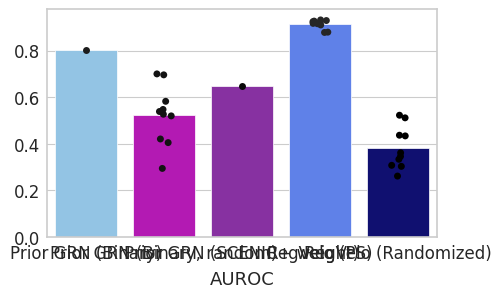

In [80]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(5, 3))
    order = [
        "Prior GRN (Binary)",
        "Prior GRN (Binary, random)",
        "Prior GRN (SCENIC+ weight)",
        "RegVelo (PS)",
        "RegVelo (Randomized)",
    ]
    # Plot the barplot without error bars
    sns.barplot(data=df, x="method", y="AUROC", hue="method", order=order, ax=ax, ci=None)

    # Add jittered dots
    sns.stripplot(
        data=df, x="method", y="AUROC", hue="method", order=order, dodge=False, color="black", ax=ax, jitter=True
    )

    # Remove the duplicate legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[3:6], labels[3:6], bbox_to_anchor=(0.5, -0.1), loc="upper center", ncol=2)

    # Customize labels and other settings
    ax.set(ylabel="", xlabel="AUROC")
    ax.set_xlabel(xlabel="AUROC", fontsize=13)

    if SAVE_FIGURES:
        plt.savefig(
            FIG_DIR / DATASET / "AUROC_ranking_results.svg", format="svg", transparent=True, bbox_inches="tight"
        )
    plt.show()

In [18]:
df

AUROC                      method
0   0.921235                RegVelo (PS)
1   0.928703                RegVelo (PS)
2   0.916508                RegVelo (PS)
3   0.877640                RegVelo (PS)
4   0.909703                RegVelo (PS)
5   0.923754                RegVelo (PS)
6   0.878951                RegVelo (PS)
7   0.931339                RegVelo (PS)
8   0.926287                RegVelo (PS)
9   0.915079                RegVelo (PS)
10  0.804431          Prior GRN (Binary)
11  0.538540  Prior GRN (Binary, random)
12  0.405155  Prior GRN (Binary, random)
13  0.294458  Prior GRN (Binary, random)
14  0.699869  Prior GRN (Binary, random)
15  0.420718  Prior GRN (Binary, random)
16  0.526825  Prior GRN (Binary, random)
17  0.519765  Prior GRN (Binary, random)
18  0.582257  Prior GRN (Binary, random)
19  0.547350  Prior GRN (Binary, random)
20  0.695756  Prior GRN (Binary, random)
21  0.648413  Prior GRN (SCENIC+ weight)
22  0.433920        RegVelo (Randomized)
23  0.333747        RegVelo (Randomized)
24  0.522595        RegVelo (Randomized)
25  0.436818        RegVelo (Randomized)
26  0.261608        RegVelo (Randomized)
27  0.361394        RegVelo (Randomized)
28  0.511401        RegVelo (Randomized)
29  0.345887        RegVelo (Randomized)
30  0.307733        RegVelo (Randomized)
31  0.303333        RegVelo (Randomized)